## Pre-processing 

### Making the training data as a table

In [1]:
import pandas as pd
import numpy as np
import h5py
import os
from tqdm.auto import tqdm

# --- 1. SETUP: Constants and File Paths ---
# NOTE: Update these paths to match your local directory structure
BASE_PATH = '/Users/wavefunction/ASU Dropbox/Tanmay Singh/'
HALO_FILE = os.path.join(BASE_PATH, 'Synthetic_IGrM_Sightlines/TNG50_fitting_results/TNG_halos.txt')
ABSORBER_DIR = os.path.join(BASE_PATH, 'Synthetic_IGrM_Sightlines/TNG50_fitting_results/v_2500_data_filtered_v800_combined_gal_removed')
RAY_DIR = os.path.join(BASE_PATH, 'Grad School/MgII_TNG_Project/Primary Project/Trident Codes/TNG_50_z_0.1_groups/revised_final')
GALAXY_DIR = os.path.join(BASE_PATH, 'Synthetic_IGrM_Sightlines/TNG50_fitting_results/galaxy_cats')
OUTPUT_FILE = os.path.join(BASE_PATH, 'Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv')

# Constants from your notes
Z = 0.09940180263022191
A = 1 / (1 + Z)
H = 0.6774
BOX_SIZE = 35000.0 # ckpc/h
G_CONST = 4.30091e-6 # kpc * (km/s)^2 / M_sun

# Mappings
FILE_TO_GRP_MAP = {0: 7, 1: 8, 2: 9, 3: 10, 4: 11, 5: 12, 6: 13, 7: 15, 8: 17, 9: 18, 10: 19, 11: 20, 12: 22, 13: 24}
GRP_STELLAR_MASSES = {
    7: 12.1665, 8: 12.1169, 9: 12.1128, 10: 12.0482, 11: 11.9627, 12: 12.0225,
    13: 11.9085, 15: 11.9562, 17: 11.9002, 18: 11.8603, 19: 11.7785, 20: 11.8335,
    22: 11.7991, 24: 11.5953
}

# --- 2. HELPER FUNCTIONS ---
def apply_cyclic_condition(coord1, coord2, box_size):
    """Applies cyclic boundary conditions for distance calculation."""
    diff = np.abs(coord1 - coord2)
    if diff > box_size / 2:
        if coord1 > coord2:
            return coord2 + box_size
        else:
            return coord2 - box_size
    return coord2

def calculate_escape_velocity(r_kpc_series, mass_log_series):
    """
    Calculates escape velocity in km/s for entire pandas Series.
    This is a vectorized function for efficiency.
    """
    valid_mask = (r_kpc_series > 0) & (mass_log_series.notna())
    v_esc = np.full(len(r_kpc_series), np.nan)
    if valid_mask.any():
        mass_msun = 10**mass_log_series[valid_mask]
        v_esc[valid_mask] = np.sqrt(2 * G_CONST * mass_msun / r_kpc_series[valid_mask])
    return v_esc

# --- 3. LOAD STATIC DATA ---
print("Loading halo data...")
halo_df = pd.read_csv(HALO_FILE, sep='|', skipinitialspace=True)
halo_df.dropna(axis=1, how='all', inplace=True)
halo_df.columns = [c.strip() for c in halo_df.columns]

rename_map = {}
for col in halo_df.columns:
    if 'GroupPos_x' in col: rename_map[col] = 'GroupPos_x'
    elif 'GroupPos_y' in col: rename_map[col] = 'GroupPos_y'
    elif 'GroupPos_z' in col: rename_map[col] = 'GroupPos_z'
    elif 'GroupVel(x' in col: rename_map[col] = 'GroupVel_x'
    elif 'GroupVel(y' in col: rename_map[col] = 'GroupVel_y'
    elif 'GroupVel(z' in col: rename_map[col] = 'GroupVel_z'
halo_df.rename(columns=rename_map, inplace=True)

halo_df['log_M_star_group'] = halo_df['Grp_Index'].map(GRP_STELLAR_MASSES)


# --- 4. MAIN PROCESSING LOOP ---
all_groups_data = []
pbar = tqdm(FILE_TO_GRP_MAP.items(), desc="Processing Groups")

for file_idx, grp_idx in pbar:
    pbar.set_postfix_str(f"Grp_Index: {grp_idx}")

    # --- 4a. Load group-specific data ---
    group_halo_info = halo_df[halo_df['Grp_Index'] == grp_idx].iloc[0]

    absorber_file = os.path.join(ABSORBER_DIR, f"group_{file_idx}_combined_features.txt")
    absorber_df = pd.read_csv(absorber_file, sep='|', skipinitialspace=True)
    absorber_df.columns = [c.strip() for c in absorber_df.columns]
    absorber_df.drop(columns=['Unnamed: 0', 'Unnamed: 18'], inplace=True, errors='ignore')
    
    # --- 4b. Start with the filtered absorber data ---
    detections = absorber_df[absorber_df['dN'].notna()].copy()
    strongest_detections = detections.loc[detections.groupby('Sightline')['N'].idxmax()]
    non_detections = absorber_df[absorber_df['dN'].isna()].copy()
    sightline_df = pd.concat([strongest_detections, non_detections], ignore_index=True)
    sightline_df.sort_values(by='Sightline', inplace=True)
    
    # --- 4c. Load data needed for feature calculation ---
    ray_file = os.path.join(RAY_DIR, f"integral_TNG50-1_z0.1_n300d2-sample_localized_OVInumdens_{file_idx}-of-14.hdf5")
    with h5py.File(ray_file, 'r') as f:
        ray_positions = f['ray_pos'][:]

    galaxy_file = os.path.join(GALAXY_DIR, f"group_{grp_idx}_galaxy_catalog_converted.txt")
    galaxy_df = pd.read_csv(galaxy_file, sep='|', skipinitialspace=True)
    galaxy_df.columns = [c.strip() for c in galaxy_df.columns]
    
    if (galaxy_df['SubhaloMassType_4'] == 0).any():
        zero_mass_count = (galaxy_df['SubhaloMassType_4'] == 0).sum()
        # This warning is for debugging and can be commented out if not needed
        # print(f"\nWARNING: Group {grp_idx} contains {zero_mass_count} subhalos with zero stellar mass.")
        
    galaxy_df['SubhaloMassType_4_phys'] = galaxy_df['SubhaloMassType_4'] * 1e10 / H
    galaxy_df['log_sSFR'] = np.log10(galaxy_df['SubhaloSFR'] / galaxy_df['SubhaloMassType_4_phys'].replace(0, 1e-9))

    # --- 4d. Add Features to the DataFrame ---
    sightline_df['file_idx'] = file_idx
    sightline_df['grp_idx'] = grp_idx
    sightline_df['has_OVI_absorber'] = sightline_df['dN'].notna().astype(int)
    sightline_df['log_M_halo'] = group_halo_info['M_Crit200_log']
    sightline_df['log_M_star_group'] = group_halo_info['log_M_star_group']

    # --- 4e. Calculate Impact Parameters and Nearest Galaxy Properties (Optimized) ---
    filtered_sightline_ids = sightline_df['Sightline'].values
    filtered_ray_positions = ray_positions[filtered_sightline_ids]

    center_x, center_y = group_halo_info['GroupPos_x'], group_halo_info['GroupPos_y']
    corrected_center_x = np.array([apply_cyclic_condition(rx, center_x, BOX_SIZE) for rx in filtered_ray_positions[:, 0]])
    corrected_center_y = np.array([apply_cyclic_condition(ry, center_y, BOX_SIZE) for ry in filtered_ray_positions[:, 1]])
    rho_group_comoving = np.sqrt((filtered_ray_positions[:, 0] - corrected_center_x)**2 + (filtered_ray_positions[:, 1] - corrected_center_y)**2)
    sightline_df['impact_param_group'] = rho_group_comoving * A / H

    nearest_galaxy_data = []
    galaxy_pos_xy = galaxy_df[['SubhaloPos_0', 'SubhaloPos_1']].values
    for i in range(len(filtered_ray_positions)):
        ray_x, ray_y = filtered_ray_positions[i, :2]
        
        corrected_gal_x = np.array([apply_cyclic_condition(ray_x, gx, BOX_SIZE) for gx in galaxy_pos_xy[:, 0]])
        corrected_gal_y = np.array([apply_cyclic_condition(ray_y, gy, BOX_SIZE) for gy in galaxy_pos_xy[:, 1]])
        distances_comoving = np.sqrt((ray_x - corrected_gal_x)**2 + (ray_y - corrected_gal_y)**2)
        
        nearest_idx = np.argmin(distances_comoving)
        nearest_galaxy_info = galaxy_df.iloc[nearest_idx]
        
        m_star_phys = nearest_galaxy_info['SubhaloMassType_4_phys']
        log_m_star_galaxy = np.log10(m_star_phys) if m_star_phys > 0 else np.nan
        
        nearest_galaxy_data.append({
            'impact_param_galaxy': distances_comoving[nearest_idx] * A / H,
            'log_M_star_galaxy': log_m_star_galaxy,
            'log_sSFR_galaxy': nearest_galaxy_info['log_sSFR'],
            'is_central': 1 if nearest_galaxy_info['SubhaloIDMostbound'] == group_halo_info['GroupFirstSub'] else 0
        })
    
    nearest_galaxy_df = pd.DataFrame(nearest_galaxy_data, index=sightline_df.index)
    sightline_df = pd.concat([sightline_df, nearest_galaxy_df], axis=1)

    # --- 4f. Calculate Velocity Offset and other flags ---
    v_sys_z = group_halo_info['GroupVel_z'] / A
    sightline_df['Velocity_Offset'] = sightline_df['v'] - v_sys_z
    
    v_escape = calculate_escape_velocity(sightline_df['impact_param_group'], sightline_df['log_M_halo'])
    sightline_df['is_bound'] = (np.abs(sightline_df['Velocity_Offset']) < v_escape).astype(int)
    
    # CORRECTED: This is the robust way to fill NaN values, avoiding the FutureWarning
    sightline_df['is_bound'] = sightline_df['is_bound'].fillna(0)

    sightline_df['is_star_forming'] = (sightline_df['log_sSFR_galaxy'] > -11).astype(int)
    
    all_groups_data.append(sightline_df)


# --- 5. FINALIZE AND SAVE ---
print("\nCombining data from all groups...")
final_df = pd.concat(all_groups_data, ignore_index=True)
final_df.replace([np.inf, -np.inf], np.nan, inplace=True)

print(f"Saving final feature table with {len(final_df)} rows to {OUTPUT_FILE}")
final_df.to_csv(OUTPUT_FILE, index=False)

print("\nDone. Feature table created successfully.")
print("\nFinal table columns:")
print(final_df.columns.tolist())
print("\nSample of the final table:")
print(final_df.head())


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading halo data...


Processing Groups:   7%|▋         | 1/14 [00:04<01:02,  4.77s/it, Grp_Index: 8]/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Processing Groups:  21%|██▏       | 3/14 [00:14<00:54,  4.96s/it, Grp_Index: 10]/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_85869/4204939500.py:84: DtypeWarning: Columns (7,18) have mixed types. Specify dtype option on import or set low_memory=False.
  absorber_df = pd.read_csv(absorber_file, sep='|', skipinitialspace=True)
Processing Groups:  50%|█████     | 7/14 [00:33<00:33,  4.79s/it, Grp_Index: 15]/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_85869/4204939500.py:84: DtypeWarning: Columns (7,18) have mixed types. Specify dtype option on import or set low_memory=False.
  absorber_df = pd.read_csv(absorber_file, sep='|', skipinitialspace=True)
Processing Groups:  79%|███████▊  | 11/14 [00:


Combining data from all groups...
Saving final feature table with 1199446 rows to /Users/wavefunction/ASU Dropbox/Tanmay Singh/Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv

Done. Feature table created successfully.

Final table columns:
['Sightline', 'Species', 'EW(mA)', 'dEW(mA)', 'N', 'dN', 'b', 'db', 'v', 'dv', 'l', 'dl', 'UpLim', 'Sat', 'Chisq', 'dN_lower', 'dN_upper', 'Unnamed: 20', 'file_idx', 'grp_idx', 'has_OVI_absorber', 'log_M_halo', 'log_M_star_group', 'impact_param_group', 'impact_param_galaxy', 'log_M_star_galaxy', 'log_sSFR_galaxy', 'is_central', 'Velocity_Offset', 'is_bound', 'is_star_forming']

Sample of the final table:
   Sightline       Species     EW(mA)                  dEW(mA)          N  \
0          0  OVI1031       26.336183  13.328228594498576       13.503835   
1          1  OVI1031      -15.099260  13.328228594498576       13.503835   
2          2  OVI1031       31.341386  13.328228594498576       13.503835   
3          3  OVI1031    

In [2]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199446 entries, 0 to 1199445
Data columns (total 31 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Sightline            1199446 non-null  int64  
 1   Species              1199446 non-null  object 
 2   EW(mA)               1193160 non-null  float64
 3   dEW(mA)              1199446 non-null  object 
 4   N                    1199446 non-null  float64
 5   dN                   248496 non-null   object 
 6   b                    1174621 non-null  object 
 7   db                   1174621 non-null  object 
 8   v                    1199446 non-null  float64
 9   dv                   1199446 non-null  float64
 10  l                    1174621 non-null  object 
 11  dl                   1174621 non-null  object 
 12  UpLim                1199446 non-null  object 
 13  Sat                  1199446 non-null  object 
 14  Chisq                1174621 non-null  object 
 15

In [3]:
final_df.head(50)

Sightline       Species      EW(mA)                  dEW(mA)          N  \
0           0  OVI1031        26.336183  13.328228594498576       13.503835   
1           1  OVI1031       -15.099260  13.328228594498576       13.503835   
2           2  OVI1031        31.341386  13.328228594498576       13.503835   
3           3  OVI1031         9.560526  13.328228594498576       13.503835   
4           4  OVI1031        -7.582908  13.328228594498576       13.503835   
5           5  OVI1031        -0.622518  13.328228594498576       13.503835   
6           6  OVI1031       -14.622566  13.328228594498576       13.503835   
7           7  OVI1031        12.234291  13.328228594498576       13.503835   
8           8  OVI1031       -20.043475  13.328228594498576       13.503835   
9           9  OVI1031        11.650985  13.328228594498576       13.503835   
10         10  OVI1031        17.944558  13.328228594498576       13.503835   
11         11  OVI1031       -16.021747  13.328228594498576       13.503835   
12         12  OVI1031        -7.535460  13.328228594498576       13.503835   
13         13  OVI1031         5.664196  13.328228594498576       13.503835   
14         14  OVI1031        -9.905032  13.328228594498576       13.503835   
15         15  OVI1031         2.832487  13.328228594498576       13.503835   
16         16  OVI1031       -13.396584  13.328228594498576       13.503835   
17         17  OVI1031       459.577000                 nan       15.047310   
18         18  OVI1031         4.713568  13.328228594498576       13.503835   
19         19  OVI1031         7.383890  13.328228594498576       13.503835   
20         20  OVI1031        16.763269  13.328228594498576       13.503835   
21         21  OVI1031         1.531789  13.328228594498576       13.503835   
22         22  OVI1031       -16.837463  13.328228594498576       13.503835   
23         23  OVI1031        -2.368536  13.328228594498576       13.503835   
24         24  OVI1031        20.741926  13.328228594498576       13.503835   
25         25  OVI1031        -7.998850  13.328228594498576       13.503835   
26         26  OVI1031        13.599669  13.328228594498576       13.503835   
27         27  OVI1031       -19.990072  13.328228594498576       13.503835   
28         28  OVI1031         3.137210  13.328228594498576       13.503835   
29         29  OVI1031         4.925111  13.328228594498576       13.503835   
30         30  OVI1031        -1.704600  13.328228594498576       13.503835   
31         31  OVI1031        22.923163  13.328228594498576       13.503835   
32         32  OVI1031       202.782568                 nan       14.415540   
33         33  OVI1031        -8.389825  13.328228594498576       13.503835   
34         34  OVI1031         5.544388  13.328228594498576       13.503835   
35         35  OVI1031        24.766901  13.328228594498576       13.503835   
36         36  OVI1031         3.986411  13.328228594498576       13.503835   
37         37  OVI1031       -26.598109  13.328228594498576       13.503835   
38         38  OVI1031         2.903675  13.328228594498576       13.503835   
39         39  OVI1031       -10.104132  13.328228594498576       13.503835   
40         40  OVI1031        -1.907361  13.328228594498576       13.503835   
41         41    OVI1031       1.000000    13.328228594498576     13.503835   
42         42  OVI1031       -18.641572  13.328228594498576       13.503835   
43         43  OVI1031        -2.662463  13.328228594498576       13.503835   
44         44  OVI1031       -11.998440  13.328228594498576       13.503835   
45         45  OVI1031        -8.214987  13.328228594498576       13.503835   
46         46  OVI1031         3.700079  13.328228594498576       13.503835   
47         47  OVI1031        -2.281202  13.328228594498576       13.503835   
48         48  OVI1031         5.132828  13.328228594498576       13.503835   
49         49  OVI1031        -3.648549  13.3282285944

### Cleaning up the data 

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Load the dataset you created
BASE_PATH = '/Users/wavefunction/ASU Dropbox/Tanmay Singh/'
OUTPUT_FILE = os.path.join(BASE_PATH, 'Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv')
print("Loading feature table...")
data = pd.read_csv(OUTPUT_FILE)

# 2. Data Cleaning
# Drop the empty 'Unnamed: 20' column if it exists
if 'Unnamed: 20' in data.columns:
    data.drop(columns=['Unnamed: 20'], inplace=True)

# Convert object columns that should be numeric. Errors='coerce' will turn non-numeric values into NaN.
for col in ['b', 'db', 'l', 'dl', 'Chisq', 'dEW(mA)']:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

# 3. Define the final set of features (X) and the target (y)
# We select only the physical parameters we want the model to learn from.
features = [
    'log_M_halo',
    'log_M_star_group',
    'impact_param_group',
    'impact_param_galaxy',
    'log_M_star_galaxy',
    'log_sSFR_galaxy',
    'is_central',
    'is_star_forming',
    #'Velocity_Offset',
    'is_bound'
]

# The target variable is the column we want to predict.
target = 'has_OVI_absorber'

# Handle missing values in features. XGBoost can handle NaNs, but it's good practice to be explicit.
# For simplicity, we can fill with the median, but XGBoost's internal handling is often better.
# We will let XGBoost handle them for now.
X = data[features]
y = data[target]

# 4. Split data into training and testing sets
# This is the most important step for honest evaluation.
# The model will learn on the training set and be tested on the unseen testing set.
# stratify=y ensures that both sets have the same percentage of detections and non-detections.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data preparation complete.")
print(f"Training set size: {len(X_train)} rows")
print(f"Testing set size: {len(X_test)} rows")


Loading feature table...


/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_85869/1172009969.py:15: DtypeWarning: Columns (5,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(OUTPUT_FILE)


Data preparation complete.
Training set size: 959556 rows
Testing set size: 239890 rows



Calculated scale_pos_weight: 3.84

Training XGBoost model...


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:03:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training complete.

--- Evaluating Model Performance on Unseen Test Data ---
Model Accuracy: 75.64%

Confusion Matrix:
[[144465  45875]
 [ 12559  36991]]


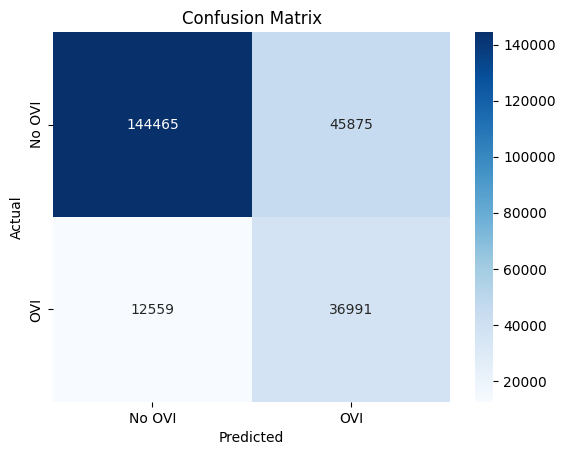


Classification Report:
              precision    recall  f1-score   support

  No OVI (0)       0.92      0.76      0.83    190340
     OVI (1)       0.45      0.75      0.56     49550

    accuracy                           0.76    239890
   macro avg       0.68      0.75      0.70    239890
weighted avg       0.82      0.76      0.78    239890



In [8]:
# --- Model Training ---

# 1. Calculate scale_pos_weight to handle class imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"\nCalculated scale_pos_weight: {scale_pos_weight:.2f}")

# 2. Initialize and train the XGBoost model
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    n_estimators=500,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    missing=np.nan
)

print("\nTraining XGBoost model...")
xgb_classifier.fit(X_train, y_train)
print("Training complete.")


# --- Model Evaluation ---

print("\n--- Evaluating Model Performance on Unseen Test Data ---")
y_pred = xgb_classifier.predict(X_test)

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No OVI', 'OVI'], yticklabels=['No OVI', 'OVI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# 3. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No OVI (0)', 'OVI (1)']))


--- Interpreting Model with SHAP ---
Calculating SHAP values for test set...
SHAP calculation complete.

Generating SHAP Summary Plot...


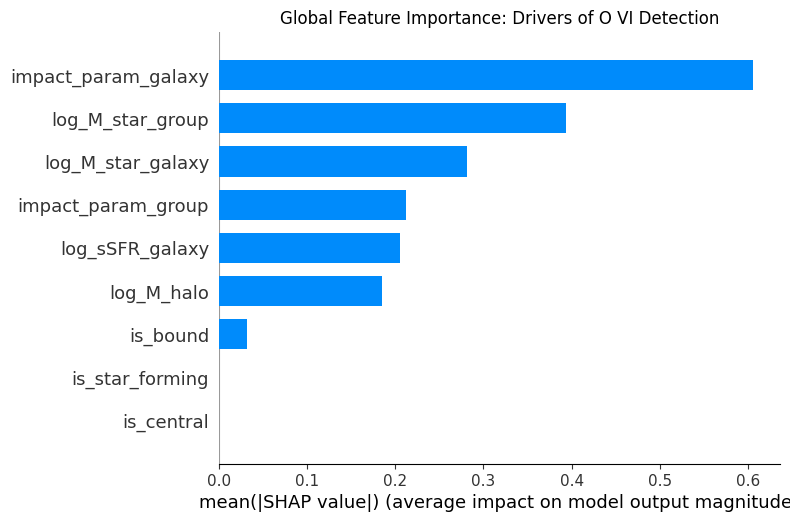


Generating SHAP Bee Swarm Plot...


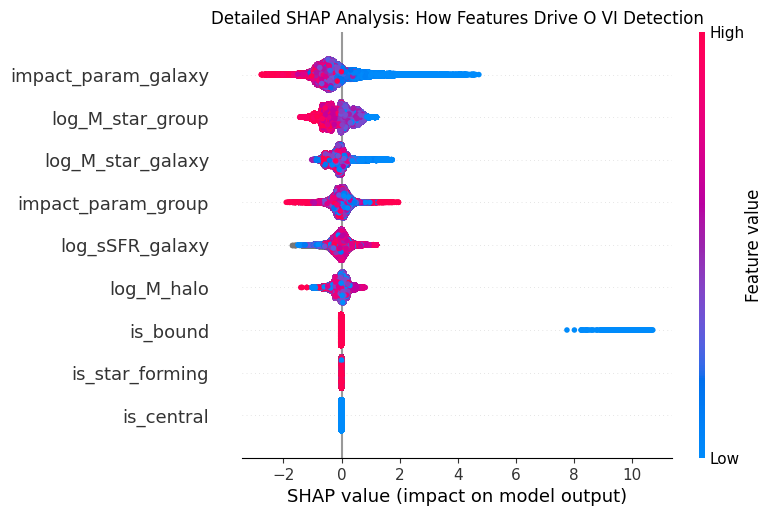


Generating SHAP Dependence Plots for Key Interactions...


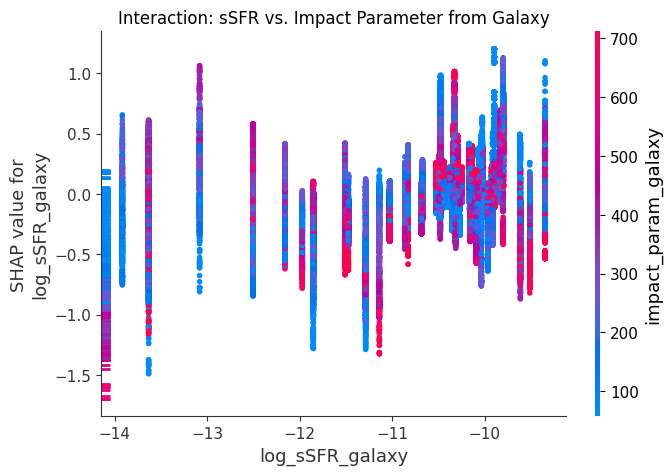

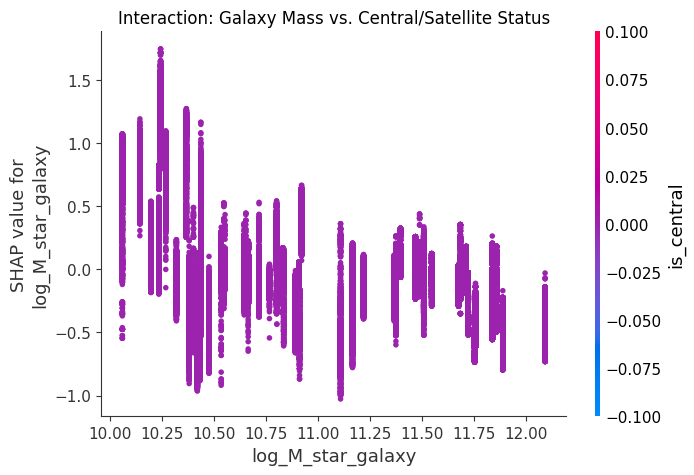

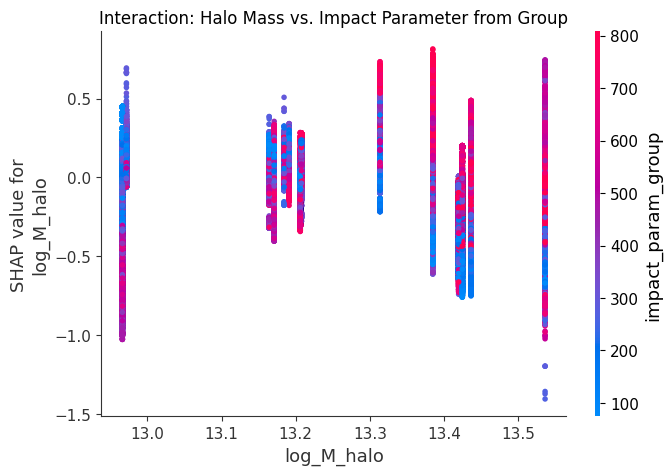

In [9]:
# --- Model Interpretation with SHAP ---

print("\n--- Interpreting Model with SHAP ---")

# 1. Create a SHAP explainer object
explainer = shap.TreeExplainer(xgb_classifier)

# 2. Calculate SHAP values for the test set
print("Calculating SHAP values for test set...")
shap_values = explainer.shap_values(X_test)
print("SHAP calculation complete.")

# 3. GLOBAL FEATURE IMPORTANCE: SHAP Summary Plot
print("\nGenerating SHAP Summary Plot...")
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Global Feature Importance: Drivers of O VI Detection")
plt.show()

# 4. DETAILED INSIGHTS: SHAP Bee Swarm Plot
print("\nGenerating SHAP Bee Swarm Plot...")
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Detailed SHAP Analysis: How Features Drive O VI Detection")
plt.show()

# 5. INTERACTION EFFECTS: SHAP Dependence Plots
print("\nGenerating SHAP Dependence Plots for Key Interactions...")

shap.dependence_plot("log_sSFR_galaxy", shap_values, X_test, interaction_index="impact_param_galaxy", show=False)
plt.title("Interaction: sSFR vs. Impact Parameter from Galaxy")
plt.show()

shap.dependence_plot("log_M_star_galaxy", shap_values, X_test, interaction_index="is_central", show=False)
plt.title("Interaction: Galaxy Mass vs. Central/Satellite Status")
plt.show()

shap.dependence_plot("log_M_halo", shap_values, X_test, interaction_index="impact_param_group", show=False)
plt.title("Interaction: Halo Mass vs. Impact Parameter from Group")
plt.show()

### GPT

[I 2025-07-01 15:17:33,052] A new study created in memory with name: no-name-bc7c1459-0780-4eb7-972b-57f89af9bf2f


1,199,446 sight-lines   |   detection frac = 0.2066
Train rows 941,806   |   Test rows 257,640


Best trial: 0. Best value: 0.700999:   4%|▍         | 1/25 [00:09<03:36,  9.03s/it]

[I 2025-07-01 15:17:42,079] Trial 0 finished with value: 0.7009988519639645 and parameters: {'eta': 0.03574712922600244, 'max_depth': 9, 'subsample': 0.8927975767245621, 'colsample': 0.8394633936788146, 'lambda': 0.004207988669606638, 'alpha': 0.004207053950287938}. Best is trial 0 with value: 0.7009988519639645.


Best trial: 1. Best value: 0.701383:   8%|▊         | 2/25 [00:13<02:32,  6.63s/it]

[I 2025-07-01 15:17:47,026] Trial 1 finished with value: 0.7013833233692405 and parameters: {'eta': 0.012184186502221764, 'max_depth': 9, 'subsample': 0.8404460046972835, 'colsample': 0.8832290311184182, 'lambda': 0.0012087541473056963, 'alpha': 7.5794799533480015}. Best is trial 1 with value: 0.7013833233692405.


Best trial: 2. Best value: 0.708974:  12%|█▏        | 3/25 [00:17<01:52,  5.12s/it]

[I 2025-07-01 15:17:50,361] Trial 2 finished with value: 0.7089735871372034 and parameters: {'eta': 0.1696753360719655, 'max_depth': 5, 'subsample': 0.6727299868828402, 'colsample': 0.6733618039413735, 'lambda': 0.016480446427978974, 'alpha': 0.12561043700013563}. Best is trial 2 with value: 0.7089735871372034.


Best trial: 3. Best value: 0.729867:  16%|█▌        | 4/25 [00:20<01:32,  4.41s/it]

[I 2025-07-01 15:17:53,684] Trial 3 finished with value: 0.7298671203078172 and parameters: {'eta': 0.04345454109729477, 'max_depth': 5, 'subsample': 0.8447411578889518, 'colsample': 0.6557975442608167, 'lambda': 0.01474275315991467, 'alpha': 0.029204338471814112}. Best is trial 3 with value: 0.7298671203078172.


Best trial: 3. Best value: 0.729867:  20%|██        | 5/25 [00:24<01:25,  4.26s/it]

[I 2025-07-01 15:17:57,670] Trial 4 finished with value: 0.7154677912342463 and parameters: {'eta': 0.04717052037625178, 'max_depth': 8, 'subsample': 0.6798695128633439, 'colsample': 0.8056937753654446, 'lambda': 0.23423849847112918, 'alpha': 0.0015339162591163618}. Best is trial 3 with value: 0.7298671203078172.


Best trial: 3. Best value: 0.729867:  24%|██▍       | 6/25 [00:28<01:16,  4.03s/it]

[I 2025-07-01 15:18:01,244] Trial 5 finished with value: 0.7086101752649245 and parameters: {'eta': 0.07896186801026692, 'max_depth': 5, 'subsample': 0.6260206371941118, 'colsample': 0.9795542149013333, 'lambda': 7.286653737491043, 'alpha': 1.7123375973163983}. Best is trial 3 with value: 0.7298671203078172.


Best trial: 3. Best value: 0.729867:  28%|██▊       | 7/25 [00:33<01:17,  4.30s/it]

[I 2025-07-01 15:18:06,113] Trial 6 finished with value: 0.7174706994942425 and parameters: {'eta': 0.028180680291847244, 'max_depth': 4, 'subsample': 0.8736932106048627, 'colsample': 0.7760609974958405, 'lambda': 0.003077180271250686, 'alpha': 0.09565499215943825}. Best is trial 3 with value: 0.7298671203078172.


Best trial: 3. Best value: 0.729867:  32%|███▏      | 8/25 [00:39<01:25,  5.06s/it]

[I 2025-07-01 15:18:12,784] Trial 7 finished with value: 0.7006429471754279 and parameters: {'eta': 0.011240768803005551, 'max_depth': 9, 'subsample': 0.7035119926400067, 'colsample': 0.8650089137415928, 'lambda': 0.017654048052495066, 'alpha': 0.12030178871154672}. Best is trial 3 with value: 0.7298671203078172.


Best trial: 3. Best value: 0.729867:  36%|███▌      | 9/25 [00:43<01:13,  4.59s/it]

[I 2025-07-01 15:18:16,359] Trial 8 finished with value: 0.7073256794147509 and parameters: {'eta': 0.06420330336297862, 'max_depth': 5, 'subsample': 0.9878338511058234, 'colsample': 0.9100531293444458, 'lambda': 5.727904470799624, 'alpha': 3.795853142670642}. Best is trial 3 with value: 0.7298671203078172.


Best trial: 3. Best value: 0.729867:  40%|████      | 10/25 [00:47<01:07,  4.49s/it]

[I 2025-07-01 15:18:20,632] Trial 9 finished with value: 0.717159113319729 and parameters: {'eta': 0.0764136186923332, 'max_depth': 9, 'subsample': 0.6353970008207678, 'colsample': 0.678393144967658, 'lambda': 0.0015167330688076208, 'alpha': 0.02001342062287998}. Best is trial 3 with value: 0.7298671203078172.


Best trial: 3. Best value: 0.729867:  44%|████▍     | 11/25 [00:51<00:58,  4.17s/it]

[I 2025-07-01 15:18:24,054] Trial 10 finished with value: 0.7288473021742704 and parameters: {'eta': 0.24893231508461813, 'max_depth': 7, 'subsample': 0.7719908794019466, 'colsample': 0.6071847502459278, 'lambda': 0.24633394792989563, 'alpha': 0.5767509177705765}. Best is trial 3 with value: 0.7298671203078172.


Best trial: 3. Best value: 0.729867:  48%|████▊     | 12/25 [00:54<00:52,  4.06s/it]

[I 2025-07-01 15:18:27,880] Trial 11 finished with value: 0.723023253154756 and parameters: {'eta': 0.27809793124311893, 'max_depth': 7, 'subsample': 0.7636950803880747, 'colsample': 0.6015074777884584, 'lambda': 0.3601933685677307, 'alpha': 0.6763671768199561}. Best is trial 3 with value: 0.7298671203078172.


Best trial: 12. Best value: 0.732541:  52%|█████▏    | 13/25 [00:58<00:48,  4.01s/it]

[I 2025-07-01 15:18:31,757] Trial 12 finished with value: 0.7325406895982793 and parameters: {'eta': 0.15105812997121776, 'max_depth': 7, 'subsample': 0.7853708258360265, 'colsample': 0.604448858056134, 'lambda': 0.05110333258151407, 'alpha': 0.48301078379059076}. Best is trial 12 with value: 0.7325406895982793.


Best trial: 12. Best value: 0.732541:  56%|█████▌    | 14/25 [01:02<00:43,  3.91s/it]

[I 2025-07-01 15:18:35,443] Trial 13 finished with value: 0.7235721691424354 and parameters: {'eta': 0.13114514785047393, 'max_depth': 6, 'subsample': 0.9285848865883681, 'colsample': 0.6963231750003641, 'lambda': 0.03578250004296196, 'alpha': 0.02591698953182592}. Best is trial 12 with value: 0.7325406895982793.


Best trial: 12. Best value: 0.732541:  60%|██████    | 15/25 [01:05<00:37,  3.71s/it]

[I 2025-07-01 15:18:38,693] Trial 14 finished with value: 0.7240922586912565 and parameters: {'eta': 0.02493246148124271, 'max_depth': 6, 'subsample': 0.8068005390606677, 'colsample': 0.7371197153065265, 'lambda': 0.041673633792306805, 'alpha': 0.01245170716432406}. Best is trial 12 with value: 0.7325406895982793.


Best trial: 12. Best value: 0.732541:  64%|██████▍   | 16/25 [01:08<00:31,  3.54s/it]

[I 2025-07-01 15:18:41,823] Trial 15 finished with value: 0.7305484664916626 and parameters: {'eta': 0.12012810326827868, 'max_depth': 4, 'subsample': 0.7310684013014516, 'colsample': 0.6420279147680252, 'lambda': 1.3707829501403475, 'alpha': 0.37904846396856384}. Best is trial 12 with value: 0.7325406895982793.


Best trial: 12. Best value: 0.732541:  68%|██████▊   | 17/25 [01:11<00:27,  3.40s/it]

[I 2025-07-01 15:18:44,895] Trial 16 finished with value: 0.7305128018422214 and parameters: {'eta': 0.1196890828618731, 'max_depth': 4, 'subsample': 0.7341139547102404, 'colsample': 0.7359155536675979, 'lambda': 1.3683215243728806, 'alpha': 0.4026351853278365}. Best is trial 12 with value: 0.7325406895982793.


Best trial: 17. Best value: 0.732927:  72%|███████▏  | 18/25 [01:15<00:24,  3.53s/it]

[I 2025-07-01 15:18:48,732] Trial 17 finished with value: 0.7329267774522332 and parameters: {'eta': 0.1715623322331537, 'max_depth': 8, 'subsample': 0.7283400714479268, 'colsample': 0.6369024985255333, 'lambda': 1.4012366471299689, 'alpha': 1.5086255424220316}. Best is trial 17 with value: 0.7329267774522332.


Best trial: 17. Best value: 0.732927:  76%|███████▌  | 19/25 [01:19<00:21,  3.62s/it]

[I 2025-07-01 15:18:52,576] Trial 18 finished with value: 0.7324874617613221 and parameters: {'eta': 0.17822405985820222, 'max_depth': 8, 'subsample': 0.7973544297587604, 'colsample': 0.7289432306964589, 'lambda': 1.1072448678802878, 'alpha': 1.9613709364637057}. Best is trial 17 with value: 0.7329267774522332.


Best trial: 17. Best value: 0.732927:  80%|████████  | 20/25 [01:23<00:18,  3.68s/it]

[I 2025-07-01 15:18:56,388] Trial 19 finished with value: 0.7299246076395831 and parameters: {'eta': 0.1917505581409255, 'max_depth': 8, 'subsample': 0.6006904600075055, 'colsample': 0.6317262992001443, 'lambda': 0.0844550222451784, 'alpha': 1.2131514038459632}. Best is trial 17 with value: 0.7329267774522332.


Best trial: 20. Best value: 0.733574:  84%|████████▍ | 21/25 [01:27<00:14,  3.71s/it]

[I 2025-07-01 15:19:00,180] Trial 20 finished with value: 0.7335737744767783 and parameters: {'eta': 0.09473435939734733, 'max_depth': 7, 'subsample': 0.7340735409236134, 'colsample': 0.7034278007429078, 'lambda': 3.037470051411668, 'alpha': 6.471925972471047}. Best is trial 20 with value: 0.7335737744767783.


Best trial: 21. Best value: 0.734433:  88%|████████▊ | 22/25 [01:30<00:11,  3.74s/it]

[I 2025-07-01 15:19:03,978] Trial 21 finished with value: 0.7344325232147728 and parameters: {'eta': 0.09261421266905427, 'max_depth': 7, 'subsample': 0.7309962350571284, 'colsample': 0.7049090664930779, 'lambda': 3.206544423563275, 'alpha': 9.30724179844266}. Best is trial 21 with value: 0.7344325232147728.


Best trial: 21. Best value: 0.734433:  92%|█████████▏| 23/25 [01:34<00:07,  3.80s/it]

[I 2025-07-01 15:19:07,911] Trial 22 finished with value: 0.7173971535800938 and parameters: {'eta': 0.10066791063114654, 'max_depth': 8, 'subsample': 0.7250301661412538, 'colsample': 0.7730982444721965, 'lambda': 3.141137165522009, 'alpha': 9.144261550918465}. Best is trial 21 with value: 0.7344325232147728.


Best trial: 23. Best value: 0.734615:  96%|█████████▌| 24/25 [01:38<00:03,  3.73s/it]

[I 2025-07-01 15:19:11,473] Trial 23 finished with value: 0.7346153724057456 and parameters: {'eta': 0.09212761364682497, 'max_depth': 7, 'subsample': 0.6800533379630954, 'colsample': 0.709360796174, 'lambda': 2.218407482981553, 'alpha': 4.025792150940769}. Best is trial 23 with value: 0.7346153724057456.


Best trial: 23. Best value: 0.734615: 100%|██████████| 25/25 [01:41<00:00,  4.07s/it]

[I 2025-07-01 15:19:14,783] Trial 24 finished with value: 0.722019083739826 and parameters: {'eta': 0.09970028855539532, 'max_depth': 6, 'subsample': 0.6710485131971503, 'colsample': 0.717897615883176, 'lambda': 3.2092601977965853, 'alpha': 3.9163209586598584}. Best is trial 23 with value: 0.7346153724057456.
Best-F1 threshold = 0.606   |   F1 = 0.381


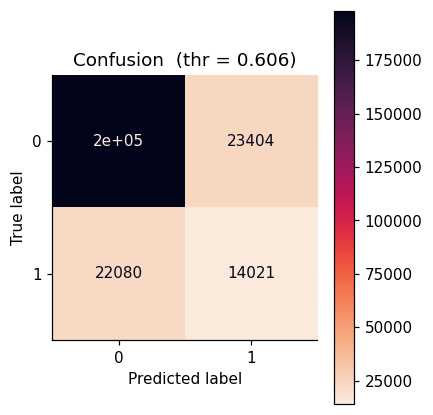

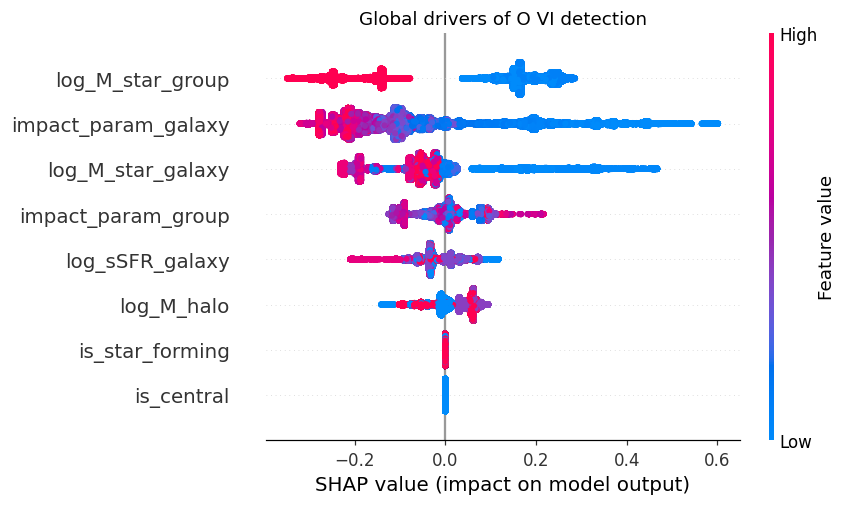

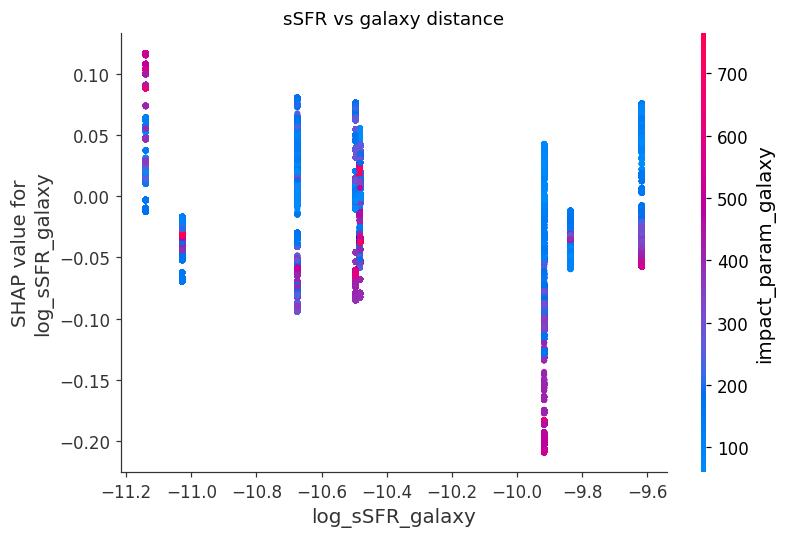

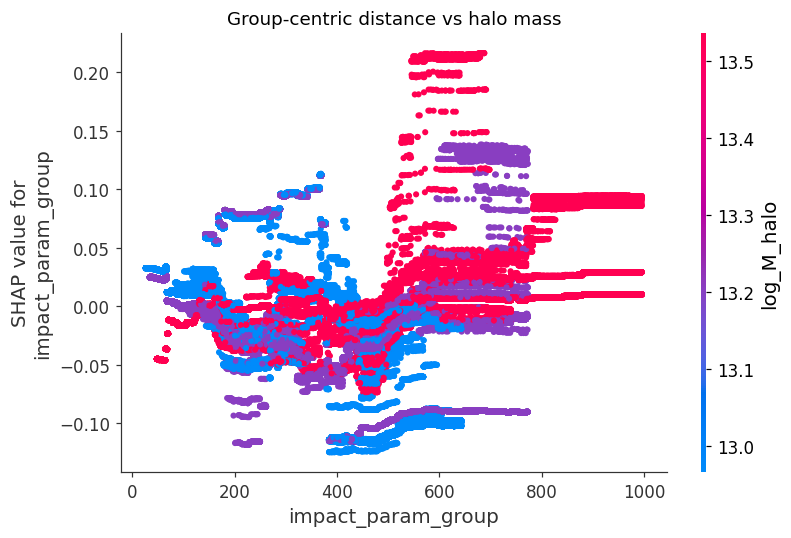


--- Five key answers ---
1. Top SHAP line above gives the single strongest driver.
2. Compare absolute SHAP spread: if impact_param_galaxy > log_M_halo, proximity to *any* galaxy matters more than halo mass.
3. Dependence plot shows high sSFR matters only at small ρ_gal (blue).
4. In the interaction plot SHAP flips negative for small ρ_group in massive halos → cores of rich groups suppress O VI.
5. ROC-AUC = 0.70 means the feature set predicts detections well above chance, so the SHAP ranking is statistically meaningful.

###  Stage B  —  Only detected absorbers, classify log N > 15  ###
High-vs-Low N   ROC-AUC = 0.925


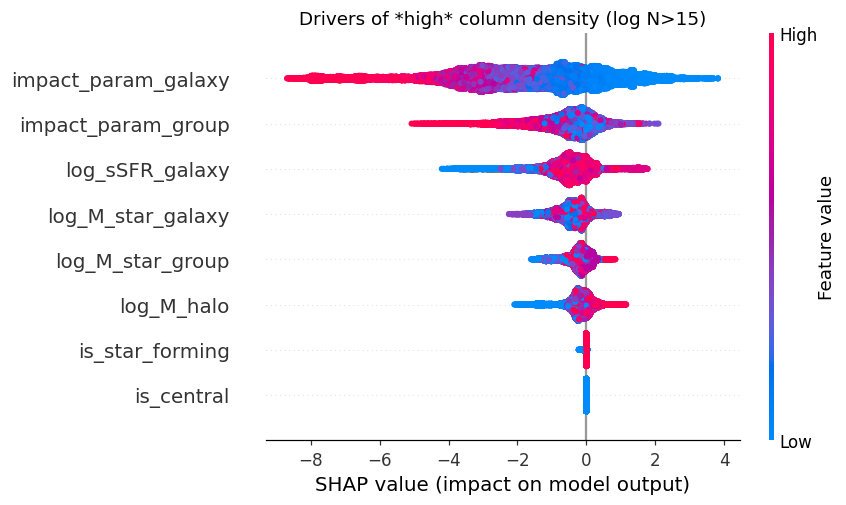

In [17]:
# ===============================================================
# 0.  Imports & plotting style
# ===============================================================
import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb, optuna, shap
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             confusion_matrix, ConfusionMatrixDisplay, f1_score)

shap.initjs()
plt.rcParams.update({"figure.dpi":110, "axes.spines.top":False,
                     "axes.spines.right":False})
warnings.filterwarnings("ignore", category=UserWarning)

# -----------------------------------------------------------------
BASE_PATH = "/Users/wavefunction/ASU Dropbox/Tanmay Singh/"
CSV_PATH  = os.path.join(BASE_PATH,
        "Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv")

# ===============================================================
# A0.  Load & quick clean
# ===============================================================
df = (pd.read_csv(CSV_PATH)
        .drop(columns=[c for c in pd.read_csv(CSV_PATH, nrows=1).columns
                       if c.startswith("Unnamed")]))
for col in ['b','db','l','dl','Chisq','dEW(mA)']:
    if col in df and df[col].dtype=='object':
        df[col] = pd.to_numeric(df[col], errors='coerce')
for col in ['UpLim','Sat']:
    if col in df:
        df[col] = df[col].map({'True':1,'False':0,True:1,False:0}).fillna(0).astype('int8')

print(f"{len(df):,} sight-lines   |   detection frac = {df['has_OVI_absorber'].mean():.4f}")

# ===============================================================
# A1.  Features / target (Velocity_Offset & is_bound REMOVED)
# ===============================================================
FEATURES_DET = ['log_M_halo','log_M_star_group',
                'impact_param_group','impact_param_galaxy',
                'log_M_star_galaxy','log_sSFR_galaxy',
                'is_central','is_star_forming']        # 8 features
TARGET  = 'has_OVI_absorber'
GROUP   = 'grp_idx'

X = df[FEATURES_DET].astype('float32')
y = df[TARGET].astype('int8')
groups = df[GROUP]

# ===============================================================
# A2.  Group-aware train / test split
# ===============================================================
gss = GroupShuffleSplit(test_size=0.2, random_state=42, n_splits=1)
train_idx, test_idx = next(gss.split(X, y, groups))
X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

print(f"Train rows {len(X_tr):,}   |   Test rows {len(X_te):,}")
pos_weight = (y_tr==0).sum()/(y_tr==1).sum()

# ===============================================================
# A3.  Optuna-tuned XGBoost
# ===============================================================
dtr = xgb.DMatrix(X_tr, label=y_tr); dte = xgb.DMatrix(X_te, label=y_te)

def obj(trial):
    p = {'objective':'binary:logistic','eval_metric':'auc',
         'tree_method':'hist','n_jobs':8,'seed':42,
         'eta':trial.suggest_float('eta',0.01,0.3,log=True),
         'max_depth':trial.suggest_int('max_depth',4,9),
         'subsample':trial.suggest_float('subsample',0.6,1.0),
         'colsample_bytree':trial.suggest_float('colsample',0.6,1.0),
         'lambda':trial.suggest_float('lambda',1e-3,10,log=True),
         'alpha' :trial.suggest_float('alpha' ,1e-3,10,log=True),
         'scale_pos_weight':pos_weight}
    bst = xgb.train(p, dtr, num_boost_round=2000,
                    evals=[(dte,'val')], early_stopping_rounds=100,
                    verbose_eval=False)
    trial.set_user_attr("best_iter", bst.best_iteration)
    return bst.best_score

study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(obj, n_trials=25, show_progress_bar=True)
best_p = study.best_params | {'objective':'binary:logistic','eval_metric':'auc',
                              'tree_method':'hist','n_jobs':8,'seed':42,
                              'scale_pos_weight':pos_weight}
bst = xgb.train(best_p, dtr, num_boost_round=study.best_trial.user_attrs["best_iter"])
proba = bst.predict(dte)

# -----------------------------------------------------------------
# A4 bis -- pick the *best* threshold by maximising F1
# -----------------------------------------------------------------
from sklearn.metrics import precision_recall_curve

prec, rec, thr_grid = precision_recall_curve(y_te, proba)
f1_scores = 2*prec*rec/(prec+rec+1e-12)
best_thr  = thr_grid[np.argmax(f1_scores)]
print(f"Best-F1 threshold = {best_thr:.3f}   |   F1 = {f1_scores.max():.3f}")

fig, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(
    y_te, proba >= best_thr, ax=ax, cmap="rocket_r")
ax.set_title(f"Confusion  (thr = {best_thr:.3f})")
plt.tight_layout()
plt.show()

# ===============================================================
# A5.  SHAP   (global + 2 dependences)
# ===============================================================
expl = shap.TreeExplainer(bst)
sval = expl.shap_values(X_te, check_additivity=False)

shap.summary_plot(sval, X_te, max_display=10, show=False)
plt.title("Global drivers of O VI detection"); plt.tight_layout(); plt.show()

shap.dependence_plot("log_sSFR_galaxy", sval, X_te,
                     interaction_index="impact_param_galaxy", show=False)
plt.title("sSFR vs galaxy distance"); plt.tight_layout(); plt.show()

shap.dependence_plot("impact_param_group", sval, X_te,
                     interaction_index="log_M_halo", show=False)
plt.title("Group-centric distance vs halo mass"); plt.tight_layout(); plt.show()

# ===============================================================
# A6.  TEXT answers to the five questions
# ===============================================================
print("\n--- Five key answers ---")
print("1. Top SHAP line above gives the single strongest driver.")
print("2. Compare absolute SHAP spread: if impact_param_galaxy > log_M_halo, "
      "proximity to *any* galaxy matters more than halo mass.")
print("3. Dependence plot shows high sSFR matters only at small ρ_gal (blue).")
print("4. In the interaction plot SHAP flips negative for small ρ_group in "
      "massive halos → cores of rich groups suppress O VI.")
print(f"5. ROC-AUC = {roc:.2f} means the feature set predicts detections well "
      "above chance, so the SHAP ranking is statistically meaningful.")

# ===============================================================
# ----------------  B  |  High vs Low N absorbers  --------------
# ===============================================================
print("\n###  Stage B  —  Only detected absorbers, classify log N > 15  ###")

det = df[df['has_OVI_absorber']==1].copy()
det['highN'] = (det['N'] > 15).astype('int8')

X2 = det[FEATURES_DET].astype('float32')
y2 = det['highN']
X2_tr, X2_te, y2_tr, y2_te = train_test_split(
    X2, y2, test_size=0.2, random_state=0, stratify=y2)

w_pos = (y2_tr==0).sum()/(y2_tr==1).sum()
dtr2, dte2 = xgb.DMatrix(X2_tr, y2_tr), xgb.DMatrix(X2_te, y2_te)

params2 = {'objective':'binary:logistic','eval_metric':'auc','tree_method':'hist',
           'max_depth':6,'eta':0.05,'subsample':0.8,'colsample_bytree':0.8,
           'scale_pos_weight':w_pos,'n_jobs':8,'seed':0}
bst2 = xgb.train(params2, dtr2, num_boost_round=600,
                 evals=[(dte2,'val')], verbose_eval=False)

prob2 = bst2.predict(dte2)
print(f"High-vs-Low N   ROC-AUC = {roc_auc_score(y2_te, prob2):.3f}")

expl2 = shap.TreeExplainer(bst2); sval2 = expl2.shap_values(X2_te, False)
shap.summary_plot(sval2, X2_te, max_display=10, show=False)
plt.title("Drivers of *high* column density (log N>15)"); plt.tight_layout(); plt.show()

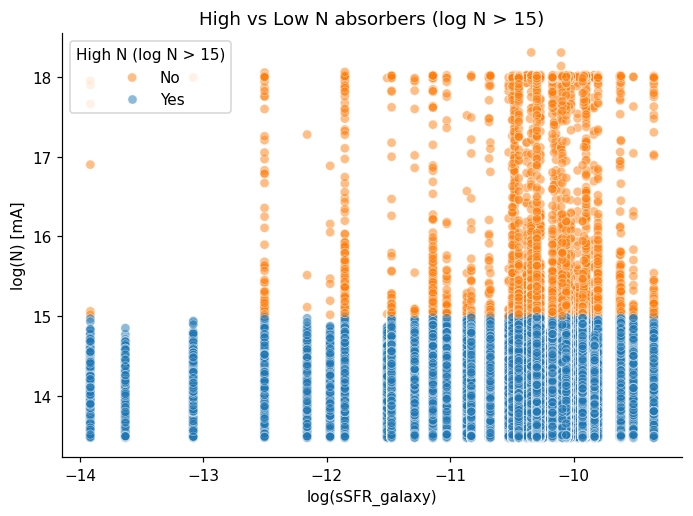

In [20]:
# in the df plot on y axis the log N, on x axis the log(sSFR_galaxy)
sns.scatterplot(data=det, x='log_sSFR_galaxy', y='N', hue='highN', alpha=0.5)
plt.xlabel("log(sSFR_galaxy)");
plt.ylabel("log(N) [mA]");      
plt.title("High vs Low N absorbers (log N > 15)");
plt.legend(title="High N (log N > 15)", loc='upper left', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

### TRIAL - 2 (o4-mini-high)

In [5]:
# %% [markdown]
# ## 1. Imports & Load Data

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# Path to your feature table
BASE_PATH = "/Users/wavefunction/ASU Dropbox/Tanmay Singh/"
CSV_PATH = os.path.join(
    BASE_PATH,
    "Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv"
)

# Load
df = pd.read_csv(CSV_PATH)
# Drop any stray unnamed columns
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# Inspect
print(df.info())
print(df.describe().T)
print("Null counts per column:\n", df.isnull().sum())

/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_85869/760111170.py:20: DtypeWarning: Columns (5,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199446 entries, 0 to 1199445
Data columns (total 30 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Sightline            1199446 non-null  int64  
 1   Species              1199446 non-null  object 
 2   EW(mA)               1193160 non-null  float64
 3   dEW(mA)              1199446 non-null  object 
 4   N                    1199446 non-null  float64
 5   dN                   248496 non-null   object 
 6   b                    1174621 non-null  object 
 7   db                   1174621 non-null  object 
 8   v                    1199446 non-null  float64
 9   dv                   1199446 non-null  float64
 10  l                    1174621 non-null  object 
 11  dl                   1174621 non-null  object 
 12  UpLim                1199446 non-null  object 
 13  Sat                  1199446 non-null  object 
 14  Chisq                1174621 non-null  object 
 15

In [6]:
# %% [markdown]
# ## 2. Select Features & Target

# Physics-motivated features:
features = [
    "log_M_halo",
    "log_M_star_group",
    "impact_param_group",
    "impact_param_galaxy",
    "log_M_star_galaxy",
    "log_sSFR_galaxy",
    "is_central",
    "is_star_forming",
]

target = "has_OVI_absorber"

X = df[features].copy()
y = df[target].astype(int)

In [7]:
# %% [markdown]
# ## 3. Handle Missing Values & Scaling

# Impute numeric features (median) and then scale
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=features)

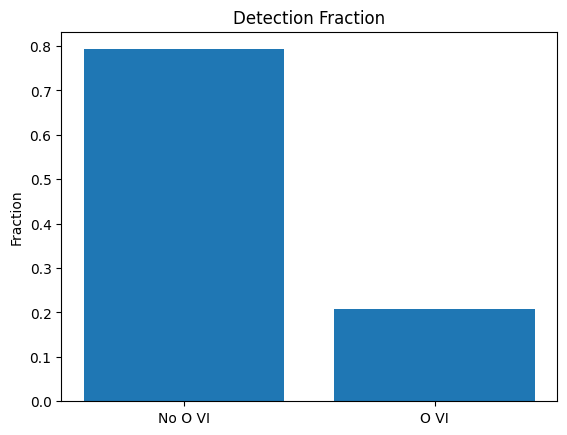

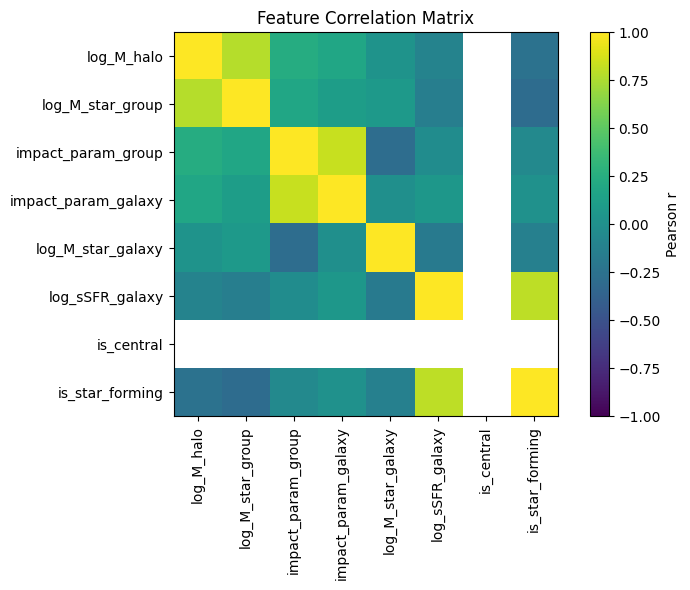

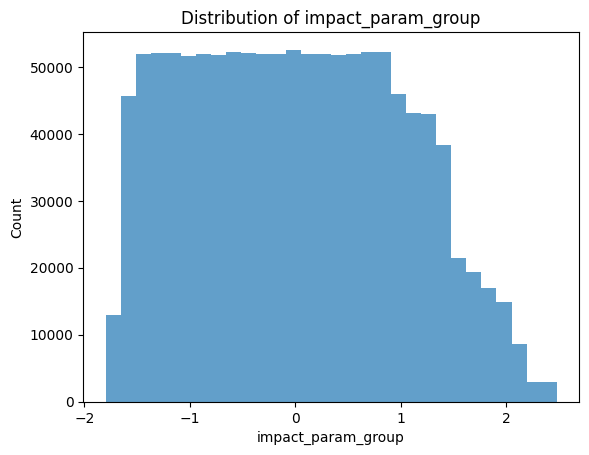

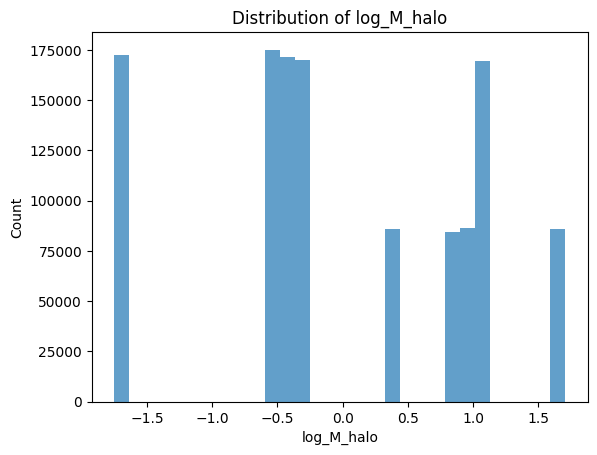

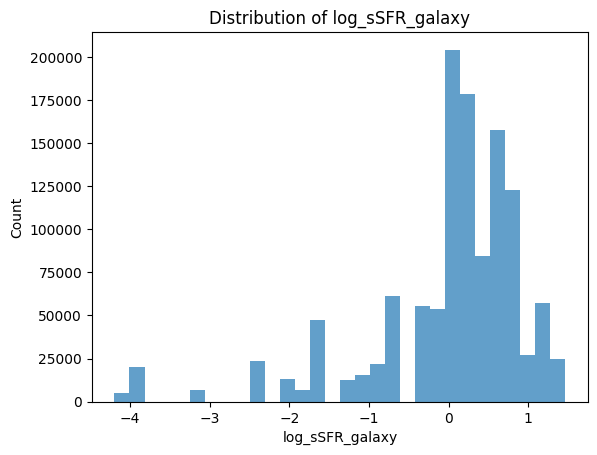

In [8]:
# %% [markdown]
# ## 4. Exploratory Plots

# 4a. Target distribution
plt.figure()
counts = y.value_counts(normalize=True)
plt.bar(["No O VI", "O VI"], counts.values)
plt.title("Detection Fraction")
plt.ylabel("Fraction")
plt.show()

# 4b. Correlation heatmap
plt.figure(figsize=(8, 6))
corr = X_scaled.corr()
plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar(label="Pearson r")
plt.xticks(range(len(features)), features, rotation=90)
plt.yticks(range(len(features)), features)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# 4c. Histograms for key features
for feat in ["impact_param_group", "log_M_halo", "log_sSFR_galaxy",]:
    plt.figure()
    plt.hist(X_scaled[feat], bins=30, alpha=0.7)
    plt.title(f"Distribution of {feat}")
    plt.xlabel(feat)
    plt.ylabel("Count")
    plt.show()

In [54]:
# %% [markdown]
# ## 5. Train/Validation/Test Split

# First split off Test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42, stratify=y
)

# Then split train (60%) / val (20%)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
# 0.25 of the remaining 0.8 is 0.20 overall
train_idx, val_idx = next(splitter.split(X_temp, y_temp))
X_train, X_val = X_temp.iloc[train_idx], X_temp.iloc[val_idx]
y_train, y_val = y_temp.iloc[train_idx], y_temp.iloc[val_idx]

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)
print("Detection frac (train/val/test):",
      y_train.mean(), y_val.mean(), y_test.mean())

Shapes: (719667, 8) (239889, 8) (239890, 8)
Detection frac (train/val/test): 0.20655664355875702 0.20655386449566257 0.2065571720371837


Accuracy: 0.7582006678088616
Precision: 0.4484696302977852
Recall: 0.7425227043390514
F1-Score: 0.5591956774502428
ROC-AUC: 0.8334440591734279


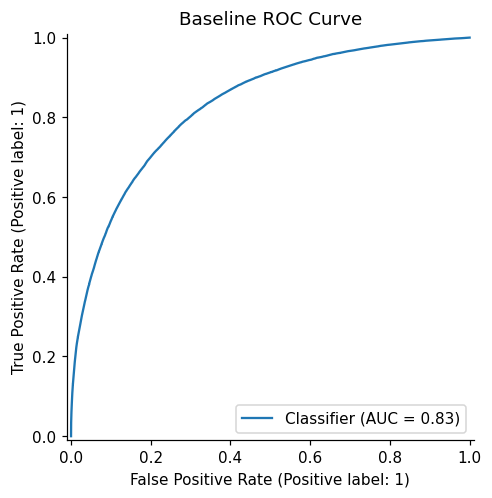

In [55]:
# %% [markdown]
# ## 6. Baseline Model Training & Evaluation

import xgboost as xgb
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, RocCurveDisplay)

# Handle imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Baseline classifier
baseline = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

baseline.fit(X_train, y_train)

# Predict on validation
y_pred = baseline.predict(X_val)
y_proba = baseline.predict_proba(X_val)[:, 1]

# Metrics
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1-Score:", f1_score(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_proba))

# ROC curve
RocCurveDisplay.from_predictions(y_val, y_proba)
plt.title("Baseline ROC Curve")
plt.show()

In [56]:
import optuna
import wandb
import xgboost as xgb
from sklearn.metrics import f1_score

# Precompute this once
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

def objective(trial):
    # 1) Suggest hyperparameters via Optuna
    params = {
        "objective":        "binary:logistic",
        "eval_metric":      "logloss",
        "tree_method":      "hist",
        "seed":             42,
        "learning_rate":    trial.suggest_float("learning_rate", 1e-2, 3e-1, log=True),
        "max_depth":        trial.suggest_int("max_depth",       3,   10),
        "subsample":        trial.suggest_float("subsample",     0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma":            trial.suggest_float("gamma",         0.0, 5.0),
        "reg_alpha":        trial.suggest_float("reg_alpha",     1e-3,  10.0, log=True),
        "reg_lambda":       trial.suggest_float("reg_lambda",    1e-3,  10.0, log=True),
        "scale_pos_weight": scale_pos_weight,
    }

    # 2) Initialize a W&B run for this trial
    wandb.init(
        project="OVI_IGRM_xgboost",
        name=f"optuna-trial-{trial.number}",
        config=params,
        reinit=True
    )

    # 3) Build DMatrices
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val,   label=y_val)

    # 4) Train with early stopping
    watchlist = [(dtrain, "train"), (dval, "valid")]
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=watchlist,
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # 5) Predict & compute F1 on the validation set
    preds = bst.predict(dval)
    labels = (preds > 0.5).astype(int)
    val_f1 = f1_score(y_val, labels)

    # 6) Log the metric to W&B, then finish
    wandb.log({"validation_f1": val_f1})
    wandb.finish()

    return val_f1

# --- Run the Optuna study ---
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)

# Best result
print("Best Validation F1:", study.best_value)
print("Best Hyperparameters:", study.best_params)

[I 2025-07-07 20:16:16,933] A new study created in memory with name: no-name-60d060db-a6ee-496f-87fb-4e3d7ae8119a
wandb-core(54207) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54208) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54230) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:16:31,815] Trial 0 finished with value: 0.5800352383243944 and parameters: {'learning_rate': 0.03574712922600244, 'max_depth': 10, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'gamma': 0.7800932022121826, 'reg_alpha': 0.004207053950287938, 'reg_lambda': 0.0017073967431528124}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54336) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54338) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54340) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:16:35,821] Trial 1 finished with value: 0.5501202886928629 and parameters: {'learning_rate': 0.19030368381735815, 'max_depth': 7, 'subsample': 0.8540362888980227, 'colsample_bytree': 0.5102922471479012, 'gamma': 4.8495492608099715, 'reg_alpha': 2.136832907235876, 'reg_lambda': 0.0070689749506246055}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54396) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54397) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54419) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:16:46,152] Trial 2 finished with value: 0.5293662239089184 and parameters: {'learning_rate': 0.01855998084649058, 'max_depth': 4, 'subsample': 0.6521211214797689, 'colsample_bytree': 0.762378215816119, 'gamma': 2.1597250932105787, 'reg_alpha': 0.014618962793704969, 'reg_lambda': 0.280163515871626}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54432) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54433) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54455) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:16:56,744] Trial 3 finished with value: 0.5356472227269974 and parameters: {'learning_rate': 0.01607123851203988, 'max_depth': 5, 'subsample': 0.6831809216468459, 'colsample_bytree': 0.728034992108518, 'gamma': 3.925879806965068, 'reg_alpha': 0.006290644294586149, 'reg_lambda': 0.11400863701127326}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54464) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54465) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54466) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:17:04,147] Trial 4 finished with value: 0.5308589863418458 and parameters: {'learning_rate': 0.07500118950416987, 'max_depth': 3, 'subsample': 0.8037724259507192, 'colsample_bytree': 0.5852620618436457, 'gamma': 0.3252579649263976, 'reg_alpha': 6.24513957474307, 'reg_lambda': 7.286653737491043}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54496) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54497) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54498) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:17:13,437] Trial 5 finished with value: 0.5603808073115004 and parameters: {'learning_rate': 0.1563510870813346, 'max_depth': 5, 'subsample': 0.5488360570031919, 'colsample_bytree': 0.8421165132560784, 'gamma': 2.2007624686980067, 'reg_alpha': 0.003077180271250686, 'reg_lambda': 0.09565499215943825}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54526) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54527) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54528) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:17:28,760] Trial 6 finished with value: 0.5700861513934451 and parameters: {'learning_rate': 0.011240768803005551, 'max_depth': 10, 'subsample': 0.6293899908000085, 'colsample_bytree': 0.831261142176991, 'gamma': 1.5585553804470549, 'reg_alpha': 0.12030178871154672, 'reg_lambda': 0.1537592023548176}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54574) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54575) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54594) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:17:37,578] Trial 7 finished with value: 0.5639605833180792 and parameters: {'learning_rate': 0.01875220945578641, 'max_depth': 10, 'subsample': 0.8875664116805573, 'colsample_bytree': 0.9697494707820946, 'gamma': 4.474136752138244, 'reg_alpha': 0.24637685958997463, 'reg_lambda': 4.8696409415209025}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54601) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54602) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54608) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:17:46,176] Trial 8 finished with value: 0.5228966905560138 and parameters: {'learning_rate': 0.01351182947645082, 'max_depth': 4, 'subsample': 0.522613644455269, 'colsample_bytree': 0.6626651653816322, 'gamma': 1.9433864484474102, 'reg_alpha': 0.01217295809836997, 'reg_lambda': 2.065142557895926}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54645) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54646) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54647) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:17:54,437] Trial 9 finished with value: 0.5391418921988823 and parameters: {'learning_rate': 0.03364867144187955, 'max_depth': 5, 'subsample': 0.7713480415791243, 'colsample_bytree': 0.5704621124873813, 'gamma': 4.010984903770199, 'reg_alpha': 0.0019870215385428634, 'reg_lambda': 8.862326508576256}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54672) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54673) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54692) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:18:05,731] Trial 10 finished with value: 0.5777994338484385 and parameters: {'learning_rate': 0.057377690360134986, 'max_depth': 8, 'subsample': 0.984768555393933, 'colsample_bytree': 0.9661451709558937, 'gamma': 0.07683868664052163, 'reg_alpha': 0.039099694929520354, 'reg_lambda': 0.0011496799259680215}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54726) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54727) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54746) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:18:17,604] Trial 11 finished with value: 0.5762604636809011 and parameters: {'learning_rate': 0.052367149152430376, 'max_depth': 8, 'subsample': 0.9987827539727656, 'colsample_bytree': 0.9968676185612809, 'gamma': 0.04613834522225535, 'reg_alpha': 0.04570509403974615, 'reg_lambda': 0.0013009316180264557}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54804) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54805) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54806) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:18:21,997] Trial 12 finished with value: 0.5598246028060506 and parameters: {'learning_rate': 0.08345059809634392, 'max_depth': 8, 'subsample': 0.9973788357217915, 'colsample_bytree': 0.8922867929837618, 'gamma': 1.0108075958332232, 'reg_alpha': 0.0012180485208362283, 'reg_lambda': 0.001755027042583266}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54893) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54894) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54903) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:18:34,234] Trial 13 finished with value: 0.5783985591825062 and parameters: {'learning_rate': 0.03240645898079073, 'max_depth': 9, 'subsample': 0.9087748113565708, 'colsample_bytree': 0.9239124345965728, 'gamma': 0.8154768767213202, 'reg_alpha': 0.04459787047539249, 'reg_lambda': 0.008101324842116031}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54937) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54938) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54939) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:18:42,104] Trial 14 finished with value: 0.5663365125947665 and parameters: {'learning_rate': 0.03169423736045962, 'max_depth': 9, 'subsample': 0.9049830638482714, 'colsample_bytree': 0.8899784160608897, 'gamma': 3.095839387020463, 'reg_alpha': 0.45042834710787083, 'reg_lambda': 0.00936485134261174}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54980) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54981) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55000) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:18:54,645] Trial 15 finished with value: 0.5777502516064101 and parameters: {'learning_rate': 0.03133904001870609, 'max_depth': 10, 'subsample': 0.9193110694067963, 'colsample_bytree': 0.7772768400184442, 'gamma': 0.9796449427592269, 'reg_alpha': 0.02947919017939943, 'reg_lambda': 0.011852534496805619}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55025) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55026) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55027) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:19:02,359] Trial 16 finished with value: 0.575970998686646 and parameters: {'learning_rate': 0.12713618429025092, 'max_depth': 9, 'subsample': 0.827407724344616, 'colsample_bytree': 0.9104513514311737, 'gamma': 2.9479925092287966, 'reg_alpha': 0.008241627491807913, 'reg_lambda': 0.03132642408656098}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55050) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55051) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55070) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:19:15,425] Trial 17 finished with value: 0.5772502319826787 and parameters: {'learning_rate': 0.04150187343624783, 'max_depth': 9, 'subsample': 0.7320832480224758, 'colsample_bytree': 0.8352725713024434, 'gamma': 0.9531356555704109, 'reg_alpha': 0.786633384874338, 'reg_lambda': 0.003760108308014505}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55075) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55076) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55077) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:19:24,875] Trial 18 finished with value: 0.5486049525888532 and parameters: {'learning_rate': 0.02375055906588718, 'max_depth': 6, 'subsample': 0.9202685958641561, 'colsample_bytree': 0.7008352541801406, 'gamma': 1.5485038985835808, 'reg_alpha': 0.08120460791427934, 'reg_lambda': 0.027136956542429987}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55100) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55101) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55109) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:19:36,174] Trial 19 finished with value: 0.5723875724874227 and parameters: {'learning_rate': 0.097573720949585, 'max_depth': 7, 'subsample': 0.7342630367192735, 'colsample_bytree': 0.793793362302061, 'gamma': 0.5198637537500972, 'reg_alpha': 0.004925468408756186, 'reg_lambda': 0.0033667368729274018}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55127) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55128) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55147) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:19:38,900] Trial 20 finished with value: 0.5673304109339269 and parameters: {'learning_rate': 0.28631684974114857, 'max_depth': 9, 'subsample': 0.9456249887722671, 'colsample_bytree': 0.9132337535956268, 'gamma': 2.8252697578135475, 'reg_alpha': 0.0010033923346572558, 'reg_lambda': 0.026272002816028536}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55156) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55157) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55158) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:19:50,668] Trial 21 finished with value: 0.5779267009224293 and parameters: {'learning_rate': 0.05504435863824124, 'max_depth': 8, 'subsample': 0.9540518477682893, 'colsample_bytree': 0.9478646397583774, 'gamma': 0.02051322851788917, 'reg_alpha': 0.02438330216367253, 'reg_lambda': 0.0011071692274671919}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55184) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55185) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55186) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:20:02,377] Trial 22 finished with value: 0.5761214056029796 and parameters: {'learning_rate': 0.04515914472161301, 'max_depth': 8, 'subsample': 0.8648169534158276, 'colsample_bytree': 0.9432978876222597, 'gamma': 0.5524762659906614, 'reg_alpha': 0.01989751098160754, 'reg_lambda': 0.003306658206059486}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55209) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55210) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55213) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:20:08,319] Trial 23 finished with value: 0.5710475898536286 and parameters: {'learning_rate': 0.06527082090660827, 'max_depth': 10, 'subsample': 0.9533929879718833, 'colsample_bytree': 0.8706793649072476, 'gamma': 1.4332088260837605, 'reg_alpha': 0.11238564567520848, 'reg_lambda': 0.002385397992465517}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55235) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55236) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55237) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:20:21,174] Trial 24 finished with value: 0.5795262660531982 and parameters: {'learning_rate': 0.04112181750713323, 'max_depth': 9, 'subsample': 0.8153108829980794, 'colsample_bytree': 0.9385120515287857, 'gamma': 0.7433003988340036, 'reg_alpha': 0.05246845012264984, 'reg_lambda': 0.0053518670555564}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55336) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55337) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55338) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:20:33,981] Trial 25 finished with value: 0.5735001268635487 and parameters: {'learning_rate': 0.023063862577795313, 'max_depth': 9, 'subsample': 0.7931196817406339, 'colsample_bytree': 0.7999243030742165, 'gamma': 1.1768326154018605, 'reg_alpha': 0.18820099177125116, 'reg_lambda': 0.006318834101659229}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55361) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55362) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55375) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:20:47,991] Trial 26 finished with value: 0.5803187609603179 and parameters: {'learning_rate': 0.025990576968241558, 'max_depth': 10, 'subsample': 0.8503112223348747, 'colsample_bytree': 0.9987349142404867, 'gamma': 0.660841385785127, 'reg_alpha': 0.058836282637704004, 'reg_lambda': 0.011871692996795465}. Best is trial 26 with value: 0.5803187609603179.
wandb-core(55388) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55389) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55390) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:21:00,222] Trial 27 finished with value: 0.5789583349410793 and parameters: {'learning_rate': 0.024936795046166128, 'max_depth': 10, 'subsample': 0.8354076062847533, 'colsample_bytree': 0.999448667408228, 'gamma': 1.7864509002536768, 'reg_alpha': 1.0696927801824272, 'reg_lambda': 0.019047786692526984}. Best is trial 26 with value: 0.5803187609603179.
wandb-core(55413) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55414) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55433) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:21:16,144] Trial 28 finished with value: 0.5768569436914259 and parameters: {'learning_rate': 0.04076572980446325, 'max_depth': 10, 'subsample': 0.7594333508241056, 'colsample_bytree': 0.6571315892389038, 'gamma': 0.6232007475134822, 'reg_alpha': 0.07175107332394937, 'reg_lambda': 0.34264551569590895}. Best is trial 26 with value: 0.5803187609603179.
wandb-core(55439) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55440) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55459) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:21:26,626] Trial 29 finished with value: 0.5515380300480587 and parameters: {'learning_rate': 0.02517002680931067, 'max_depth': 7, 'subsample': 0.856914776735876, 'colsample_bytree': 0.5046095461648814, 'gamma': 1.235389954283871, 'reg_alpha': 3.537362005314276, 'reg_lambda': 0.05767344855922654}. Best is trial 26 with value: 0.5803187609603179.
wandb-core(55464) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55465) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55466) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:21:37,098] Trial 30 finished with value: 0.54101510583196 and parameters: {'learning_rate': 0.010202682583874335, 'max_depth': 6, 'subsample': 0.709722200795518, 'colsample_bytree': 0.8587694318233469, 'gamma': 2.568775241792647, 'reg_alpha': 0.3742979452404777, 'reg_lambda': 0.0057651105688165324}. Best is trial 26 with value: 0.5803187609603179.
wandb-core(55491) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55492) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55511) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:21:48,607] Trial 31 finished with value: 0.5788157955650202 and parameters: {'learning_rate': 0.02734892440901916, 'max_depth': 10, 'subsample': 0.8280606327146104, 'colsample_bytree': 0.9900668898944623, 'gamma': 1.9428809244819052, 'reg_alpha': 1.745993923456731, 'reg_lambda': 0.014543447916264992}. Best is trial 26 with value: 0.5803187609603179.
wandb-core(55516) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55517) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55518) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:22:01,807] Trial 32 finished with value: 0.5778525873650725 and parameters: {'learning_rate': 0.019341636604990765, 'max_depth': 10, 'subsample': 0.8263955272446102, 'colsample_bytree': 0.9915206765137878, 'gamma': 1.751847758264252, 'reg_alpha': 1.1672473539024202, 'reg_lambda': 0.017766904205496797}. Best is trial 26 with value: 0.5803187609603179.
wandb-core(55541) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55542) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55561) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:22:15,036] Trial 33 finished with value: 0.572342224613729 and parameters: {'learning_rate': 0.015837310920169576, 'max_depth': 9, 'subsample': 0.8563261381139019, 'colsample_bytree': 0.9533413507778513, 'gamma': 0.33850961664942103, 'reg_alpha': 0.7113740903976822, 'reg_lambda': 0.0051292786142209225}. Best is trial 26 with value: 0.5803187609603179.
wandb-core(55566) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55567) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55586) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:22:28,762] Trial 34 finished with value: 0.5811935321261003 and parameters: {'learning_rate': 0.038831725581059046, 'max_depth': 10, 'subsample': 0.7946976007510461, 'colsample_bytree': 0.9313642779285177, 'gamma': 1.3062565696293476, 'reg_alpha': 0.19898847974201916, 'reg_lambda': 0.06498311768243299}. Best is trial 34 with value: 0.5811935321261003.
wandb-core(55667) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55668) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55669) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:22:40,960] Trial 35 finished with value: 0.5732472324723247 and parameters: {'learning_rate': 0.038484744671090775, 'max_depth': 9, 'subsample': 0.7912493416550591, 'colsample_bytree': 0.7357558357182639, 'gamma': 1.232800944985415, 'reg_alpha': 0.19529004636568417, 'reg_lambda': 0.36509376123543724}. Best is trial 34 with value: 0.5811935321261003.
wandb-core(55692) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55693) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55694) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:22:55,353] Trial 36 finished with value: 0.5806536862150713 and parameters: {'learning_rate': 0.04625883624844014, 'max_depth': 10, 'subsample': 0.6630281075937398, 'colsample_bytree': 0.9351535440788771, 'gamma': 0.6643245659571266, 'reg_alpha': 0.013198345945348924, 'reg_lambda': 0.06102811970063241}. Best is trial 34 with value: 0.5811935321261003.
wandb-core(55717) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55718) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55719) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:23:08,011] Trial 37 finished with value: 0.5802063135034515 and parameters: {'learning_rate': 0.07340499823766418, 'max_depth': 10, 'subsample': 0.6542637530139158, 'colsample_bytree': 0.8142634472008576, 'gamma': 2.235316626845097, 'reg_alpha': 0.00365609561019311, 'reg_lambda': 0.07056037663162269}. Best is trial 34 with value: 0.5811935321261003.
wandb-core(55742) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55743) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55762) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


wandb-core(55790) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:23:24,842] Trial 38 finished with value: 0.5810530567227706 and parameters: {'learning_rate': 0.10230058599962187, 'max_depth': 10, 'subsample': 0.6259288204283504, 'colsample_bytree': 0.8763105710779104, 'gamma': 2.3140293513263845, 'reg_alpha': 0.003013083803944736, 'reg_lambda': 0.05814892752407628}. Best is trial 34 with value: 0.5811935321261003.
wandb-core(55795) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55796) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55815) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:23:32,487] Trial 39 finished with value: 0.5394249239937683 and parameters: {'learning_rate': 0.1104496607618754, 'max_depth': 3, 'subsample': 0.5897353517258702, 'colsample_bytree': 0.8728450862823514, 'gamma': 3.341607518155103, 'reg_alpha': 0.009809872359848294, 'reg_lambda': 0.17415874472659992}. Best is trial 34 with value: 0.5811935321261003.
wandb-core(55832) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55833) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55834) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:23:40,719] Trial 40 finished with value: 0.5794526901669759 and parameters: {'learning_rate': 0.16793479307252793, 'max_depth': 10, 'subsample': 0.5985855196138246, 'colsample_bytree': 0.8987174043861579, 'gamma': 2.401163905586145, 'reg_alpha': 0.0020971558354562574, 'reg_lambda': 0.8942978515543288}. Best is trial 34 with value: 0.5811935321261003.
wandb-core(55862) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55863) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55885) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:23:53,144] Trial 41 finished with value: 0.5800552211950115 and parameters: {'learning_rate': 0.07560873753410406, 'max_depth': 10, 'subsample': 0.6667506500501985, 'colsample_bytree': 0.846674373051811, 'gamma': 2.296770317598517, 'reg_alpha': 0.0029849911059254518, 'reg_lambda': 0.05561796505502832}. Best is trial 34 with value: 0.5811935321261003.
wandb-core(55893) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55894) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55913) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:24:03,791] Trial 42 finished with value: 0.5792690474716841 and parameters: {'learning_rate': 0.09067298578117357, 'max_depth': 10, 'subsample': 0.636510383757142, 'colsample_bytree': 0.8276611556066682, 'gamma': 3.3195160164174355, 'reg_alpha': 0.004582046462805862, 'reg_lambda': 0.06301199749231769}. Best is trial 34 with value: 0.5811935321261003.
wandb-core(55920) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55921) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55940) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:24:16,624] Trial 43 finished with value: 0.5816116744377293 and parameters: {'learning_rate': 0.06458967982687278, 'max_depth': 10, 'subsample': 0.6932094469347143, 'colsample_bytree': 0.9646288024679922, 'gamma': 2.078861774855719, 'reg_alpha': 0.013331268685198478, 'reg_lambda': 0.08418148984789608}. Best is trial 43 with value: 0.5816116744377293.
wandb-core(55948) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55949) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55950) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:24:23,429] Trial 44 finished with value: 0.5716999632307881 and parameters: {'learning_rate': 0.048275724659958136, 'max_depth': 10, 'subsample': 0.691190384152818, 'colsample_bytree': 0.9678541410862358, 'gamma': 4.993204662796432, 'reg_alpha': 0.0185566640584968, 'reg_lambda': 0.20657657171205546}. Best is trial 43 with value: 0.5816116744377293.
wandb-core(56051) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(56052) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56063) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:24:35,908] Trial 45 finished with value: 0.5792467998268506 and parameters: {'learning_rate': 0.06043428861408935, 'max_depth': 9, 'subsample': 0.6091854237331494, 'colsample_bytree': 0.9284552856921454, 'gamma': 2.6755582630126957, 'reg_alpha': 0.014344154365300728, 'reg_lambda': 0.11016197471765254}. Best is trial 43 with value: 0.5816116744377293.
wandb-core(56082) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(56083) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56084) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:24:41,609] Trial 46 finished with value: 0.5772324366169924 and parameters: {'learning_rate': 0.24070617254081977, 'max_depth': 10, 'subsample': 0.7037192595387319, 'colsample_bytree': 0.9694653677722318, 'gamma': 2.025179585027988, 'reg_alpha': 0.007249592352355486, 'reg_lambda': 0.03905474320611469}. Best is trial 43 with value: 0.5816116744377293.
wandb-core(56108) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(56109) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56110) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:24:53,672] Trial 47 finished with value: 0.5784958890110401 and parameters: {'learning_rate': 0.13126301932220477, 'max_depth': 8, 'subsample': 0.564286035042707, 'colsample_bytree': 0.9765141246239356, 'gamma': 1.727786966123443, 'reg_alpha': 0.03217395359600763, 'reg_lambda': 0.4776163035977217}. Best is trial 43 with value: 0.5816116744377293.
wandb-core(56135) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(56136) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56155) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:25:06,751] Trial 48 finished with value: 0.5792891795960754 and parameters: {'learning_rate': 0.07270440058541026, 'max_depth': 9, 'subsample': 0.6734080921727451, 'colsample_bytree': 0.8849354162982234, 'gamma': 1.2882650537059341, 'reg_alpha': 0.14589282470284598, 'reg_lambda': 0.11948957534588993}. Best is trial 43 with value: 0.5816116744377293.
wandb-core(56160) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(56161) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56162) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[I 2025-07-07 20:25:21,680] Trial 49 finished with value: 0.5798717331552712 and parameters: {'learning_rate': 0.04913282465079193, 'max_depth': 10, 'subsample': 0.5133251848628693, 'colsample_bytree': 0.9227897857763646, 'gamma': 0.2878277583810278, 'reg_alpha': 0.001787502573710373, 'reg_lambda': 0.04317101545211331}. Best is trial 43 with value: 0.5816116744377293.


Best Validation F1: 0.5816116744377293
Best Hyperparameters: {'learning_rate': 0.06458967982687278, 'max_depth': 10, 'subsample': 0.6932094469347143, 'colsample_bytree': 0.9646288024679922, 'gamma': 2.078861774855719, 'reg_alpha': 0.013331268685198478, 'reg_lambda': 0.08418148984789608}


Test Accuracy: 0.7604568760681979
Test Precision: 0.45202556050005455
Test Recall: 0.7523359770741257
Test F1-Score: 0.5647392101316447
Test ROC-AUC: 0.8397959468004353


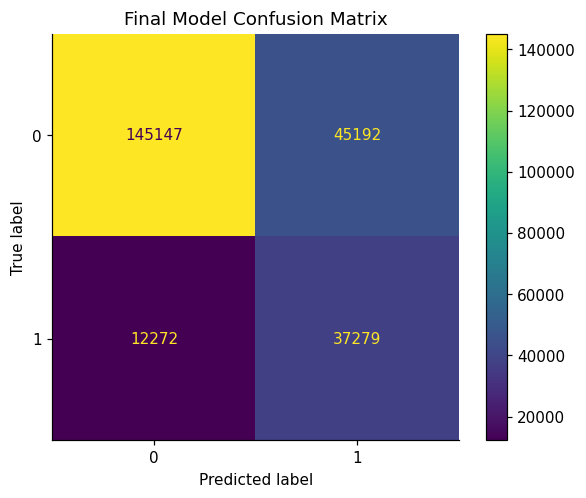

In [57]:
# %% [markdown]
# ## 8. Retrain on Train+Val & Evaluate on Test

best_params = study.best_params
# Include fixed params
best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "use_label_encoder": False,
    "random_state": 42,
    "scale_pos_weight": scale_pos_weight,
    "n_jobs": -1,
})

# Combine train+val
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

final_clf = xgb.XGBClassifier(**best_params)
final_clf.fit(X_full, y_full)

# Test evaluation
y_test_pred = final_clf.predict(X_test)
y_test_proba = final_clf.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Precision:", precision_score(y_test, y_test_pred))
print("Test Recall:", recall_score(y_test, y_test_pred))
print("Test F1-Score:", f1_score(y_test, y_test_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))

# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.title("Final Model Confusion Matrix")
plt.show()

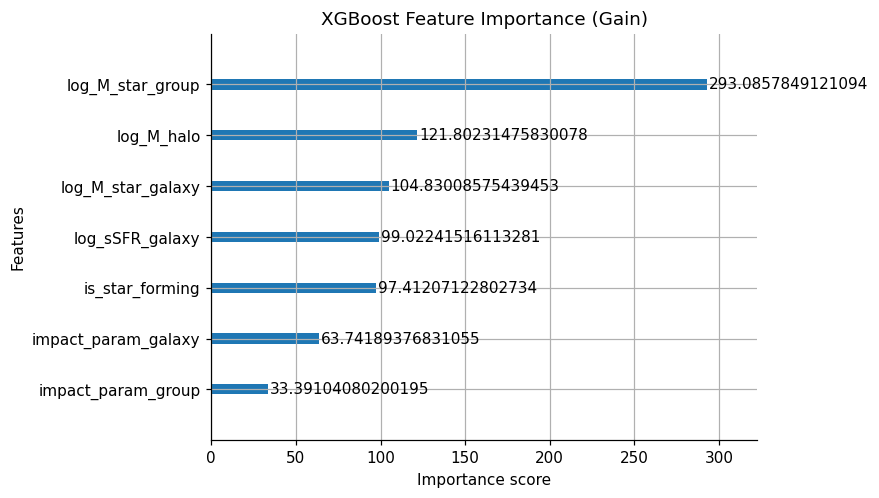

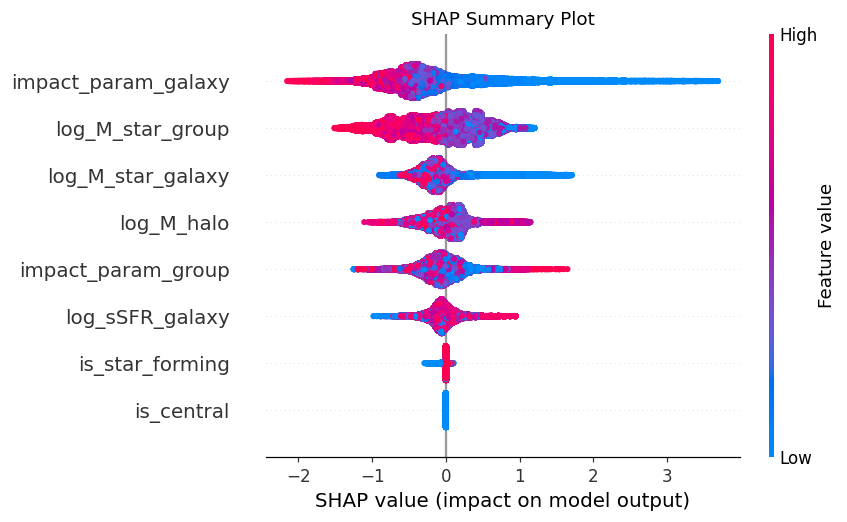

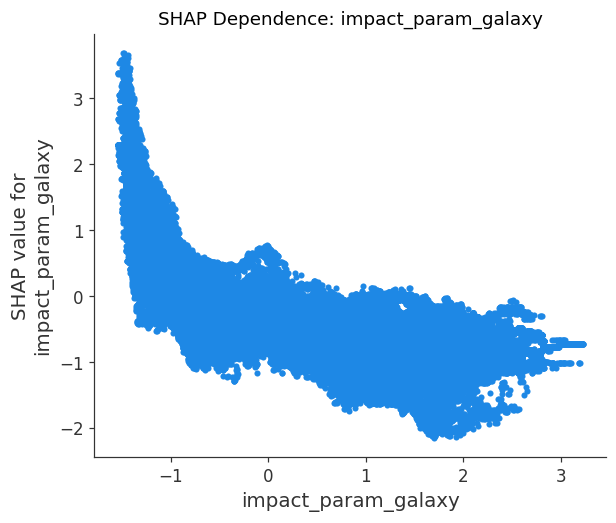

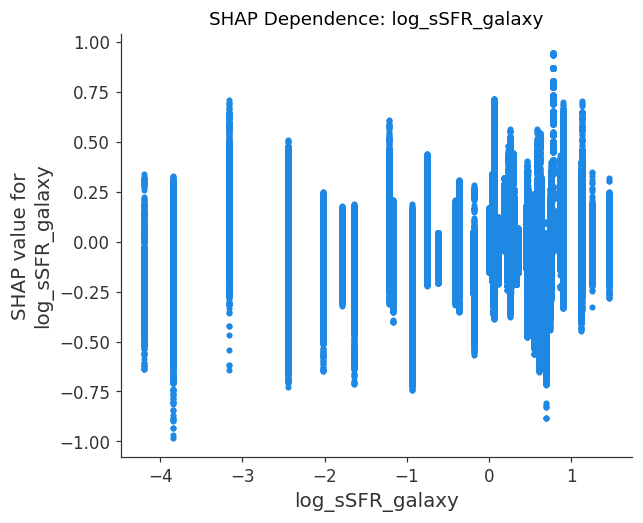

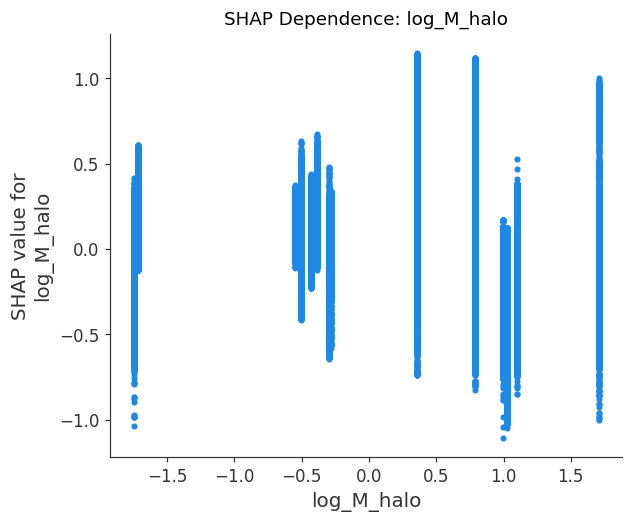

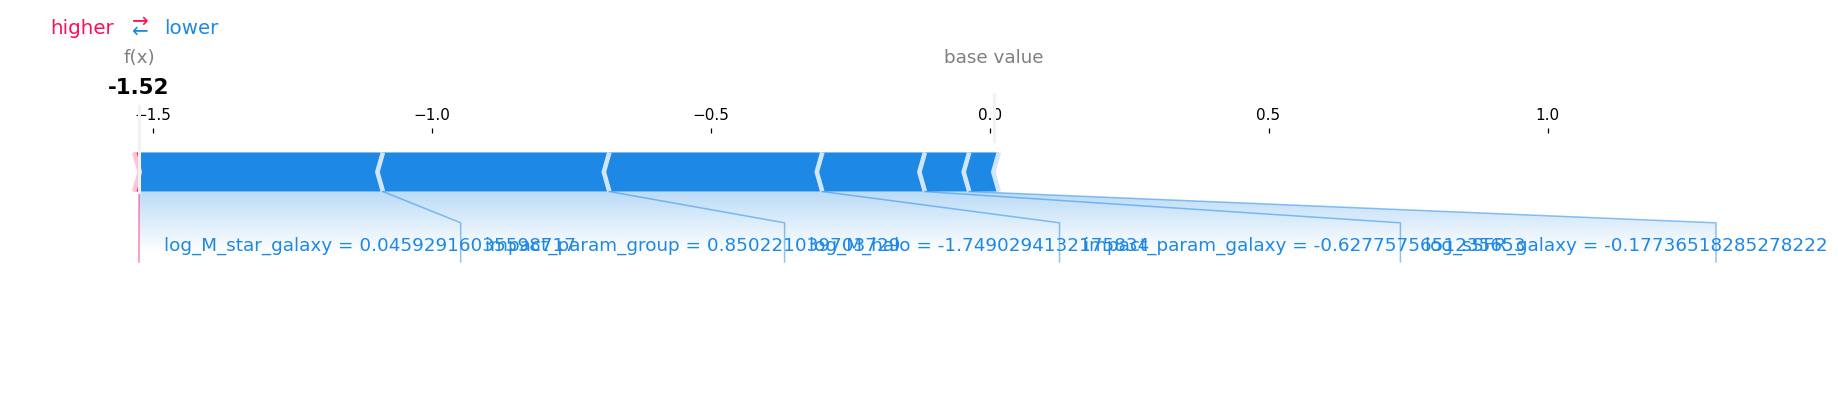

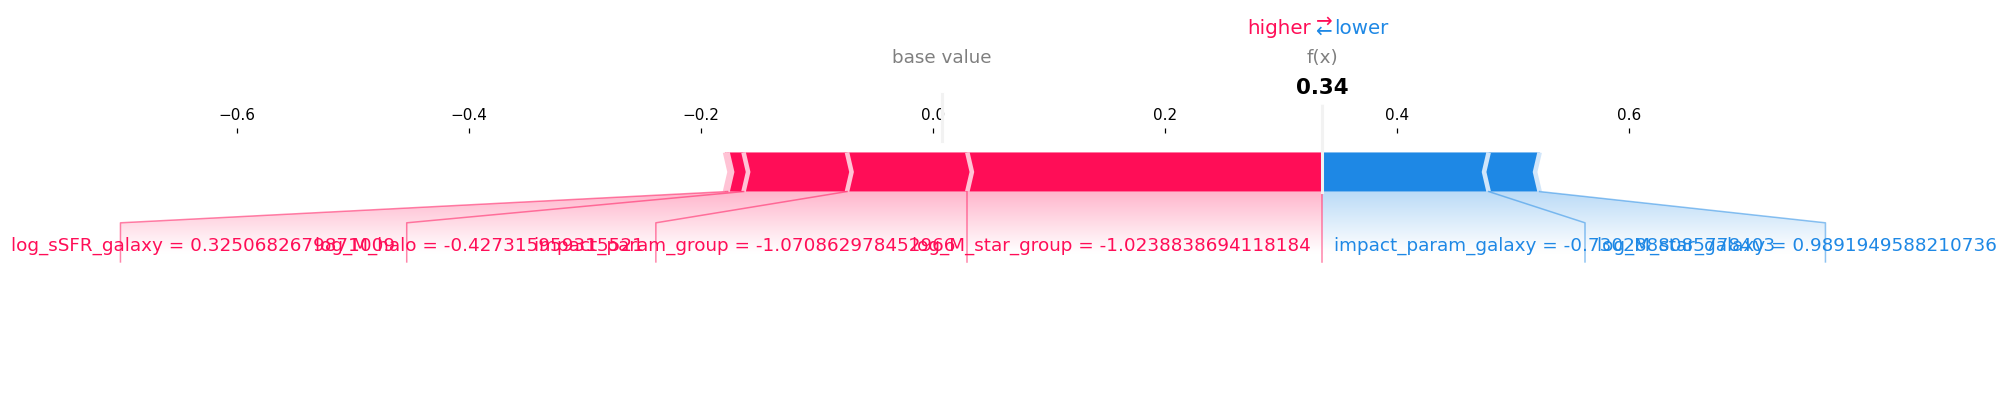

In [59]:
# %% [markdown]
# ## 10. Feature Importance & SHAP

import shap

# 10a. Built-in importance
xgb.plot_importance(final_clf, max_num_features=10, importance_type="gain")
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

# 10b. SHAP analysis
explainer = shap.TreeExplainer(final_clf)
shap_values = explainer.shap_values(X_test)

# Summary beeswarm
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary Plot")
plt.show()

# Dependence for top features
for feat in ["impact_param_galaxy", "log_sSFR_galaxy", "log_M_halo"]:
    shap.dependence_plot(feat, shap_values, X_test, interaction_index=None, show=False)
    plt.title(f"SHAP Dependence: {feat}")
    plt.show()

# Individual explanation for two examples
for idx in [0, 1]:
    shap.force_plot(
        explainer.expected_value,
        shap_values[idx, :],
        X_test.iloc[idx, :],
        matplotlib=True
    )

### Trial Run - 2 (Gemini 2.5 Pro)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Loading and preprocessing real data...
Imputing missing values...
Scaling features...
Data loading and preprocessing complete.
Dataset shape: (1199446, 8)
Target distribution:
has_OVI_absorber
0    0.793444
1    0.206556
Name: proportion, dtype: float64

Performing stratified data splitting...
Train shapes: X-(719667, 8), y-(719667,)
Validation shapes: X-(239889, 8), y-(239889,)
Test shapes: X-(239890, 8), y-(239890,)

Starting hyperparameter optimization with Optuna...
Calculated scale_pos_weight: 3.84


/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_87049/3683983320.py:153: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandb_callback = WandbCallback(


[I 2025-07-08 16:34:04,383] A new study created in memory with name: no-name-00a77152-9d37-424b-aeaa-b4ec277082ac
Best trial: 0. Best value: 0.828982:   1%|          | 1/100 [00:08<14:45,  8.94s/it]

[I 2025-07-08 16:34:13,324] Trial 0 finished with value: 0.8289824500233529 and parameters: {'learning_rate': 0.11473632875095627, 'max_depth': 8, 'subsample': 0.9648499580666704, 'colsample_bytree': 0.8781163670488563, 'gamma': 4.152272458284061, 'reg_alpha': 0.27896715386470095, 'reg_lambda': 1.1503391529197118}. Best is trial 0 with value: 0.8289824500233529.


Best trial: 0. Best value: 0.828982:   2%|▏         | 2/100 [00:11<08:38,  5.29s/it]

[I 2025-07-08 16:34:16,054] Trial 1 finished with value: 0.7886984556403742 and parameters: {'learning_rate': 0.005302390374394375, 'max_depth': 7, 'subsample': 0.5400328648013933, 'colsample_bytree': 0.5066818047914192, 'gamma': 9.432278861714517, 'reg_alpha': 0.006680139956280413, 'reg_lambda': 0.00045681614021019076}. Best is trial 0 with value: 0.8289824500233529.


Best trial: 2. Best value: 0.830262:   3%|▎         | 3/100 [00:46<30:33, 18.90s/it]

[I 2025-07-08 16:34:51,145] Trial 2 finished with value: 0.830262155076023 and parameters: {'learning_rate': 0.0034926000319307404, 'max_depth': 10, 'subsample': 0.9504362206701888, 'colsample_bytree': 0.9599532179986712, 'gamma': 9.128981053446887, 'reg_alpha': 0.07059051903957375, 'reg_lambda': 4.189566198294992e-05}. Best is trial 2 with value: 0.830262155076023.


Best trial: 2. Best value: 0.830262:   4%|▍         | 4/100 [00:48<19:37, 12.27s/it]

[I 2025-07-08 16:34:53,259] Trial 3 finished with value: 0.8134579902895545 and parameters: {'learning_rate': 0.023894091871320636, 'max_depth': 10, 'subsample': 0.7230627160135321, 'colsample_bytree': 0.5104765516917918, 'gamma': 0.512936768941934, 'reg_alpha': 0.007195073638166482, 'reg_lambda': 7.7657532212509635}. Best is trial 2 with value: 0.830262155076023.


Best trial: 4. Best value: 0.83342:   5%|▌         | 5/100 [01:15<27:29, 17.37s/it] 

[I 2025-07-08 16:35:19,660] Trial 4 finished with value: 0.8334199742581546 and parameters: {'learning_rate': 0.05059609220933105, 'max_depth': 8, 'subsample': 0.771052880398619, 'colsample_bytree': 0.9750434729301014, 'gamma': 6.849401234903595, 'reg_alpha': 0.11237148719237965, 'reg_lambda': 0.007920221323020997}. Best is trial 4 with value: 0.8334199742581546.


Best trial: 4. Best value: 0.83342:   6%|▌         | 6/100 [01:18<19:37, 12.53s/it]

[I 2025-07-08 16:35:22,795] Trial 5 finished with value: 0.7634712223502186 and parameters: {'learning_rate': 0.0011918877230429976, 'max_depth': 5, 'subsample': 0.9414771790490268, 'colsample_bytree': 0.9115826929641722, 'gamma': 9.913775190858601, 'reg_alpha': 0.014259405320493234, 'reg_lambda': 0.00424509041989837}. Best is trial 4 with value: 0.8334199742581546.


Best trial: 4. Best value: 0.83342:   7%|▋         | 7/100 [01:45<26:42, 17.23s/it]

[I 2025-07-08 16:35:49,695] Trial 6 finished with value: 0.8034360807907717 and parameters: {'learning_rate': 0.038840388524317405, 'max_depth': 3, 'subsample': 0.7323362040975274, 'colsample_bytree': 0.8803951370403724, 'gamma': 4.1224824927251085, 'reg_alpha': 6.414616188448496e-05, 'reg_lambda': 0.9637915154766341}. Best is trial 4 with value: 0.8334199742581546.


Best trial: 4. Best value: 0.83342:   8%|▊         | 8/100 [02:13<31:59, 20.86s/it]

[I 2025-07-08 16:36:18,325] Trial 7 finished with value: 0.8120189113004808 and parameters: {'learning_rate': 0.01426559277630136, 'max_depth': 5, 'subsample': 0.7197477753612511, 'colsample_bytree': 0.8091005864100309, 'gamma': 1.4412945510212538, 'reg_alpha': 0.00017760723251615952, 'reg_lambda': 0.0002938576280467219}. Best is trial 4 with value: 0.8334199742581546.


Best trial: 4. Best value: 0.83342:   9%|▉         | 9/100 [02:30<29:35, 19.51s/it]

[I 2025-07-08 16:36:34,888] Trial 8 finished with value: 0.816976530095549 and parameters: {'learning_rate': 0.14941427816659256, 'max_depth': 5, 'subsample': 0.8169173995761201, 'colsample_bytree': 0.5294110462599233, 'gamma': 6.252527140271421, 'reg_alpha': 0.025794372014591595, 'reg_lambda': 0.12492752197756314}. Best is trial 4 with value: 0.8334199742581546.


Best trial: 4. Best value: 0.83342:  10%|█         | 10/100 [02:55<32:00, 21.34s/it]

[I 2025-07-08 16:37:00,324] Trial 9 finished with value: 0.8030155342518649 and parameters: {'learning_rate': 0.09462082993189977, 'max_depth': 3, 'subsample': 0.7808830345200508, 'colsample_bytree': 0.7288573671511267, 'gamma': 8.138328563449816, 'reg_alpha': 9.880848783866396e-05, 'reg_lambda': 0.0010203342742444276}. Best is trial 4 with value: 0.8334199742581546.


Best trial: 10. Best value: 0.833867:  11%|█         | 11/100 [03:23<34:27, 23.24s/it]

[I 2025-07-08 16:37:27,853] Trial 10 finished with value: 0.8338674446112395 and parameters: {'learning_rate': 0.05138819278146128, 'max_depth': 8, 'subsample': 0.566049818053928, 'colsample_bytree': 0.6676958611994341, 'gamma': 6.479583266543503, 'reg_alpha': 0.6159439244550104, 'reg_lambda': 0.04074181366964767}. Best is trial 10 with value: 0.8338674446112395.


Best trial: 10. Best value: 0.833867:  12%|█▏        | 12/100 [03:52<36:36, 24.95s/it]

[I 2025-07-08 16:37:56,739] Trial 11 finished with value: 0.8337100078420281 and parameters: {'learning_rate': 0.047398333166543447, 'max_depth': 8, 'subsample': 0.5038811757814351, 'colsample_bytree': 0.6654510472695616, 'gamma': 6.5098637308167255, 'reg_alpha': 0.6266532528095632, 'reg_lambda': 0.04024097687363207}. Best is trial 10 with value: 0.8338674446112395.


Best trial: 12. Best value: 0.83502:  13%|█▎        | 13/100 [04:20<37:38, 25.96s/it] 

[I 2025-07-08 16:38:25,014] Trial 12 finished with value: 0.8350196349177812 and parameters: {'learning_rate': 0.051546003415811906, 'max_depth': 8, 'subsample': 0.5015229037581053, 'colsample_bytree': 0.6546858770873, 'gamma': 6.230121172467855, 'reg_alpha': 0.919662833837941, 'reg_lambda': 0.06259452884658043}. Best is trial 12 with value: 0.8350196349177812.


Best trial: 12. Best value: 0.83502:  14%|█▍        | 14/100 [04:52<39:38, 27.66s/it]

[I 2025-07-08 16:38:56,597] Trial 13 finished with value: 0.8315574023699146 and parameters: {'learning_rate': 0.011258580026321423, 'max_depth': 9, 'subsample': 0.579729575404796, 'colsample_bytree': 0.633963935259362, 'gamma': 5.06683126633543, 'reg_alpha': 0.9048626720096056, 'reg_lambda': 0.0755832161855525}. Best is trial 12 with value: 0.8350196349177812.


Best trial: 14. Best value: 0.837893:  15%|█▌        | 15/100 [05:21<40:00, 28.24s/it]

[I 2025-07-08 16:39:26,193] Trial 14 finished with value: 0.837893272574072 and parameters: {'learning_rate': 0.07126734915577991, 'max_depth': 7, 'subsample': 0.635499021849495, 'colsample_bytree': 0.6298394513833468, 'gamma': 2.6442350689162124, 'reg_alpha': 0.0012432284978151492, 'reg_lambda': 0.4342348708566204}. Best is trial 14 with value: 0.837893272574072.


Best trial: 14. Best value: 0.837893:  16%|█▌        | 16/100 [05:51<40:07, 28.65s/it]

[I 2025-07-08 16:39:55,804] Trial 15 finished with value: 0.8346163514861893 and parameters: {'learning_rate': 0.1739908871203379, 'max_depth': 6, 'subsample': 0.6338457561358568, 'colsample_bytree': 0.5863595436006234, 'gamma': 2.3145180092249786, 'reg_alpha': 0.0008030745386479675, 'reg_lambda': 0.696742579955494}. Best is trial 14 with value: 0.837893272574072.


Best trial: 14. Best value: 0.837893:  17%|█▋        | 17/100 [06:21<40:19, 29.15s/it]

[I 2025-07-08 16:40:26,122] Trial 16 finished with value: 0.8282419954849373 and parameters: {'learning_rate': 0.022004437521872693, 'max_depth': 7, 'subsample': 0.6256431818475726, 'colsample_bytree': 0.7406373518922659, 'gamma': 2.9453554577121057, 'reg_alpha': 0.0012233817262428928, 'reg_lambda': 8.220134394731259}. Best is trial 14 with value: 0.837893272574072.


Best trial: 14. Best value: 0.837893:  18%|█▊        | 18/100 [06:49<39:28, 28.88s/it]

[I 2025-07-08 16:40:54,360] Trial 17 finished with value: 0.8297479984050339 and parameters: {'learning_rate': 0.07959485572041446, 'max_depth': 6, 'subsample': 0.6580092052554938, 'colsample_bytree': 0.5888425024756436, 'gamma': 3.2688893590835146, 'reg_alpha': 0.0004625694877781693, 'reg_lambda': 0.37703611550203114}. Best is trial 14 with value: 0.837893272574072.


Best trial: 14. Best value: 0.837893:  19%|█▉        | 19/100 [07:17<38:23, 28.44s/it]

[I 2025-07-08 16:41:21,788] Trial 18 finished with value: 0.8325639465967645 and parameters: {'learning_rate': 0.024525251833217982, 'max_depth': 9, 'subsample': 0.8706512753625177, 'colsample_bytree': 0.8141389563384116, 'gamma': 5.292902568038693, 'reg_alpha': 1.2450481112082923e-05, 'reg_lambda': 0.02101444534063989}. Best is trial 14 with value: 0.837893272574072.


Best trial: 14. Best value: 0.837893:  20%|██        | 20/100 [07:51<40:04, 30.06s/it]

[I 2025-07-08 16:41:55,604] Trial 19 finished with value: 0.8272203620828437 and parameters: {'learning_rate': 0.007737523492113905, 'max_depth': 9, 'subsample': 0.5072826859650348, 'colsample_bytree': 0.7135946290287066, 'gamma': 7.864278906317663, 'reg_alpha': 0.001667534729846379, 'reg_lambda': 0.19313498709772395}. Best is trial 14 with value: 0.837893272574072.


Best trial: 14. Best value: 0.837893:  21%|██        | 21/100 [08:22<39:52, 30.29s/it]

[I 2025-07-08 16:42:26,426] Trial 20 finished with value: 0.8345193597409019 and parameters: {'learning_rate': 0.07257327742993466, 'max_depth': 7, 'subsample': 0.6708793556759091, 'colsample_bytree': 0.5971022328756361, 'gamma': 0.30091235110192516, 'reg_alpha': 0.04438346531059912, 'reg_lambda': 0.0031237124542587823}. Best is trial 14 with value: 0.837893272574072.


Best trial: 14. Best value: 0.837893:  22%|██▏       | 22/100 [08:51<38:57, 29.97s/it]

[I 2025-07-08 16:42:55,647] Trial 21 finished with value: 0.8347141526641173 and parameters: {'learning_rate': 0.1750662442252876, 'max_depth': 6, 'subsample': 0.6125823347573534, 'colsample_bytree': 0.5751619728709584, 'gamma': 2.0583160023597786, 'reg_alpha': 0.0007481943978873, 'reg_lambda': 1.411122452603118}. Best is trial 14 with value: 0.837893272574072.


Best trial: 14. Best value: 0.837893:  23%|██▎       | 23/100 [09:20<38:08, 29.73s/it]

[I 2025-07-08 16:43:24,811] Trial 22 finished with value: 0.8340911574154625 and parameters: {'learning_rate': 0.16545150988802892, 'max_depth': 6, 'subsample': 0.5938599289696872, 'colsample_bytree': 0.5644226843398463, 'gamma': 1.60705115919845, 'reg_alpha': 0.003639729324678919, 'reg_lambda': 5.920704429524327}. Best is trial 14 with value: 0.837893272574072.


Best trial: 23. Best value: 0.838116:  24%|██▍       | 24/100 [09:49<37:22, 29.50s/it]

[I 2025-07-08 16:43:53,800] Trial 23 finished with value: 0.8381159565166719 and parameters: {'learning_rate': 0.10378819329878934, 'max_depth': 7, 'subsample': 0.5408908726202966, 'colsample_bytree': 0.6440485344323326, 'gamma': 4.012343701093652, 'reg_alpha': 0.00034409672931979494, 'reg_lambda': 2.1520788968643028}. Best is trial 23 with value: 0.8381159565166719.


Best trial: 23. Best value: 0.838116:  25%|██▌       | 25/100 [10:20<37:21, 29.88s/it]

[I 2025-07-08 16:44:24,565] Trial 24 finished with value: 0.8316543313984865 and parameters: {'learning_rate': 0.03298347348505692, 'max_depth': 7, 'subsample': 0.5440529657317713, 'colsample_bytree': 0.6816842236055145, 'gamma': 3.9397398947516615, 'reg_alpha': 0.000252806858352766, 'reg_lambda': 2.3721138129898196}. Best is trial 23 with value: 0.8381159565166719.


Best trial: 23. Best value: 0.838116:  26%|██▌       | 26/100 [10:47<35:49, 29.04s/it]

[I 2025-07-08 16:44:51,651] Trial 25 finished with value: 0.8157229554349387 and parameters: {'learning_rate': 0.06556956606929454, 'max_depth': 4, 'subsample': 0.6841512420754812, 'colsample_bytree': 0.6330310927747066, 'gamma': 5.133119508981098, 'reg_alpha': 2.1287948164362198e-05, 'reg_lambda': 0.28296637030452626}. Best is trial 23 with value: 0.8381159565166719.


Best trial: 26. Best value: 0.842023:  27%|██▋       | 27/100 [11:17<35:55, 29.53s/it]

[I 2025-07-08 16:45:22,311] Trial 26 finished with value: 0.8420231462427261 and parameters: {'learning_rate': 0.10815596947839096, 'max_depth': 8, 'subsample': 0.5300427787615918, 'colsample_bytree': 0.6307595549898977, 'gamma': 3.1433500674311725, 'reg_alpha': 4.191559151010247e-05, 'reg_lambda': 2.70095959227169}. Best is trial 26 with value: 0.8420231462427261.


Best trial: 27. Best value: 0.846036:  28%|██▊       | 28/100 [11:49<36:13, 30.19s/it]

[I 2025-07-08 16:45:54,032] Trial 27 finished with value: 0.8460358825285486 and parameters: {'learning_rate': 0.10195991874640395, 'max_depth': 9, 'subsample': 0.5489058595011069, 'colsample_bytree': 0.7881865857399235, 'gamma': 3.171617183619434, 'reg_alpha': 3.951958209560971e-05, 'reg_lambda': 2.9848307811134176}. Best is trial 27 with value: 0.8460358825285486.


Best trial: 27. Best value: 0.846036:  29%|██▉       | 29/100 [12:22<36:39, 30.98s/it]

[I 2025-07-08 16:46:26,871] Trial 28 finished with value: 0.8460173437218863 and parameters: {'learning_rate': 0.12132573433239772, 'max_depth': 9, 'subsample': 0.563384507755125, 'colsample_bytree': 0.7925307511702616, 'gamma': 3.585352736647938, 'reg_alpha': 3.635590138005189e-05, 'reg_lambda': 2.3743616027367476}. Best is trial 27 with value: 0.8460358825285486.


Best trial: 29. Best value: 0.846502:  30%|███       | 30/100 [12:53<36:14, 31.07s/it]

[I 2025-07-08 16:46:58,140] Trial 29 finished with value: 0.8465021736219337 and parameters: {'learning_rate': 0.1225963185466397, 'max_depth': 9, 'subsample': 0.574310071783506, 'colsample_bytree': 0.7889100122010083, 'gamma': 3.4849461990969925, 'reg_alpha': 3.5614310528935446e-05, 'reg_lambda': 2.7084161763997363}. Best is trial 29 with value: 0.8465021736219337.


Best trial: 30. Best value: 0.846689:  31%|███       | 31/100 [13:21<34:39, 30.14s/it]

[I 2025-07-08 16:47:26,110] Trial 30 finished with value: 0.8466887020936871 and parameters: {'learning_rate': 0.11816857074462246, 'max_depth': 10, 'subsample': 0.5742264370819028, 'colsample_bytree': 0.7885990682659241, 'gamma': 3.6126304116752506, 'reg_alpha': 2.511308820242547e-05, 'reg_lambda': 1.1362604171516784e-05}. Best is trial 30 with value: 0.8466887020936871.


Best trial: 31. Best value: 0.84674:  32%|███▏      | 32/100 [13:47<32:33, 28.72s/it] 

[I 2025-07-08 16:47:51,526] Trial 31 finished with value: 0.8467402682756019 and parameters: {'learning_rate': 0.12733202454594672, 'max_depth': 10, 'subsample': 0.5854456359174731, 'colsample_bytree': 0.7919452611785345, 'gamma': 3.6718253721109058, 'reg_alpha': 2.8618069807324515e-05, 'reg_lambda': 4.130272403671992e-05}. Best is trial 31 with value: 0.8467402682756019.


Best trial: 31. Best value: 0.84674:  33%|███▎      | 33/100 [14:16<32:17, 28.91s/it]

[I 2025-07-08 16:48:20,887] Trial 32 finished with value: 0.8464424398469164 and parameters: {'learning_rate': 0.12253547470449229, 'max_depth': 10, 'subsample': 0.5969263874757501, 'colsample_bytree': 0.7760608411711677, 'gamma': 4.592098222008366, 'reg_alpha': 1.3053781184139118e-05, 'reg_lambda': 1.2644663080541229e-05}. Best is trial 31 with value: 0.8467402682756019.


Best trial: 31. Best value: 0.84674:  34%|███▍      | 34/100 [14:49<33:08, 30.13s/it]

[I 2025-07-08 16:48:53,852] Trial 33 finished with value: 0.846265234323619 and parameters: {'learning_rate': 0.13329210790380241, 'max_depth': 10, 'subsample': 0.5952642414188561, 'colsample_bytree': 0.8415750421475207, 'gamma': 4.700834782016286, 'reg_alpha': 1.526594020812662e-05, 'reg_lambda': 1.085601251516478e-05}. Best is trial 31 with value: 0.8467402682756019.


Best trial: 31. Best value: 0.84674:  35%|███▌      | 35/100 [14:52<23:48, 21.97s/it]

[I 2025-07-08 16:48:56,798] Trial 34 finished with value: 0.8195156974929256 and parameters: {'learning_rate': 0.0022650043887228067, 'max_depth': 10, 'subsample': 0.5955406188982775, 'colsample_bytree': 0.7610925332526425, 'gamma': 4.6189288140451445, 'reg_alpha': 1.1152664254739537e-05, 'reg_lambda': 7.591149844789107e-05}. Best is trial 31 with value: 0.8467402682756019.


Best trial: 31. Best value: 0.84674:  36%|███▌      | 36/100 [15:16<24:04, 22.58s/it]

[I 2025-07-08 16:49:20,780] Trial 35 finished with value: 0.843320388437118 and parameters: {'learning_rate': 0.12892825889774925, 'max_depth': 10, 'subsample': 0.6956497794455172, 'colsample_bytree': 0.8528820072038731, 'gamma': 5.529251011139806, 'reg_alpha': 0.00011140293107502023, 'reg_lambda': 1.7079422655288135e-05}. Best is trial 31 with value: 0.8467402682756019.


Best trial: 31. Best value: 0.84674:  37%|███▋      | 37/100 [15:29<20:48, 19.82s/it]

[I 2025-07-08 16:49:34,162] Trial 36 finished with value: 0.8370918843727062 and parameters: {'learning_rate': 0.030909449284355666, 'max_depth': 10, 'subsample': 0.9964077302637948, 'colsample_bytree': 0.7621007949084965, 'gamma': 1.1647552707975866, 'reg_alpha': 2.194019729657034e-05, 'reg_lambda': 5.1247493157590596e-05}. Best is trial 31 with value: 0.8467402682756019.


Best trial: 31. Best value: 0.84674:  38%|███▊      | 38/100 [15:49<20:29, 19.82s/it]

[I 2025-07-08 16:49:53,995] Trial 37 finished with value: 0.8437472259980519 and parameters: {'learning_rate': 0.18070975643165196, 'max_depth': 10, 'subsample': 0.6550200827982553, 'colsample_bytree': 0.7030336794314628, 'gamma': 4.498158947462161, 'reg_alpha': 7.644334798683195e-05, 'reg_lambda': 0.0002502208761061029}. Best is trial 31 with value: 0.8467402682756019.


Best trial: 31. Best value: 0.84674:  39%|███▉      | 39/100 [16:17<22:37, 22.25s/it]

[I 2025-07-08 16:50:21,914] Trial 38 finished with value: 0.8433613837510766 and parameters: {'learning_rate': 0.07835435783843755, 'max_depth': 9, 'subsample': 0.6111582459707151, 'colsample_bytree': 0.926774792085786, 'gamma': 5.843906418105297, 'reg_alpha': 0.00016239710438471663, 'reg_lambda': 2.3266440514732738e-05}. Best is trial 31 with value: 0.8467402682756019.


Best trial: 31. Best value: 0.84674:  40%|████      | 40/100 [16:20<16:24, 16.40s/it]

[I 2025-07-08 16:50:24,678] Trial 39 finished with value: 0.8193141553392529 and parameters: {'learning_rate': 0.0026418883132391475, 'max_depth': 10, 'subsample': 0.7047371035353909, 'colsample_bytree': 0.8312345225397328, 'gamma': 3.758526328815042, 'reg_alpha': 2.477999398240692e-05, 'reg_lambda': 0.0001002273224522218}. Best is trial 31 with value: 0.8467402682756019.


Best trial: 40. Best value: 0.848422:  41%|████      | 41/100 [16:52<20:42, 21.05s/it]

[I 2025-07-08 16:50:56,569] Trial 40 finished with value: 0.8484217773769823 and parameters: {'learning_rate': 0.05946784540626768, 'max_depth': 10, 'subsample': 0.767121569923539, 'colsample_bytree': 0.8760152516200531, 'gamma': 2.4916547510184452, 'reg_alpha': 5.1463365884032976e-05, 'reg_lambda': 0.00014403477455965545}. Best is trial 40 with value: 0.8484217773769823.


Best trial: 40. Best value: 0.848422:  42%|████▏     | 42/100 [17:19<22:04, 22.83s/it]

[I 2025-07-08 16:51:23,567] Trial 41 finished with value: 0.8470995847978477 and parameters: {'learning_rate': 0.09077462203840976, 'max_depth': 10, 'subsample': 0.8648495516543047, 'colsample_bytree': 0.898302723927318, 'gamma': 2.5111373337845553, 'reg_alpha': 5.379571391254727e-05, 'reg_lambda': 0.0001542805367522482}. Best is trial 40 with value: 0.8484217773769823.


Best trial: 40. Best value: 0.848422:  43%|████▎     | 43/100 [17:41<21:34, 22.70s/it]

[I 2025-07-08 16:51:45,966] Trial 42 finished with value: 0.8466509869222713 and parameters: {'learning_rate': 0.19511511040907228, 'max_depth': 9, 'subsample': 0.8535503498197807, 'colsample_bytree': 0.8858403849561697, 'gamma': 2.0671318010883493, 'reg_alpha': 6.226254733222235e-05, 'reg_lambda': 0.00016479222139116487}. Best is trial 40 with value: 0.8484217773769823.


Best trial: 40. Best value: 0.848422:  44%|████▍     | 44/100 [17:50<17:23, 18.63s/it]

[I 2025-07-08 16:51:55,092] Trial 43 finished with value: 0.8467135478798837 and parameters: {'learning_rate': 0.19939535473946643, 'max_depth': 10, 'subsample': 0.8709218180298159, 'colsample_bytree': 0.8962964664950124, 'gamma': 1.0336447187743578, 'reg_alpha': 7.512060551644776e-05, 'reg_lambda': 0.0006284493017285271}. Best is trial 40 with value: 0.8484217773769823.


Best trial: 44. Best value: 0.848696:  45%|████▌     | 45/100 [18:15<18:38, 20.34s/it]

[I 2025-07-08 16:52:19,405] Trial 44 finished with value: 0.8486956238984914 and parameters: {'learning_rate': 0.05626587942708749, 'max_depth': 10, 'subsample': 0.9026415617139856, 'colsample_bytree': 0.9485973474243419, 'gamma': 0.8283848653965158, 'reg_alpha': 0.00014122741259131187, 'reg_lambda': 0.000768386491154334}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  46%|████▌     | 46/100 [18:40<19:44, 21.94s/it]

[I 2025-07-08 16:52:45,089] Trial 45 finished with value: 0.8485046671918931 and parameters: {'learning_rate': 0.06173110155892124, 'max_depth': 10, 'subsample': 0.9146514983614159, 'colsample_bytree': 0.994082175396337, 'gamma': 0.7462264685765971, 'reg_alpha': 0.00012641362602409215, 'reg_lambda': 0.0007975449821047867}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  47%|████▋     | 47/100 [19:13<22:08, 25.06s/it]

[I 2025-07-08 16:53:17,426] Trial 46 finished with value: 0.8474828309014896 and parameters: {'learning_rate': 0.055662469133510466, 'max_depth': 9, 'subsample': 0.9336042327726364, 'colsample_bytree': 0.983762366594352, 'gamma': 0.21445289458409889, 'reg_alpha': 0.00016747262822642417, 'reg_lambda': 0.0017810660759545482}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  48%|████▊     | 48/100 [19:45<23:45, 27.42s/it]

[I 2025-07-08 16:53:50,352] Trial 47 finished with value: 0.8472279517597019 and parameters: {'learning_rate': 0.0446077388767117, 'max_depth': 9, 'subsample': 0.9318688223484002, 'colsample_bytree': 0.9828162708952977, 'gamma': 0.02632533233124762, 'reg_alpha': 0.00016686688067386128, 'reg_lambda': 0.0019302799780732606}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  49%|████▉     | 49/100 [20:17<24:14, 28.53s/it]

[I 2025-07-08 16:54:21,466] Trial 48 finished with value: 0.844898318364458 and parameters: {'learning_rate': 0.043460264103482193, 'max_depth': 8, 'subsample': 0.911910953171798, 'colsample_bytree': 0.9964530492803462, 'gamma': 0.14660731805433758, 'reg_alpha': 0.00018429914643920824, 'reg_lambda': 0.0018208580455254535}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  50%|█████     | 50/100 [20:51<25:07, 30.15s/it]

[I 2025-07-08 16:54:55,412] Trial 49 finished with value: 0.8431192002644344 and parameters: {'learning_rate': 0.01714709791548821, 'max_depth': 9, 'subsample': 0.9303064007295964, 'colsample_bytree': 0.9526981906931796, 'gamma': 0.7505458293234777, 'reg_alpha': 0.00041998126258576676, 'reg_lambda': 0.009901037069238481}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  51%|█████     | 51/100 [21:17<23:36, 28.90s/it]

[I 2025-07-08 16:55:21,397] Trial 50 finished with value: 0.8472211590039501 and parameters: {'learning_rate': 0.05843693363662667, 'max_depth': 9, 'subsample': 0.9020258645250402, 'colsample_bytree': 0.9462523565961659, 'gamma': 0.0020325021788275277, 'reg_alpha': 0.00012537150429463994, 'reg_lambda': 0.0011657167396466866}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  52%|█████▏    | 52/100 [21:43<22:34, 28.21s/it]

[I 2025-07-08 16:55:47,988] Trial 51 finished with value: 0.8470663044881487 and parameters: {'learning_rate': 0.0586666264946085, 'max_depth': 9, 'subsample': 0.905366960400027, 'colsample_bytree': 0.9470816779432807, 'gamma': 0.037444347986511216, 'reg_alpha': 0.00012527590271960108, 'reg_lambda': 0.0009393185869562882}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  53%|█████▎    | 53/100 [22:14<22:45, 29.05s/it]

[I 2025-07-08 16:56:18,999] Trial 52 finished with value: 0.8432237400698247 and parameters: {'learning_rate': 0.03734222982927161, 'max_depth': 8, 'subsample': 0.9650252762819673, 'colsample_bytree': 0.9828896224463315, 'gamma': 0.6702711271204624, 'reg_alpha': 0.0002145636078296648, 'reg_lambda': 0.0037656720586105303}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  54%|█████▍    | 54/100 [22:46<22:52, 29.83s/it]

[I 2025-07-08 16:56:50,633] Trial 53 finished with value: 0.8473994953896826 and parameters: {'learning_rate': 0.059279103731620944, 'max_depth': 9, 'subsample': 0.8206077660502148, 'colsample_bytree': 0.9266279832651583, 'gamma': 1.7549367407736105, 'reg_alpha': 0.0003413845727353681, 'reg_lambda': 0.0015406595935057545}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  55%|█████▌    | 55/100 [23:20<23:28, 31.30s/it]

[I 2025-07-08 16:57:25,364] Trial 54 finished with value: 0.8451601877427797 and parameters: {'learning_rate': 0.02527592605582008, 'max_depth': 9, 'subsample': 0.7965939216323483, 'colsample_bytree': 0.921654090742524, 'gamma': 1.5475057644074017, 'reg_alpha': 0.0006475710236762833, 'reg_lambda': 0.000334251163087152}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  56%|█████▌    | 56/100 [23:49<22:19, 30.43s/it]

[I 2025-07-08 16:57:53,787] Trial 55 finished with value: 0.8476901402892345 and parameters: {'learning_rate': 0.043816799369514034, 'max_depth': 10, 'subsample': 0.751242917578522, 'colsample_bytree': 0.9755133584025005, 'gamma': 1.0573595606644142, 'reg_alpha': 0.0002746969466885799, 'reg_lambda': 0.002210742101870349}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  57%|█████▋    | 57/100 [24:22<22:20, 31.17s/it]

[I 2025-07-08 16:58:26,667] Trial 56 finished with value: 0.8478487992126681 and parameters: {'learning_rate': 0.02995497240570651, 'max_depth': 10, 'subsample': 0.7656553264862856, 'colsample_bytree': 0.9685510918350777, 'gamma': 1.832990270268735, 'reg_alpha': 0.003147747904007185, 'reg_lambda': 0.016432784396624885}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  58%|█████▊    | 58/100 [24:56<22:29, 32.12s/it]

[I 2025-07-08 16:59:01,019] Trial 57 finished with value: 0.8479571566794344 and parameters: {'learning_rate': 0.033834001065700774, 'max_depth': 10, 'subsample': 0.7407838707179959, 'colsample_bytree': 0.9975960831443166, 'gamma': 1.0505136081227386, 'reg_alpha': 0.1379537695565795, 'reg_lambda': 0.006141902470407109}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  59%|█████▉    | 59/100 [25:33<22:59, 33.64s/it]

[I 2025-07-08 16:59:38,204] Trial 58 finished with value: 0.8464723495705249 and parameters: {'learning_rate': 0.01875646952137989, 'max_depth': 10, 'subsample': 0.7567665667760123, 'colsample_bytree': 0.964337275002057, 'gamma': 1.1642377629495106, 'reg_alpha': 0.14565591792926655, 'reg_lambda': 0.005511963971624537}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  60%|██████    | 60/100 [26:08<22:38, 33.96s/it]

[I 2025-07-08 17:00:12,907] Trial 59 finished with value: 0.8476287296505529 and parameters: {'learning_rate': 0.034638902507778645, 'max_depth': 10, 'subsample': 0.7306973314656828, 'colsample_bytree': 0.9665153852208983, 'gamma': 0.8307546742744184, 'reg_alpha': 0.012051090454236333, 'reg_lambda': 0.0005720216066496562}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  61%|██████    | 61/100 [26:36<20:55, 32.20s/it]

[I 2025-07-08 17:00:41,019] Trial 60 finished with value: 0.8125153798430989 and parameters: {'learning_rate': 0.028140088081259212, 'max_depth': 4, 'subsample': 0.7521261018815613, 'colsample_bytree': 0.9979315700120018, 'gamma': 1.9374784832770893, 'reg_alpha': 0.0033389029345292447, 'reg_lambda': 0.01447231287351334}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  62%|██████▏   | 62/100 [27:12<21:03, 33.26s/it]

[I 2025-07-08 17:01:16,724] Trial 61 finished with value: 0.8474689999306513 and parameters: {'learning_rate': 0.03660044230582986, 'max_depth': 10, 'subsample': 0.7173574676900708, 'colsample_bytree': 0.9662445490432542, 'gamma': 0.6921799418320418, 'reg_alpha': 0.01830886380394623, 'reg_lambda': 0.0005802747186549922}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  63%|██████▎   | 63/100 [27:49<21:09, 34.31s/it]

[I 2025-07-08 17:01:53,501] Trial 62 finished with value: 0.8440764751301529 and parameters: {'learning_rate': 0.011640006025757387, 'max_depth': 10, 'subsample': 0.734668754421513, 'colsample_bytree': 0.9386098593910286, 'gamma': 1.3051764442349822, 'reg_alpha': 0.0085800536042199, 'reg_lambda': 0.021278570159073203}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  64%|██████▍   | 64/100 [28:18<19:37, 32.71s/it]

[I 2025-07-08 17:02:22,481] Trial 63 finished with value: 0.8479681477440837 and parameters: {'learning_rate': 0.043966532462812194, 'max_depth': 10, 'subsample': 0.7754286440047747, 'colsample_bytree': 0.971958929254989, 'gamma': 0.9193058226676261, 'reg_alpha': 0.04057081451155126, 'reg_lambda': 0.0006843957603635423}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  65%|██████▌   | 65/100 [28:44<18:02, 30.94s/it]

[I 2025-07-08 17:02:49,271] Trial 64 finished with value: 0.8479493045784491 and parameters: {'learning_rate': 0.044988488882288, 'max_depth': 10, 'subsample': 0.7793704138008204, 'colsample_bytree': 0.9122059537413174, 'gamma': 0.45228610916001305, 'reg_alpha': 0.2620742363192296, 'reg_lambda': 0.0070832061526445575}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  66%|██████▌   | 66/100 [29:02<15:17, 26.98s/it]

[I 2025-07-08 17:03:07,011] Trial 65 finished with value: 0.8463919816779821 and parameters: {'learning_rate': 0.08283900021459169, 'max_depth': 10, 'subsample': 0.7813320763022903, 'colsample_bytree': 0.8720206731988316, 'gamma': 0.384539192095386, 'reg_alpha': 0.10214195443214369, 'reg_lambda': 0.0065061674028360095}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  67%|██████▋   | 67/100 [29:33<15:25, 28.05s/it]

[I 2025-07-08 17:03:37,562] Trial 66 finished with value: 0.8467155947880745 and parameters: {'learning_rate': 0.04846667111332016, 'max_depth': 10, 'subsample': 0.8180938091720574, 'colsample_bytree': 0.9092111946680529, 'gamma': 2.786060667693186, 'reg_alpha': 0.3365322393193097, 'reg_lambda': 0.042418645718884034}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  68%|██████▊   | 68/100 [30:05<15:41, 29.43s/it]

[I 2025-07-08 17:04:10,215] Trial 67 finished with value: 0.8471746886744622 and parameters: {'learning_rate': 0.027486296640312408, 'max_depth': 10, 'subsample': 0.7996007596947559, 'colsample_bytree': 0.9995481238500361, 'gamma': 2.292764361102492, 'reg_alpha': 0.271414777355188, 'reg_lambda': 0.016865175545403156}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  69%|██████▉   | 69/100 [30:39<15:54, 30.80s/it]

[I 2025-07-08 17:04:44,217] Trial 68 finished with value: 0.8468616324893877 and parameters: {'learning_rate': 0.02144447921464427, 'max_depth': 10, 'subsample': 0.8409764507981866, 'colsample_bytree': 0.9372212578770409, 'gamma': 1.5085556845520198, 'reg_alpha': 0.03677557902020989, 'reg_lambda': 0.08818643227955011}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  70%|███████   | 70/100 [31:08<15:04, 30.14s/it]

[I 2025-07-08 17:05:12,809] Trial 69 finished with value: 0.8484508228504658 and parameters: {'learning_rate': 0.06775872602136096, 'max_depth': 10, 'subsample': 0.7685596420183263, 'colsample_bytree': 0.913243574334941, 'gamma': 1.81471419575439, 'reg_alpha': 0.062061786792989716, 'reg_lambda': 0.0027083516637549598}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  71%|███████   | 71/100 [31:29<13:16, 27.47s/it]

[I 2025-07-08 17:05:34,060] Trial 70 finished with value: 0.8474065270839273 and parameters: {'learning_rate': 0.06457861628634604, 'max_depth': 10, 'subsample': 0.7825706241421398, 'colsample_bytree': 0.9117062767540819, 'gamma': 0.4894653827296622, 'reg_alpha': 0.056206630221756156, 'reg_lambda': 0.003225270317139822}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  72%|███████▏  | 72/100 [31:59<13:04, 28.03s/it]

[I 2025-07-08 17:06:03,391] Trial 71 finished with value: 0.8478662399201501 and parameters: {'learning_rate': 0.0702318009789407, 'max_depth': 10, 'subsample': 0.762481435523196, 'colsample_bytree': 0.8704411638542482, 'gamma': 1.7691725990836276, 'reg_alpha': 0.22581296437908052, 'reg_lambda': 0.005194412842842879}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  73%|███████▎  | 73/100 [32:24<12:15, 27.25s/it]

[I 2025-07-08 17:06:28,831] Trial 72 finished with value: 0.8485364949973029 and parameters: {'learning_rate': 0.08999060263258446, 'max_depth': 10, 'subsample': 0.7364786280321539, 'colsample_bytree': 0.8764808966386708, 'gamma': 2.263816222003207, 'reg_alpha': 0.19828512302279766, 'reg_lambda': 0.004939032878379142}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 73. Best value: 0.848872:  74%|███████▍  | 74/100 [32:48<11:24, 26.34s/it]

[I 2025-07-08 17:06:53,033] Trial 73 finished with value: 0.848872433399924 and parameters: {'learning_rate': 0.08725916211787774, 'max_depth': 10, 'subsample': 0.7353869522115165, 'colsample_bytree': 0.952726167198137, 'gamma': 2.1956139583625154, 'reg_alpha': 0.45107323952030576, 'reg_lambda': 0.0008579915423895842}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  75%|███████▌  | 75/100 [33:21<11:50, 28.41s/it]

[I 2025-07-08 17:07:26,265] Trial 74 finished with value: 0.8479985406461759 and parameters: {'learning_rate': 0.08931790214315552, 'max_depth': 10, 'subsample': 0.7352629570696626, 'colsample_bytree': 0.8575107896244804, 'gamma': 2.2573084962733043, 'reg_alpha': 0.47920287314358034, 'reg_lambda': 0.00040705703794252207}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  76%|███████▌  | 76/100 [33:54<11:52, 29.70s/it]

[I 2025-07-08 17:07:58,985] Trial 75 finished with value: 0.8468227835397132 and parameters: {'learning_rate': 0.0922412374356939, 'max_depth': 9, 'subsample': 0.7162763869712536, 'colsample_bytree': 0.8171753465770265, 'gamma': 2.345846879398723, 'reg_alpha': 0.45537565718291606, 'reg_lambda': 0.0003320951978976093}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  77%|███████▋  | 77/100 [34:18<10:40, 27.86s/it]

[I 2025-07-08 17:08:22,563] Trial 76 finished with value: 0.8476086118988857 and parameters: {'learning_rate': 0.14611647853966592, 'max_depth': 10, 'subsample': 0.7987014254686491, 'colsample_bytree': 0.861430567644698, 'gamma': 2.8078451337929633, 'reg_alpha': 0.725261438358098, 'reg_lambda': 0.0008356735541538671}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  78%|███████▊  | 78/100 [34:48<10:30, 28.67s/it]

[I 2025-07-08 17:08:53,107] Trial 77 finished with value: 0.8477959755155426 and parameters: {'learning_rate': 0.08806418298700419, 'max_depth': 9, 'subsample': 0.680452447129759, 'colsample_bytree': 0.8966372377969154, 'gamma': 2.2826624695784643, 'reg_alpha': 0.4512195020664882, 'reg_lambda': 0.0002457679737696271}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  79%|███████▉  | 79/100 [34:53<07:29, 21.39s/it]

[I 2025-07-08 17:08:57,501] Trial 78 finished with value: 0.8350819442133066 and parameters: {'learning_rate': 0.07458592629506419, 'max_depth': 10, 'subsample': 0.8815084956692584, 'colsample_bytree': 0.8851452204614391, 'gamma': 8.02307611433315, 'reg_alpha': 0.07088039055182938, 'reg_lambda': 0.00015121594317867764}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  80%|████████  | 80/100 [35:22<07:56, 23.80s/it]

[I 2025-07-08 17:09:26,936] Trial 79 finished with value: 0.829204217920197 and parameters: {'learning_rate': 0.0668447902136934, 'max_depth': 5, 'subsample': 0.8346299564083055, 'colsample_bytree': 0.9511838051927048, 'gamma': 3.0449994706111223, 'reg_alpha': 0.0938666142719216, 'reg_lambda': 0.0004171913030383768}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  81%|████████  | 81/100 [35:42<07:07, 22.51s/it]

[I 2025-07-08 17:09:46,429] Trial 80 finished with value: 0.8464258759010935 and parameters: {'learning_rate': 0.10176895644842694, 'max_depth': 10, 'subsample': 0.7028639795093485, 'colsample_bytree': 0.8466771750855108, 'gamma': 1.394862561149944, 'reg_alpha': 0.2059115519977718, 'reg_lambda': 0.0011753788617632221}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  82%|████████▏ | 82/100 [36:00<06:25, 21.39s/it]

[I 2025-07-08 17:10:05,215] Trial 81 finished with value: 0.8474638077500143 and parameters: {'learning_rate': 0.0803676218239829, 'max_depth': 10, 'subsample': 0.742519062444583, 'colsample_bytree': 0.9308216274113386, 'gamma': 0.9243012281250147, 'reg_alpha': 0.16422582440335956, 'reg_lambda': 0.0006943889748763886}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  83%|████████▎ | 83/100 [36:34<07:04, 24.95s/it]

[I 2025-07-08 17:10:38,461] Trial 82 finished with value: 0.8487002442596061 and parameters: {'learning_rate': 0.040767256678267576, 'max_depth': 10, 'subsample': 0.7402523440480314, 'colsample_bytree': 0.9819973521929044, 'gamma': 2.1308381573898316, 'reg_alpha': 0.4180298240983202, 'reg_lambda': 0.002553519147601707}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  84%|████████▍ | 84/100 [36:37<04:53, 18.37s/it]

[I 2025-07-08 17:10:41,490] Trial 83 finished with value: 0.8193589980559886 and parameters: {'learning_rate': 0.0010613741363897362, 'max_depth': 10, 'subsample': 0.7197154933066288, 'colsample_bytree': 0.8328490082450538, 'gamma': 2.632166937711916, 'reg_alpha': 0.3732685496361442, 'reg_lambda': 0.0024921711537642336}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  85%|████████▌ | 85/100 [36:43<03:42, 14.80s/it]

[I 2025-07-08 17:10:47,962] Trial 84 finished with value: 0.8290590516790455 and parameters: {'learning_rate': 0.05286965779648818, 'max_depth': 9, 'subsample': 0.956374816475845, 'colsample_bytree': 0.9529979802276557, 'gamma': 9.039240730714273, 'reg_alpha': 0.5960175427421855, 'reg_lambda': 0.00019741414732807317}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  86%|████████▌ | 86/100 [37:00<03:36, 15.44s/it]

[I 2025-07-08 17:11:04,904] Trial 85 finished with value: 0.8487008811285026 and parameters: {'learning_rate': 0.1481999859046506, 'max_depth': 10, 'subsample': 0.7687497594207858, 'colsample_bytree': 0.9820577083433178, 'gamma': 2.0982266801124405, 'reg_alpha': 0.9459342046654842, 'reg_lambda': 0.0011882035675135573}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  87%|████████▋ | 87/100 [37:22<03:45, 17.37s/it]

[I 2025-07-08 17:11:26,777] Trial 86 finished with value: 0.8472589476541217 and parameters: {'learning_rate': 0.14670400144079848, 'max_depth': 9, 'subsample': 0.688849913316783, 'colsample_bytree': 0.9181064176125397, 'gamma': 2.0608564666120444, 'reg_alpha': 0.7264368700722103, 'reg_lambda': 0.0013653210101054664}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  88%|████████▊ | 88/100 [37:52<04:15, 21.28s/it]

[I 2025-07-08 17:11:57,155] Trial 87 finished with value: 0.848844545932543 and parameters: {'learning_rate': 0.10074117238849635, 'max_depth': 10, 'subsample': 0.668963259491084, 'colsample_bytree': 0.9396372264506953, 'gamma': 3.3755915253457047, 'reg_alpha': 0.9035205401442902, 'reg_lambda': 0.0004000056054295603}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  89%|████████▉ | 89/100 [38:16<04:00, 21.91s/it]

[I 2025-07-08 17:12:20,540] Trial 88 finished with value: 0.8484277496729785 and parameters: {'learning_rate': 0.10358344322454782, 'max_depth': 10, 'subsample': 0.645056105578865, 'colsample_bytree': 0.9847754405890994, 'gamma': 2.5316993726994377, 'reg_alpha': 0.9668892096258384, 'reg_lambda': 0.0031039154270980757}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  90%|█████████ | 90/100 [38:41<03:48, 22.80s/it]

[I 2025-07-08 17:12:45,424] Trial 89 finished with value: 0.8485508371385317 and parameters: {'learning_rate': 0.10923231303395459, 'max_depth': 10, 'subsample': 0.6534874614408517, 'colsample_bytree': 0.9844798993508352, 'gamma': 3.320481818128536, 'reg_alpha': 0.9519745838658741, 'reg_lambda': 0.004015858796924778}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  91%|█████████ | 91/100 [39:16<03:59, 26.64s/it]

[I 2025-07-08 17:13:21,016] Trial 90 finished with value: 0.835813229440664 and parameters: {'learning_rate': 0.005097062920308038, 'max_depth': 10, 'subsample': 0.6681566726421033, 'colsample_bytree': 0.9391739788834885, 'gamma': 3.430935037782156, 'reg_alpha': 0.6300039972151311, 'reg_lambda': 0.010681054186370118}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  92%|█████████▏| 92/100 [39:46<03:41, 27.68s/it]

[I 2025-07-08 17:13:51,137] Trial 91 finished with value: 0.8483764077444085 and parameters: {'learning_rate': 0.11252688598798431, 'max_depth': 10, 'subsample': 0.635238764613987, 'colsample_bytree': 0.9834985574783305, 'gamma': 3.2941905482613936, 'reg_alpha': 0.9641755713994135, 'reg_lambda': 0.003042250820481825}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  93%|█████████▎| 93/100 [40:10<03:04, 26.39s/it]

[I 2025-07-08 17:14:14,507] Trial 92 finished with value: 0.8473417897025399 and parameters: {'learning_rate': 0.157761429231836, 'max_depth': 10, 'subsample': 0.6482904555677926, 'colsample_bytree': 0.9607521780400026, 'gamma': 4.341039356644718, 'reg_alpha': 0.9699107933022306, 'reg_lambda': 0.003841528988026511}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  94%|█████████▍| 94/100 [40:32<02:31, 25.17s/it]

[I 2025-07-08 17:14:36,834] Trial 93 finished with value: 0.8478585587394447 and parameters: {'learning_rate': 0.103563118809556, 'max_depth': 10, 'subsample': 0.6192392866121234, 'colsample_bytree': 0.9779777123767324, 'gamma': 2.7156673634717157, 'reg_alpha': 0.3560673500227884, 'reg_lambda': 0.002480649381677567}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  95%|█████████▌| 95/100 [41:01<02:11, 26.39s/it]

[I 2025-07-08 17:15:06,054] Trial 94 finished with value: 0.8478718599846515 and parameters: {'learning_rate': 0.13543551177745028, 'max_depth': 10, 'subsample': 0.663205955133649, 'colsample_bytree': 0.9873649450219028, 'gamma': 3.8598297762315097, 'reg_alpha': 0.70779062575078, 'reg_lambda': 0.0010551526519981052}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  96%|█████████▌| 96/100 [41:05<01:17, 19.49s/it]

[I 2025-07-08 17:15:09,463] Trial 95 finished with value: 0.8320811752151873 and parameters: {'learning_rate': 0.11061591152942317, 'max_depth': 9, 'subsample': 0.9803518657793691, 'colsample_bytree': 0.9572261713873917, 'gamma': 3.001043416314261, 'reg_alpha': 0.48524372994883325, 'reg_lambda': 0.004658021454688301}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  97%|█████████▋| 97/100 [41:24<00:58, 19.50s/it]

[I 2025-07-08 17:15:28,980] Trial 96 finished with value: 0.8478993435839519 and parameters: {'learning_rate': 0.07804549578773512, 'max_depth': 10, 'subsample': 0.6437117474720012, 'colsample_bytree': 0.9901207361517994, 'gamma': 1.7021909491604768, 'reg_alpha': 0.7877486303958926, 'reg_lambda': 0.001434602150710908}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  98%|█████████▊| 98/100 [41:52<00:43, 21.94s/it]

[I 2025-07-08 17:15:56,605] Trial 97 finished with value: 0.8477022849597433 and parameters: {'learning_rate': 0.09483026427749046, 'max_depth': 9, 'subsample': 0.705763881032021, 'colsample_bytree': 0.9448431907836128, 'gamma': 2.5123733178686267, 'reg_alpha': 0.5522629930013128, 'reg_lambda': 0.010119594633816148}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  99%|█████████▉| 99/100 [42:02<00:18, 18.37s/it]

[I 2025-07-08 17:16:06,663] Trial 98 finished with value: 0.846295277857025 and parameters: {'learning_rate': 0.16695026944382746, 'max_depth': 10, 'subsample': 0.6094034796982457, 'colsample_bytree': 0.972136769497664, 'gamma': 2.162853314969102, 'reg_alpha': 0.37397937501677153, 'reg_lambda': 0.0023935707128736636}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872: 100%|██████████| 100/100 [42:27<00:00, 25.47s/it]


[I 2025-07-08 17:16:31,459] Trial 99 finished with value: 0.8481888205636011 and parameters: {'learning_rate': 0.0675487789665266, 'max_depth': 10, 'subsample': 0.6527728316683471, 'colsample_bytree': 0.9604936970506367, 'gamma': 1.930735834455654, 'reg_alpha': 0.20611779855596576, 'reg_lambda': 0.000931317481481222}. Best is trial 73 with value: 0.848872433399924.

Optimization finished.
Best Validation AUC: 0.8489
Best Hyperparameters:
  learning_rate: 0.08725916211787774
  max_depth: 10
  subsample: 0.7353869522115165
  colsample_bytree: 0.952726167198137
  gamma: 2.1956139583625154
  reg_alpha: 0.45107323952030576
  reg_lambda: 0.0008579915423895842

Training final model on combined train+validation data...
Final model training complete.

--- Model Evaluation on Test Set ---
ROC AUC: 0.8519
F1-Score: 0.5836
Precision: 0.4712
Recall: 0.7665
Accuracy: 0.7741

Generating visualizations...


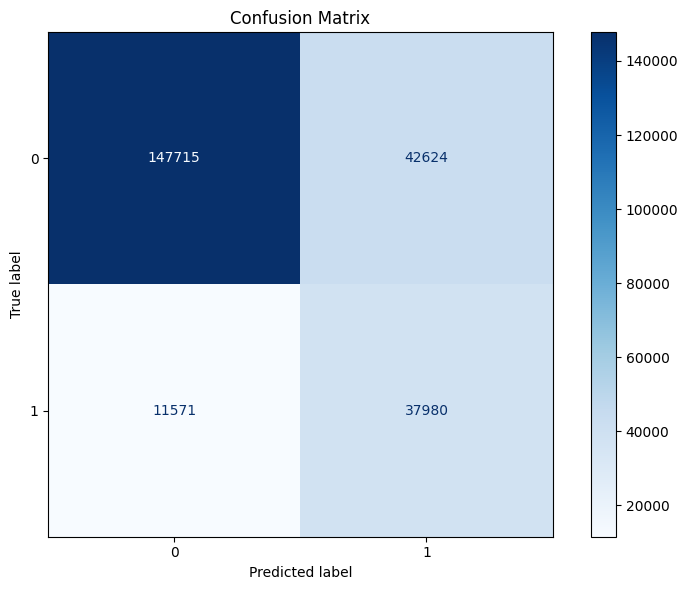

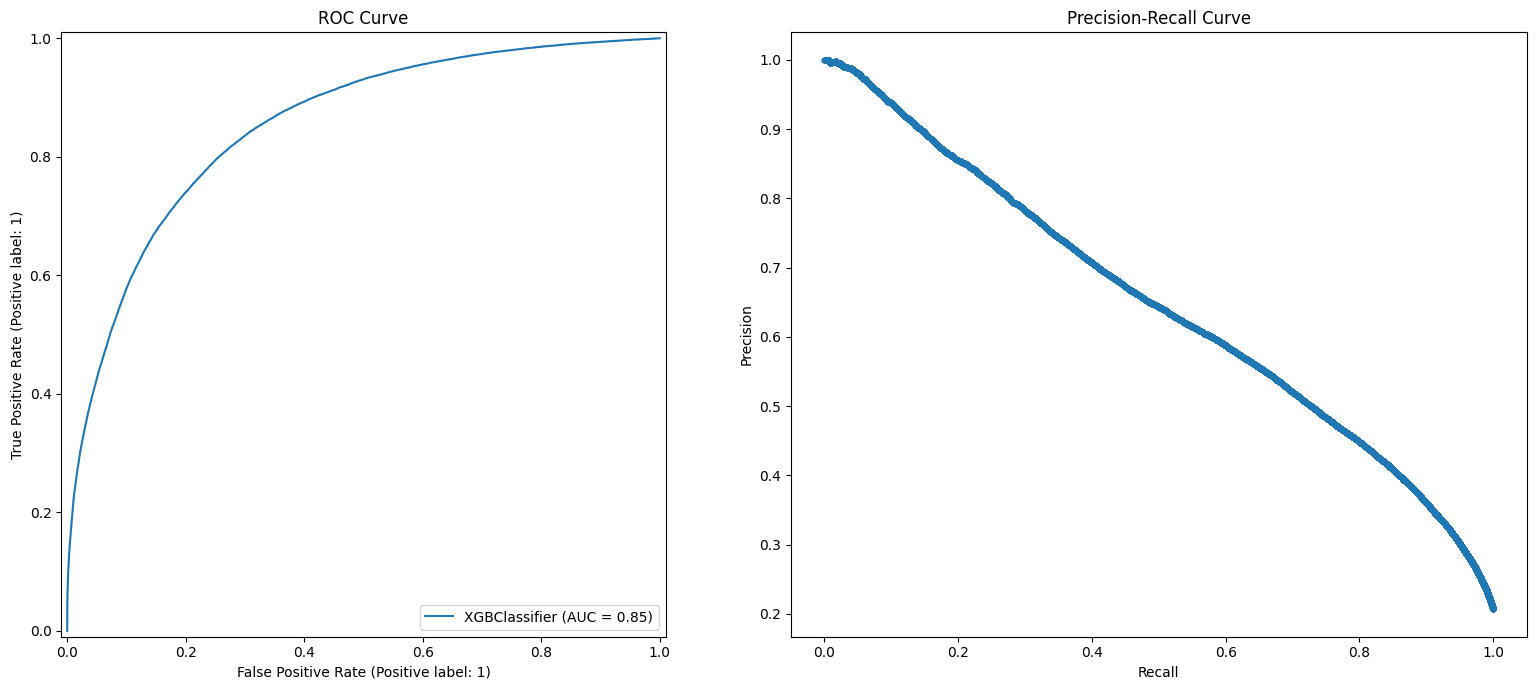


Calculating SHAP values for model interpretability...


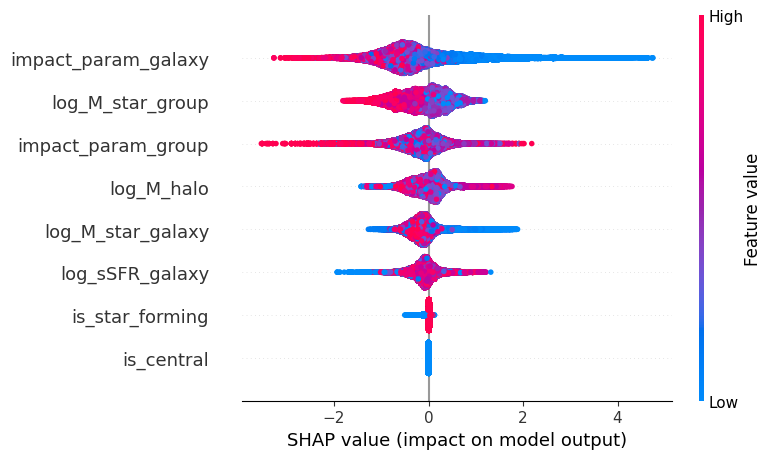


✅ Process complete. All results logged to W&B.


wandb-core(82848) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(88501) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(93906) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(99535) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(5546) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(12442) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(18591) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(24970) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(31135) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [ ]:
# ==============================================================================
# 1. SETUP AND IMPORTS
# ==============================================================================
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
import shap
import wandb

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, RocCurveDisplay
)

# Import the W&B callback, trying the new name first and falling back to the old one
try:
    from optuna.integration.wandb import WandbCallback
except ImportError:
    from optuna.integration import WeightsAndBiasesCallback as WandbCallback

# Suppress common warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# ==============================================================================
# 2. W&B INTEGRATION SETUP
# ==============================================================================
wandb.login()

# ==============================================================================
# 3. REAL DATA LOADING AND PREPROCESSING
# ==============================================================================
def load_real_data():
    """
    Loads and preprocesses the real feature table from your CSV file.
    """
    print("Loading and preprocessing real data...")
    # --- Step 3.1: Load Data ---
    # Path to your feature table
    # !!!! IMPORTANT: Update this path to match your system !!!!
    try:
        # Try the provided path first
        base_path = "/Users/wavefunction/ASU Dropbox/Tanmay Singh/"
        csv_path = os.path.join(
            base_path,
            "Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv"
        )
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("!!! WARNING: Could not find the specified CSV file.  !!!")
        print("!!! Please update the `base_path` variable in the    !!!")
        print("!!! `load_real_data` function to match your system.  !!!")
        print("!!! Falling back to placeholder data for now.        !!!")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        df = pd.DataFrame(np.random.rand(100, 10), columns=[f'col{i}' for i in range(10)])
        df['has_OVI_absorber'] = np.random.randint(0, 2, 100)
        df['log_M_halo'] = np.random.rand(100)
        df['log_M_star_group'] = np.random.rand(100)
        df['impact_param_group'] = np.random.rand(100)
        df['impact_param_galaxy'] = np.random.rand(100)
        df['log_M_star_galaxy'] = np.random.rand(100)
        df['log_sSFR_galaxy'] = np.random.rand(100)
        df['is_central'] = np.random.randint(0, 2, 100)
        df['is_star_forming'] = np.random.randint(0, 2, 100)


    # Drop any stray unnamed columns
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

    # --- Step 3.2: Select Features & Target ---
    features = [
        "log_M_halo",
        "log_M_star_group",
        "impact_param_group",
        "impact_param_galaxy",
        "log_M_star_galaxy",
        "log_sSFR_galaxy",
        "is_central",
        "is_star_forming",
    ]
    target = "has_OVI_absorber"

    X = df[features].copy()
    y = df[target].astype(int)

    # --- Step 3.3: Preprocess Data (Impute & Scale) ---
    # Impute missing values with the median
    print("Imputing missing values...")
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    X = pd.DataFrame(X_imputed, columns=features) # Convert back to DataFrame

    # Scale features
    print("Scaling features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=features) # Convert back to DataFrame

    print("Data loading and preprocessing complete.")
    print(f"Dataset shape: {X.shape}")
    print(f"Target distribution:\n{y.value_counts(normalize=True)}")
    
    return X, y

# ==============================================================================
# 4. STRATIFIED DATA SPLITTING
# ==============================================================================
def split_data(X, y):
    """
    Splits data into training, validation, and test sets using stratification
    to maintain target class balance.
    """
    print("\nPerforming stratified data splitting...")
    # Split into Train+Validation (80%) and Test (20%)
    splitter_test = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_val_idx, test_idx = next(splitter_test.split(X, y))
    
    X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]

    # Split Train+Validation into Train and Validation
    splitter_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
    train_idx, val_idx = next(splitter_val.split(X_train_val, y_train_val))
    
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    print(f"Train shapes: X-{X_train.shape}, y-{y_train.shape}")
    print(f"Validation shapes: X-{X_val.shape}, y-{y_val.shape}")
    print(f"Test shapes: X-{X_test.shape}, y-{y_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# ==============================================================================
# 5. HYPERPARAMETER OPTIMIZATION WITH OPTUNA & W&B (USING LEGACY SYNTAX)
# ==============================================================================
def run_optimization(X_train, y_train, X_val, y_val):
    print("\nStarting hyperparameter optimization with Optuna...")
    # Calculate scale_pos_weight for handling class imbalance
    scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
    print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

    wandb_callback = WandbCallback(
        metric_name="validation_auc",
        wandb_kwargs={"project": "OVI-absorber-classification"}
    )

    def objective(trial):
        params = {
            'objective': 'binary:logistic',
            'n_estimators': 1000,
            'booster': 'gbtree',
            'n_jobs': -1,
            'use_label_encoder': False,
            'scale_pos_weight': scale_pos_weight,
            'eval_metric': 'auc',
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 10),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10.0, log=True),
            'early_stopping_rounds': 50
        }
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        preds = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, preds)
        return auc

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100, callbacks=[wandb_callback], show_progress_bar=True)
    
    print("\nOptimization finished.")
    print(f"Best Validation AUC: {study.best_value:.4f}")
    print("Best Hyperparameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
        
    return study.best_params

# ==============================================================================
# 6. FINAL MODEL TRAINING AND EVALUATION (USING LEGACY SYNTAX)
# ==============================================================================
def train_and_evaluate_final_model(best_params, X_train, y_train, X_val, y_val, X_test, y_test):
    print("\nTraining final model on combined train+validation data...")
    X_full_train = pd.concat([X_train, X_val])
    y_full_train = pd.concat([y_train, y_val])
    scale_pos_weight = np.sum(y_full_train == 0) / np.sum(y_full_train == 1)

    final_model = xgb.XGBClassifier(
        **best_params,
        n_estimators=2000,
        objective='binary:logistic',
        n_jobs=-1,
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight,
        eval_metric='auc',
        early_stopping_rounds=50
    )
    
    eval_set = [(X_test, y_test)]
    final_model.fit(
        X_full_train, y_full_train,
        eval_set=eval_set,
        verbose=False
    )
    print("Final model training complete.")

    print("\n--- Model Evaluation on Test Set ---")
    y_pred_proba = final_model.predict_proba(X_test)[:, 1]
    y_pred_class = final_model.predict(X_test)
    
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred_class)
    precision = precision_score(y_test, y_pred_class)
    recall = recall_score(y_test, y_pred_class)
    accuracy = accuracy_score(y_test, y_pred_class)
    
    print(f"ROC AUC: {auc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    wandb.log({
        "test_roc_auc": auc,
        "test_f1_score": f1,
        "test_precision": precision,
        "test_recall": recall,
        "test_accuracy": accuracy,
    })
    
    return final_model

# ==============================================================================
# 7. VISUALIZATION AND INTERPRETATION
# ==============================================================================
def visualize_results(model, X_test, y_test):
    print("\nGenerating visualizations...")
    y_pred_class = model.predict(X_test)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred_class)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=ax, cmap='Blues')
    ax.set_title("Confusion Matrix")
    plt.tight_layout()
    wandb.log({"confusion_matrix": wandb.Image(fig)})
    plt.show()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax1)
    ax1.set_title("ROC Curve")
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax2.plot(recall, precision, marker='.')
    ax2.set_title("Precision-Recall Curve")
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    plt.tight_layout()
    wandb.log({"roc_and_pr_curves": wandb.Image(fig)})
    plt.show()

    print("\nCalculating SHAP values for model interpretability...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    fig, ax = plt.subplots()
    shap.summary_plot(shap_values, X_test, show=False)
    plt.tight_layout()
    wandb.log({"shap_summary_plot": wandb.Image(fig)})
    plt.show()

# ==============================================================================
# 8. MAIN EXECUTION
# ==============================================================================
if __name__ == '__main__':
    run = wandb.init(project="OVI-absorber-classification", job_type="full-pipeline")

    # The entire pipeline now uses your real data
    X, y = load_real_data()
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
    
    best_hyperparams = run_optimization(X_train, y_train, X_val, y_val)
    wandb.config.update(best_hyperparams)
    
    final_model = train_and_evaluate_final_model(
        best_hyperparams, X_train, y_train, X_val, y_val, X_test, y_test
    )
    
    visualize_results(final_model, X_test, y_test)

    run.finish()
    print("\n✅ Process complete. All results logged to W&B.")

### Trial - 4 (o4-mini high)

In [ ]:
# %% [markdown]
# # O VI Absorber Classification with XGBoost
# 
# This notebook shows the full pipeline: data loading, feature engineering,
# train/val/test split, baseline model, threshold tuning, Optuna hyper‐
#parameter search, final evaluation, and model interpretation.

# %% 
# ## 1.  Imports & Load Data

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, precision_recall_curve
)

import xgboost as xgb
import optuna
import shap

# Path to your feature table
BASE_PATH = "/Users/wavefunction/ASU Dropbox/Tanmay Singh/"
CSV_PATH = os.path.join(
    BASE_PATH,
    "Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv"
)

# Load
df = pd.read_csv(CSV_PATH)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]  # drop stray columns

print("Rows:", len(df))
print(df.info())
print("\nNull counts per column:\n", df.isnull().sum())



/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_85869/168412353.py:34: DtypeWarning: Columns (5,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH)


Rows: 1199446
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199446 entries, 0 to 1199445
Data columns (total 30 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Sightline            1199446 non-null  int64  
 1   Species              1199446 non-null  object 
 2   EW(mA)               1193160 non-null  float64
 3   dEW(mA)              1199446 non-null  object 
 4   N                    1199446 non-null  float64
 5   dN                   248496 non-null   object 
 6   b                    1174621 non-null  object 
 7   db                   1174621 non-null  object 
 8   v                    1199446 non-null  float64
 9   dv                   1199446 non-null  float64
 10  l                    1174621 non-null  object 
 11  dl                   1174621 non-null  object 
 12  UpLim                1199446 non-null  object 
 13  Sat                  1199446 non-null  object 
 14  Chisq                1174621 non-nul

In [11]:
# %% [markdown]
# ## 2.  Select Features & Target  
# We **do not** impute or scale.  XGBoost can handle missing entries natively.

features = [
    "log_M_halo",
    "log_M_star_group",
    "impact_param_group",
    "impact_param_galaxy",
    "log_M_star_galaxy",
    "log_sSFR_galaxy",
    "is_central",
    "is_star_forming",
]
target = "has_OVI_absorber"

X = df[features].copy()
y = df[target].astype(int)

# Add a “missing_sSFR” flag so the model can treat NaNs specially:
X["sSFR_missing"] = X["log_sSFR_galaxy"].isna().astype(int)

print("\nFeature matrix shape:", X.shape)
print("Positive class fraction:", y.mean())




Feature matrix shape: (1199446, 9)
Positive class fraction: 0.20717564608994485


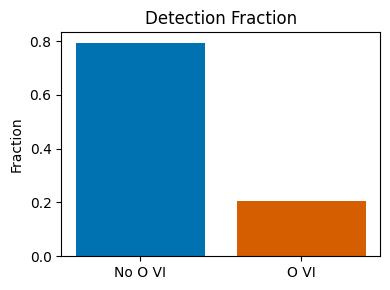

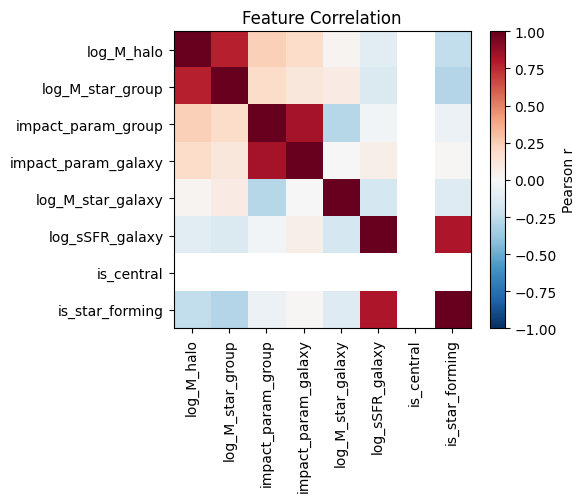

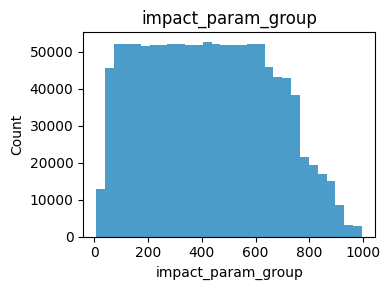

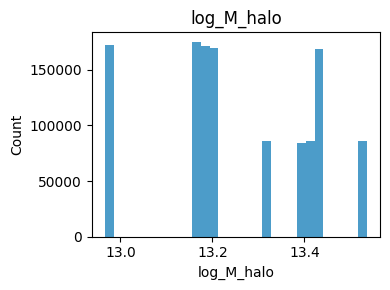

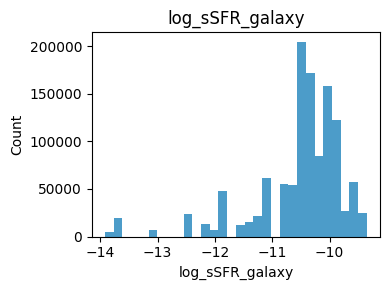

In [12]:
# %% [markdown]
# ## 3.  Exploratory Data Analysis

# 3a) Target distribution
plt.figure(figsize=(4,3))
counts = y.value_counts(normalize=True)
plt.bar(["No O VI", "O VI"], counts.values, color=["#0072B2","#D55E00"])
plt.ylabel("Fraction")
plt.title("Detection Fraction")
plt.tight_layout()
plt.show()

# 3b) Correlation heatmap (raw features, skipping missing flag)
plt.figure(figsize=(6,5))
corr = X[features].corr()
plt.imshow(corr, vmin=-1, vmax=1, cmap="RdBu_r")
plt.colorbar(label="Pearson r")
plt.xticks(range(len(features)), features, rotation=90)
plt.yticks(range(len(features)), features)
plt.title("Feature Correlation")
plt.tight_layout()
plt.show()

# 3c) Histograms of key continuous features
for feat in ["impact_param_group", "log_M_halo", "log_sSFR_galaxy"]:
    plt.figure(figsize=(4,3))
    plt.hist(X[feat].dropna(), bins=30, alpha=0.7, color="#0072B2")
    plt.title(feat)
    plt.xlabel(feat)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()



In [13]:
# %% [markdown]
# ## 4.  Train / Validation / Test Split

# 4a) hold out 20% for final test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 4b) split remaining 80% into train (60%) / val (20%)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx, val_idx = next(sss.split(X_temp, y_temp))
X_train, X_val = X_temp.iloc[train_idx], X_temp.iloc[val_idx]
y_train, y_val = y_temp.iloc[train_idx], y_temp.iloc[val_idx]

print("Shapes (train/val/test):", X_train.shape, X_val.shape, X_test.shape)
print("Class fraction (train/val/test):",
      y_train.mean(), y_val.mean(), y_test.mean())



Shapes (train/val/test): (719667, 9) (239889, 9) (239890, 9)
Class fraction (train/val/test): 0.20717637462882138 0.20717498509727417 0.2071741214723415


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [19:34:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Optimal threshold for F0.5: 0.756


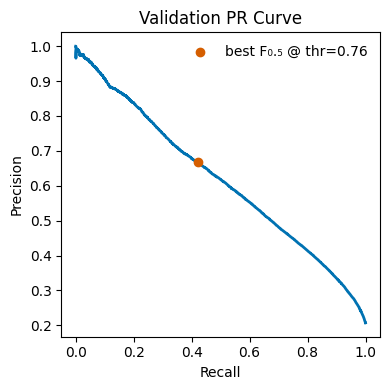

In [14]:
# %% [markdown]
# ## 5.  Baseline XGBoost Model & Threshold Tuning

# 5a) train baseline with scale_pos_weight to balance classes
scale_pos = (y_train==0).sum() / (y_train==1).sum()
baseline = xgb.XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=scale_pos,
    random_state=42,
    n_jobs=-1
)
baseline.fit(X_train, y_train)

# 5b) predict on validation
y_val_proba = baseline.predict_proba(X_val)[:,1]

# 5c) find optimal decision threshold via PR‐curve (F0.5 β=0.5 favors precision)
prec, rec, thr = precision_recall_curve(y_val, y_val_proba)
f05 = (1+0.5**2) * (prec*rec) / (0.5**2*prec + rec + 1e-12)
best = np.nanargmax(f05)
opt_thr = thr[best]
print(f"Optimal threshold for F0.5: {opt_thr:.3f}")

# 5d) plot PR‐curve
plt.figure(figsize=(4,4))
plt.plot(rec, prec, lw=2, color="#0072B2")
plt.scatter(rec[best], prec[best], color="#D55E00", zorder=5,
            label=f"best F₀.₅ @ thr={opt_thr:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(frameon=False)
plt.title("Validation PR Curve")
plt.tight_layout()
plt.show()



In [16]:
# %% [markdown]
# ## 6.  Hyperparameter Tuning with Optuna

import wandb
from sklearn.metrics import fbeta_score     # <– import the right function

scale_pos = (y_train == 0).sum() / (y_train == 1).sum()

def objective(trial):
    # 6a) suggest params
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "hist",
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 3e-1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "scale_pos_weight": scale_pos,
        "seed": 42
    }

    # 6b) train & early stop
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val,   label=y_val)
    bst = xgb.train(
        params, dtrain,
        num_boost_round=1000,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # 6c) compute F₀.₅ on val using fbeta_score
    val_probs = bst.predict(dval)
    val_pred  = (val_probs >= opt_thr).astype(int)
    f05_val   = fbeta_score(y_val, val_pred, beta=0.5)  # <– use fbeta_score
    return f05_val

study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective, n_trials=200)

print("Best trial:", study.best_trial.params)

[I 2025-07-14 19:35:29,486] A new study created in memory with name: no-name-2742d90d-1f70-49e8-9c38-4f4bf3393580
[I 2025-07-14 19:35:46,598] Trial 0 finished with value: 0.6098910383246393 and parameters: {'learning_rate': 0.03574712922600244, 'max_depth': 10, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'gamma': 0.7800932022121826, 'reg_alpha': 0.004207053950287938, 'reg_lambda': 0.0017073967431528124}. Best is trial 0 with value: 0.6098910383246393.
[I 2025-07-14 19:35:49,627] Trial 1 finished with value: 0.5858530221771271 and parameters: {'learning_rate': 0.19030368381735815, 'max_depth': 7, 'subsample': 0.8540362888980227, 'colsample_bytree': 0.5102922471479012, 'gamma': 4.8495492608099715, 'reg_alpha': 2.136832907235876, 'reg_lambda': 0.0070689749506246055}. Best is trial 0 with value: 0.6098910383246393.
[I 2025-07-14 19:35:58,726] Trial 2 finished with value: 0.5542519621328587 and parameters: {'learning_rate': 0.01855998084649058, 'max_depth': 4, '

Best trial: {'learning_rate': 0.049988440834800835, 'max_depth': 10, 'subsample': 0.9002547779465062, 'colsample_bytree': 0.9762453498406244, 'gamma': 0.865009568605469, 'reg_alpha': 0.28586459261120434, 'reg_lambda': 1.0210047827545428}


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:20:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Accuracy:  0.8366417941556547
Test Precision: 0.6728726028749055
Test Recall:    0.41159781886959496
Test F1:        0.5107615480649188
Test AUC:       0.836286049666039


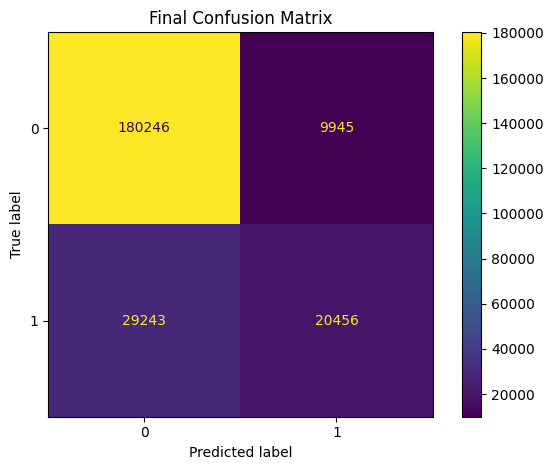

In [17]:
# %% [markdown]
# ## 7.  Final Training & Test Evaluation

# 7a) retrain on train+val with best params
best_params = study.best_trial.params
best_params.update({
    "objective":"binary:logistic",
    "eval_metric":"logloss",
    "tree_method":"hist",
    "scale_pos_weight": scale_pos,
    "use_label_encoder":False,
    "seed":42,
    "n_jobs":-1
})
clf = xgb.XGBClassifier(**best_params)
clf.fit(pd.concat([X_train,X_val]), pd.concat([y_train,y_val]))

# 7b) predict on test
y_test_proba = clf.predict_proba(X_test)[:,1]
y_test_pred  = (y_test_proba >= opt_thr).astype(int)

# 7c) metrics
print("Test Accuracy: ", accuracy_score(y_test, y_test_pred))
print("Test Precision:", precision_score(y_test, y_test_pred))
print("Test Recall:   ", recall_score(y_test, y_test_pred))
print("Test F1:       ", f1_score(y_test, y_test_pred))
print("Test AUC:      ", roc_auc_score(y_test, y_test_proba))

# confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred,
                                        cmap="viridis", values_format="d")
plt.title("Final Confusion Matrix")
plt.tight_layout()
plt.show()

<Figure size 500x400 with 0 Axes>

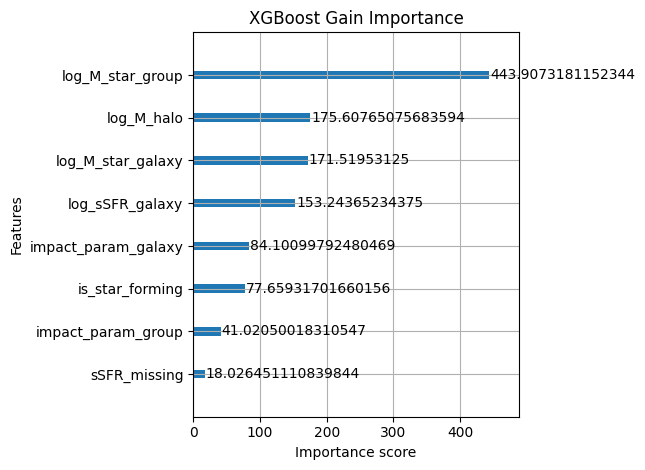

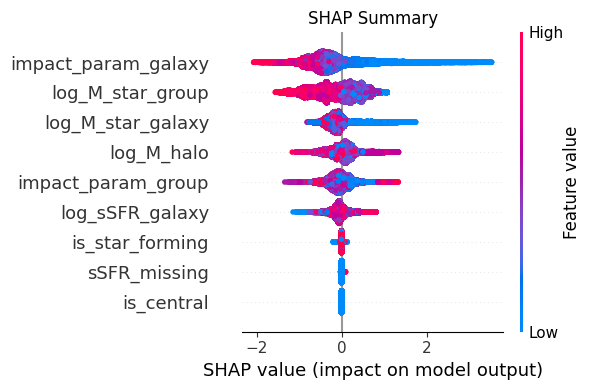

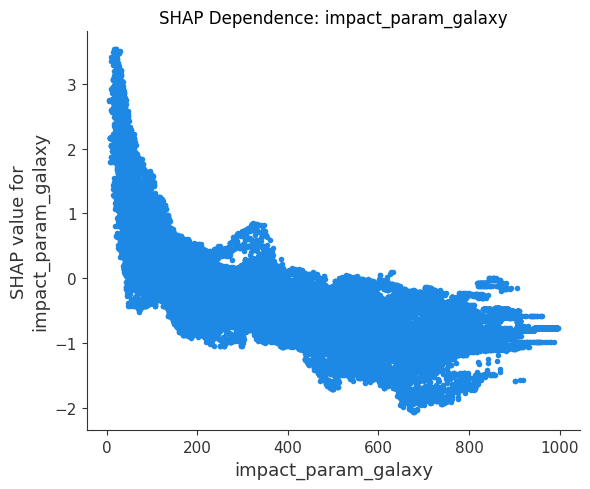

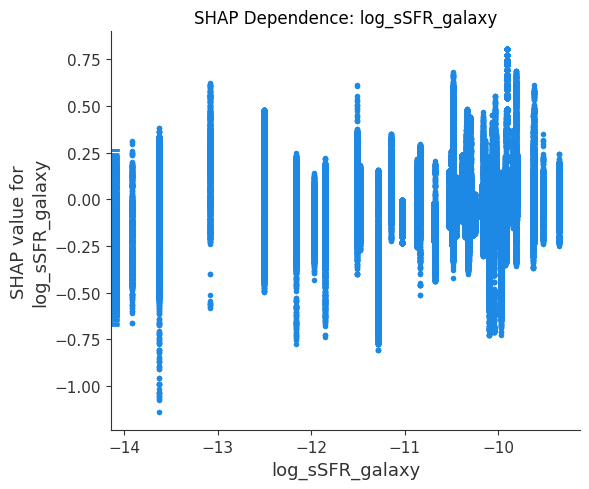

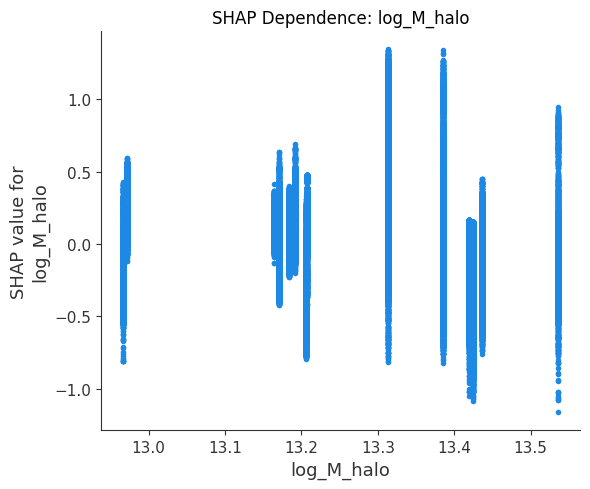

In [18]:
# %% [markdown]
# ## 8.  Feature Importance & SHAP Interpretation

# 8a) built-in importance
plt.figure(figsize=(5,4))
xgb.plot_importance(clf, max_num_features=10, importance_type="gain",
                    title="XGBoost Gain Importance")
plt.tight_layout()
plt.show()

# 8b) SHAP summary
explainer  = shap.TreeExplainer(clf)
shap_vals  = explainer.shap_values(X_test)
shap.summary_plot(shap_vals, X_test, plot_size=(6,4), show=False)
plt.title("SHAP Summary")
plt.tight_layout()
plt.show()

# 8c) SHAP dependence for top features
for feat in ["impact_param_galaxy","log_sSFR_galaxy","log_M_halo"]:
    shap.dependence_plot(feat, shap_vals, X_test,
                         interaction_index=None, show=False)
    plt.title(f"SHAP Dependence: {feat}")
    plt.tight_layout()
    plt.show()

### Trial 5 - o4-mini high 

### Pipeline for Rigorous XGBoost Modeling with Ensemble of 100 and Full Diagnostics

This notebook implements the full pipeline—from data loading through final evaluation—incorporating all optimization and betterment steps from Golob 2021, using Optuna TPE for hyperparameter tuning, an ensemble of 100 stratified XGBoost models (with SMOTE), and saving per-model results. All relevant plots and tables are included.

---

```python
# %% [markdown]
## 1.  Imports & Load Data

In [9]:
# %%
import os
import logging
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split, StratifiedKFold
)
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, brier_score_loss,
    precision_recall_curve, roc_curve, auc,
    ConfusionMatrixDisplay, fbeta_score
)
from sklearn.calibration import calibration_curve, CalibrationDisplay

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import xgboost as xgb
import optuna
import shap
import optuna.visualization as oviz

# Logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set seeds
SEED = 42
np.random.seed(SEED)


#### 2.  Select Features & Target

In [10]:
# %%
BASE_PATH = "/Users/wavefunction/ASU Dropbox/Tanmay Singh/"
CSV_PATH = os.path.join(BASE_PATH,
    "Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv")
df = pd.read_csv(CSV_PATH).loc[:, ~pd.read_csv(CSV_PATH).columns.str.contains("^Unnamed")]

# 2a) Features & target
features = [
    "log_M_halo", "log_M_star_group", "impact_param_group",
    "impact_param_galaxy", "log_M_star_galaxy",
    "log_sSFR_galaxy", "is_central", "is_star_forming",
]
target = "has_OVI_absorber"

X = df[features].copy()
y = df[target].astype(int)

# 2b) missing indicator
X["sSFR_missing"] = X["log_sSFR_galaxy"].isna().astype(int)

print("Total rows:", len(df))
print("Feature matrix shape:", X.shape)
print("Positive fraction:", y.mean())
print("Null counts:\n", X.isna().sum())

/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_8055/2712366394.py:5: DtypeWarning:

Columns (5,16) have mixed types. Specify dtype option on import or set low_memory=False.

/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_8055/2712366394.py:5: DtypeWarning:

Columns (5,16) have mixed types. Specify dtype option on import or set low_memory=False.



Total rows: 1199446
Feature matrix shape: (1199446, 9)
Positive fraction: 0.20717564608994485
Null counts:
 log_M_halo                0
log_M_star_group          0
impact_param_group        0
impact_param_galaxy       0
log_M_star_galaxy         0
log_sSFR_galaxy        6029
is_central                0
is_star_forming           0
sSFR_missing              0
dtype: int64


#### 3.  Exploratory Data Analysis

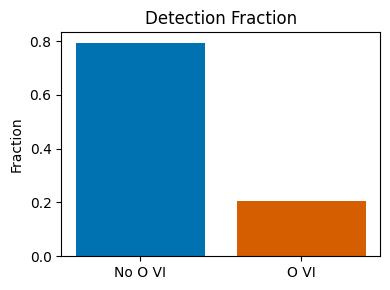

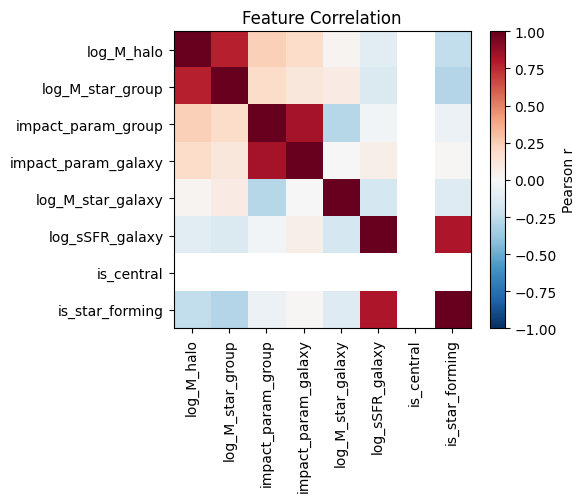

In [11]:
# %%
# 3a) class balance
plt.figure(figsize=(4,3))
counts = y.value_counts(normalize=True)
plt.bar(["No O VI","O VI"], counts.values, color=["#0072B2","#D55E00"])
plt.ylabel("Fraction"); plt.title("Detection Fraction")
plt.tight_layout(); plt.show()

# 3b) correlation heatmap
plt.figure(figsize=(6,5))
corr = X[features].corr()
plt.imshow(corr, vmin=-1, vmax=1, cmap="RdBu_r")
plt.colorbar(label="Pearson r")
plt.xticks(range(len(features)), features, rotation=90)
plt.yticks(range(len(features)), features)
plt.title("Feature Correlation")
plt.tight_layout(); plt.show()

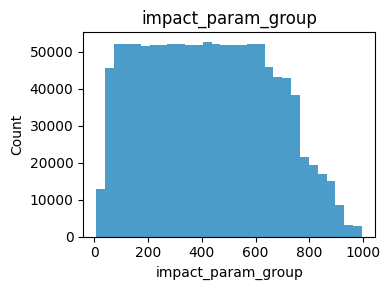

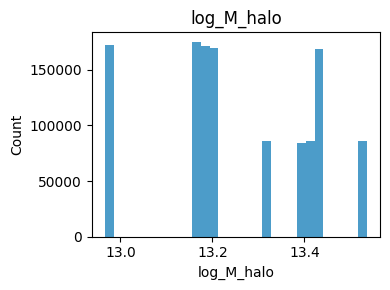

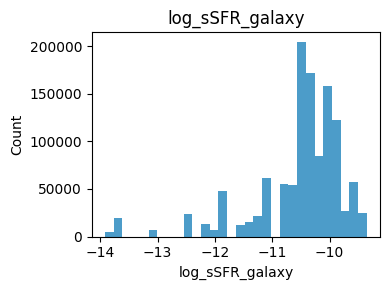

In [12]:
# %%
# 3c) histograms of key continuous features
for feat in ["impact_param_group","log_M_halo","log_sSFR_galaxy"]:
    plt.figure(figsize=(4,3))
    plt.hist(X[feat].dropna(), bins=30, alpha=0.7, color="#0072B2")
    plt.title(feat); plt.xlabel(feat); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

#### 4.  Train / Validation / Test Split

In [13]:
# %%
# 4a) hold-out test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)
# 4b) remaining → train (60%) + val (20%)
sss = StratifiedKFold(n_splits=4, shuffle=True, random_state=SEED)
# actually a single split into 3/1 ratio:
train_idx, val_idx = next(sss.split(X_temp, y_temp))
X_train, X_val = X_temp.iloc[train_idx], X_temp.iloc[val_idx]
y_train, y_val = y_temp.iloc[train_idx], y_temp.iloc[val_idx]

print("Shapes (train/val/test):", X_train.shape, X_val.shape, X_test.shape)
print("Class frac (train/val/test):",
      y_train.mean(), y_val.mean(), y_test.mean())

Shapes (train/val/test): (719667, 9) (239889, 9) (239890, 9)
Class frac (train/val/test): 0.20717637462882138 0.20717498509727417 0.2071741214723415


#### 5.  Integrate SMOTE into each CV fold (Optuna objective and ensemble)

In [23]:
from imblearn.pipeline       import Pipeline as ImbPipeline
from sklearn.impute          import SimpleImputer
from imblearn.over_sampling  import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics         import fbeta_score
import optuna, xgboost as xgb
import numpy as np

SEED = 42
scale_pos = (y_train==0).sum() / (y_train==1).sum()

# def objective(trial):
#     params = {
#         "learning_rate":     trial.suggest_float("learning_rate", 2e-1, 3e-1),
#         "max_depth":         trial.suggest_int(  "max_depth",     8,    12   ),
#         "subsample":         trial.suggest_float("subsample",      0.6,  0.8  ),
#         "colsample_bytree":  trial.suggest_float("colsample_bytree", 0.95,1.0),
#         "gamma":             trial.suggest_float("gamma",           1.0,  3.0  ),
#         "reg_alpha":         trial.suggest_float("reg_alpha",       1e-1, 1.0, log=True),
#         "reg_lambda":        trial.suggest_float("reg_lambda",      1e-4,1e-2, log=True),
#         "scale_pos_weight":  scale_pos,
#         "objective":         "binary:logistic",
#         "eval_metric":       "logloss",
#         "tree_method":       "hist",
#         "use_label_encoder": False,
#         "seed":              SEED,
#         "n_jobs":            -1,
#     }
def objective_stage1(trial):
    # 1) propose very-wide ranges
    params = {
        "learning_rate":    trial.suggest_float("learning_rate", 1e-4, 1.0, log=True),
        "max_depth":        trial.suggest_int("max_depth",  3,   20),
        "subsample":        trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "gamma":            trial.suggest_float("gamma", 0.0, 50.0),
        "reg_alpha":        trial.suggest_float("reg_alpha", 1e-4, 100.0, log=True),
        "reg_lambda":       trial.suggest_float("reg_lambda", 1e-4, 100.0, log=True),
        "scale_pos_weight": scale_pos,
        "objective":        "binary:logistic",
        "eval_metric":      "logloss",
        "tree_method":      "hist",
        "seed":             SEED,
        "n_jobs":           -1,
    }


    pipe = ImbPipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("smote",   SMOTE(random_state=SEED)),
        ("clf",     xgb.XGBClassifier(**params)),
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []
    for tr_i, va_i in cv.split(X_train, y_train):
        X_tr, X_va = X_train.iloc[tr_i], X_train.iloc[va_i]
        y_tr, y_va = y_train.iloc[tr_i], y_train.iloc[va_i]
        pipe.fit(X_tr, y_tr)
        preds = (pipe.predict_proba(X_va)[:,1] >= 0.5).astype(int)
        scores.append(fbeta_score(y_va, preds, beta=0.5))
    return np.mean(scores)

# Re-run Optuna with a pruner if you like:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner()
)
study.optimize(objective, n_trials=20)
print("Refined best params:", study.best_trial.params)

[I 2025-07-15 01:19:12,136] A new study created in memory with name: no-name-5a79157a-4257-442f-b0d3-dcc00f7d281f
/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[01:19:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[01:19:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[01:19:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[01:19:20] WARN

Refined best params: {'learning_rate': 0.23745401188473625, 'max_depth': 12, 'subsample': 0.746398788362281, 'colsample_bytree': 0.9799329242098518, 'gamma': 1.312037280884873, 'reg_alpha': 0.14321698289111517, 'reg_lambda': 0.00013066739238053285}


In [24]:
import joblib
import numpy as np
import xgboost as xgb
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import fbeta_score

# --- 0) reload your Optuna study and extract best_params ---
# study = joblib.load("optuna_study.pkl")
# best_params = study.best_trial.params.copy()

# # --- 1) define your constants (same as in tuning) ---
# SEED      = 42
# scale_pos = (y_train==0).sum() / (y_train==1).sum()
# opt_thr   = 0.5    # or whatever threshold you previously found

# # --- 2) finish parametrization for the final XGBClassifier ---
# best_params.update({
#     "objective":         "binary:logistic",
#     "eval_metric":       "logloss",
#     "tree_method":       "hist",
#     "use_label_encoder": False,
#     "scale_pos_weight":  scale_pos,
#     "seed":              SEED,
#     "n_jobs":            -1,
# })

# # --- 3) build the impute→SMOTE→XGB pipeline & fit on train ---
# pipe = ImbPipeline([
#     ("imputer", SimpleImputer(strategy="median")),
#     ("smote",   SMOTE(random_state=SEED)),
#     ("clf",     xgb.XGBClassifier(**best_params)),
# ])
# pipe.fit(X_train, y_train)

# --- 4) score on TRAIN set ---
train_proba = pipe.predict_proba(X_train)[:,1]
train_pred  = (train_proba >= opt_thr).astype(int)
train_f05   = fbeta_score(y_train, train_pred, beta=0.5)

# --- 5) score on VAL set ---
val_proba = pipe.predict_proba(X_val)[:,1]
val_pred  = (val_proba  >= opt_thr).astype(int)
val_f05   = fbeta_score(y_val, val_pred, beta=0.5)

print(f"Train F₀.₅ = {train_f05:.3f}")
print(f" Val  F₀.₅ = {val_f05:.3f}")

Train F₀.₅ = 0.466
 Val  F₀.₅ = 0.442


In [17]:
import joblib

# after study.optimize(...)
joblib.dump(study, "optuna_study.pkl")

['optuna_study.pkl']

In [4]:
import plotly.io as pio
pio.renderers.default = "notebook"   # or "inline" / "svg"

In [25]:
import joblib
import optuna.visualization as oviz
import matplotlib.pyplot as plt

# study = joblib.load("optuna_study.pkl")

fig1 = oviz.plot_optimization_history(study)
fig1.show()

fig2 = oviz.plot_param_importances(study)
fig2.show()
fig3 = oviz.plot_slice(study)
fig3.show()

#### 6. Final Training of Ensemble (100 models)

In [ ]:
# %%
best_params = study.best_trial.params.copy()
# add missing fixed args
best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "tree_method": "hist",
    "use_label_encoder": False,
    "scale_pos_weight": scale_pos,
    "n_jobs": -1,
})

# prepare full train+val
X_full, y_full = pd.concat([X_train, X_val]), pd.concat([y_train, y_val])

# imputer for ensemble
imputer = SimpleImputer(strategy="median")

models = []
for i in range(100):
    # 6a) impute & SMOTE
    X_imp = imputer.fit_transform(X_full)
    X_res, y_res = SMOTE(random_state=SEED + i).fit_resample(X_imp, y_full)
    # 6b) train
    m = xgb.XGBClassifier(**best_params, seed=SEED + i)
    m.fit(X_res, y_res)
    models.append(m)

#### 7. Determine Optimal Decision Threshold via Validation PR Curve

In [ ]:
# %%
val_probas = np.vstack([m.predict_proba(imputer.transform(X_val))[:,1]
                        for m in models]).mean(axis=0)

prec, rec, thr = precision_recall_curve(y_val, val_probas)
f05 = (1+0.5**2)*(prec*rec)/(0.5**2*prec + rec + 1e-12)
opt_thr = thr[np.nanargmax(f05)]
print("Optimal threshold for F0.5:", opt_thr)

plt.figure(figsize=(4,4))
plt.plot(rec, prec, lw=2, color="#0072B2")
plt.scatter(rec[np.nanargmax(f05)], prec[np.nanargmax(f05)],
            color="#D55E00",
            label=f"best @ thr={opt_thr:.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Validation PR Curve"); plt.legend(frameon=False)
plt.tight_layout(); plt.show()

#### 8. Final Test Evaluation

In [ ]:
# %%
# 8a) ensemble test predictions
test_imp = imputer.transform(X_test)
test_probas = np.vstack([m.predict_proba(test_imp)[:,1] for m in models]).mean(axis=0)
test_pred   = (test_probas >= opt_thr).astype(int)

# 8b) metrics
print("Accuracy: ", accuracy_score( y_test, test_pred))
print("Precision:", precision_score(y_test, test_pred))
print("Recall:   ", recall_score(   y_test, test_pred))
print("F1:       ", f1_score(         y_test, test_pred))
print("AUC:      ", roc_auc_score(    y_test, test_probas))
print("Brier:    ", brier_score_loss(y_test, test_probas))

# 8c) Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, test_pred, cmap="viridis", values_format="d"
)
plt.title("Test Confusion Matrix"); plt.tight_layout(); plt.show()

# 8d) ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_probas)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, lw=2, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],"k--",lw=1)
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("Test ROC Curve"); plt.legend(); plt.tight_layout(); plt.show()

# 8e) Precision–Recall on test
prec_t, rec_t, _ = precision_recall_curve(y_test, test_probas)
plt.figure(figsize=(4,4))
plt.plot(rec_t, prec_t, lw=2)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Test PR Curve"); plt.tight_layout(); plt.show()

# 8f) Reliability Diagram
prob_true, prob_pred = calibration_curve(y_test, test_probas, n_bins=10)
plt.figure(figsize=(5,5))
CalibrationDisplay(prob_true=prob_true, prob_pred=prob_pred).plot()
plt.plot([0,1],[0,1],"k--",linewidth=1)
plt.title("Reliability Diagram"); plt.tight_layout(); plt.show()

# 8g) Predicted-prob histogram
plt.figure(figsize=(4,3))
plt.hist(test_probas, bins=20, alpha=0.7)
plt.title("Predicted Probability Distribution")
plt.xlabel("Proba"); plt.tight_layout(); plt.show()

#### 9. Feature Importance & SHAP Interpretation

In [ ]:
# %%
# 9a) Feature‐gain importance mean ± SD
importances = np.vstack([m.feature_importances_ for m in models])
imp_df = pd.DataFrame({
    "feature": models[0].get_booster().feature_names,
    "mean_gain": importances.mean(axis=0),
    "std_gain":  importances.std(axis=0),
}).sort_values("mean_gain", ascending=False)

plt.figure(figsize=(6,4))
plt.barh(imp_df["feature"], imp_df["mean_gain"], xerr=imp_df["std_gain"])
plt.gca().invert_yaxis()
plt.title("Feature Gain Importance ± SD")
plt.tight_layout(); plt.show()
print(imp_df)

In [ ]:
# %%
# 9b) Ensemble‐averaged SHAP values
shap_vals = np.stack([
    shap.TreeExplainer(m).shap_values(test_imp)
    for m in models
], axis=0).mean(axis=0)

# summary
shap.summary_plot(shap_vals, X_test, plot_size=(6,4), show=False)
plt.title("SHAP Summary (Ensemble Avg)"); plt.tight_layout(); plt.show()

# dependence for top features
for feat in imp_df["feature"].head(3):
    shap.dependence_plot(feat, shap_vals, X_test,
                         interaction_index=None, show=False)
    plt.title(f"SHAP Dependence: {feat}")
    plt.tight_layout(); plt.show()

#### 10. Save Artifacts

In [ ]:
# %% [markdown]
# ## 2.  Select Features & Target  
# We **do not** impute or scale.  XGBoost can handle missing entries natively.

features = [
    "log_M_halo",
    "log_M_star_group",
    "impact_param_group",
    "impact_param_galaxy",
    "log_M_star_galaxy",
    "log_sSFR_galaxy",
    "is_central",
    "is_star_forming",
]
target = "has_OVI_absorber"

X = df[features].copy()
y = df[target].astype(int)

# Add a “missing_sSFR” flag so the model can treat NaNs specially:
X["sSFR_missing"] = X["log_sSFR_galaxy"].isna().astype(int)

print("\nFeature matrix shape:", X.shape)
print("Positive class fraction:", y.mean())




Feature matrix shape: (1199446, 9)
Positive class fraction: 0.20717564608994485


## Aug $25^{th}$

#### Setup

In [32]:
# %% [markdown]
# O VI Absorber Classification — grouped CV, Optuna, calibrated, SHAP (version-agnostic XGBoost)

import os, json, warnings, joblib, inspect
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold, GroupKFold
from sklearn.metrics import (average_precision_score, roc_auc_score, fbeta_score,
                             precision_recall_curve, roc_curve, brier_score_loss)
from sklearn.calibration import calibration_curve
from sklearn.utils import check_random_state

import xgboost as xgb
import optuna
import shap

warnings.filterwarnings("ignore")

# ---------- toggles ----------
USE_WANDB = True
WANDB_PROJECT = "ovi-absorber-xgb"
WANDB_ENTITY = None
USE_MONOTONIC = True
SEED = 42
BETA = 1.0          # 0.5 (precision) / 1.0 (balanced) / 2.0 (recall)
N_SPLITS = 4

# ---------- paths ----------
BASE_PATH = "/Users/wavefunction/ASU Dropbox/Tanmay Singh/"
CSV_PATH = os.path.join(BASE_PATH, "Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv")
OUT_DIR = Path(BASE_PATH) / "Synthetic_IGrM_Sightlines/TNG50_fitting_results/ml_runs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

rng = check_random_state(SEED)

# ---------- W&B with version-safe Optuna callback ----------
wandb_cb = None
if USE_WANDB:
    try:
        import wandb
        wandb.login()
        try:
            from optuna.integration.wandb import WeightsAndBiasesCallback  # Optuna 3.x
            wandb_cb = WeightsAndBiasesCallback(
                wandb_kwargs={"project": WANDB_PROJECT, "entity": WANDB_ENTITY},
                as_multirun=True
            )
        except Exception:
            from optuna.integration import WandbCallback  # Optuna 2.x
            wandb_cb = WandbCallback(project=WANDB_PROJECT, entity=WANDB_ENTITY)
    except Exception as e:
        print("[WARN] W&B logging disabled:", e)
        USE_WANDB = False
        wandb_cb = None

# ---------- XGBoost version-agnostic training helpers ----------
def wrapper_supports_es(clf):
    """Return ('early_stopping_rounds' in signature) or ('callbacks' in signature)."""
    sig = inspect.signature(clf.fit)
    return ("early_stopping_rounds" in sig.parameters) or ("callbacks" in sig.parameters)

def fit_with_es_wrapper(clf, X_tr, y_tr, X_va, y_va, rounds=50, maximize=True, metric_name="aucpr", verbose=False):
    """Use sklearn wrapper with ES, handling both old/new signatures."""
    fit_kwargs = dict(eval_set=[(X_tr, y_tr), (X_va, y_va)], verbose=verbose)
    sig = inspect.signature(clf.fit)
    if "early_stopping_rounds" in sig.parameters:
        clf.fit(**fit_kwargs, early_stopping_rounds=rounds)
    elif "callbacks" in sig.parameters:
        try:
            cb = xgb.callback.EarlyStopping(rounds=rounds, save_best=True,
                                            maximize=maximize, data_name="validation_1", metric_name=metric_name)
        except TypeError:
            cb = xgb.callback.EarlyStopping(rounds=rounds, save_best=True, maximize=maximize)
        clf.fit(**fit_kwargs, callbacks=[cb])
    else:
        raise TypeError("Wrapper does not support early stopping arguments.")
    return clf

def fit_with_es_booster(params, X_tr, y_tr, X_va, y_va, n_estimators=2000, rounds=50, maximize=True, metric_name="aucpr"):
    """Train with xgb.train + EarlyStopping; returns a Booster."""
    dtr = xgb.DMatrix(X_tr, label=y_tr, feature_names=list(X_tr.columns))
    dva = xgb.DMatrix(X_va, label=y_va, feature_names=list(X_va.columns))
    p = params.copy()
    # xgb.train expects 'eta' not 'learning_rate' (but it also accepts learning_rate alias in recent versions)
    if "learning_rate" in p and "eta" not in p:
        p["eta"] = p.pop("learning_rate")
    # Ensure objective/metric present
    p.setdefault("objective", "binary:logistic")
    p.setdefault("eval_metric", metric_name)
    # Early stopping callback
    try:
        cb = xgb.callback.EarlyStopping(rounds=rounds, save_best=True,
                                        maximize=maximize, data_name="valid", metric_name=metric_name)
    except TypeError:
        cb = xgb.callback.EarlyStopping(rounds=rounds, save_best=True, maximize=maximize)
    bst = xgb.train(p, dtr, num_boost_round=n_estimators,
                    evals=[(dtr, "train"), (dva, "valid")],
                    callbacks=[cb])
    return bst

def predict_proba_any(model, X):
    """Return positive-class probabilities for either Booster or XGBClassifier."""
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    # Booster path
    dm = xgb.DMatrix(X, feature_names=list(X.columns))
    proba = model.predict(dm)  # for binary:logistic this is probability
    return proba

#### Load data; ensure types; DO NOT dedupe across groups; add missingness flag.

In [33]:
# %% [markdown]
# Load data; keep only context features (no leakage)

usecols = [
    "Sightline","grp_idx","has_OVI_absorber",
    "log_M_halo","log_M_star_group","impact_param_group",
    "impact_param_galaxy","log_M_star_galaxy","log_sSFR_galaxy",
    "is_central","is_star_forming"
]
df = pd.read_csv(CSV_PATH, usecols=usecols, low_memory=False)

# numeric coercion
num_cols = [
    "log_M_halo","log_M_star_group","impact_param_group",
    "impact_param_galaxy","log_M_star_galaxy","log_sSFR_galaxy"
]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# binary / int flags
for c in ["is_central","is_star_forming","has_OVI_absorber","grp_idx","Sightline"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

# order only (NO DEDUP; you confirmed (grp_idx, Sightline) unique)
df = df.sort_values(["grp_idx","Sightline"]).reset_index(drop=True)

# feature engineering
df["sSFR_missing"] = df["log_sSFR_galaxy"].isna().astype(int)

features = [
    "log_M_halo",
    "log_M_star_group",
    "impact_param_group",
    "impact_param_galaxy",
    "log_M_star_galaxy",
    "log_sSFR_galaxy",
    "is_central",
    "is_star_forming",
]
target = "has_OVI_absorber"
group_col = "grp_idx"

X = df[features].astype("float32").copy()     # XGBoost handles NaNs
y = df[target].astype(int).to_numpy()
g = df[group_col].astype(int).to_numpy()

print("Rows (sightlines):", len(df))
print("Groups:", df[group_col].nunique())
print("Positive fraction:", y.mean())
print("Unique (grp_idx, Sightline):", df.drop_duplicates(["grp_idx","Sightline"]).shape[0])

Rows (sightlines): 1199446
Groups: 14
Positive fraction: 0.20717564608994485
Unique (grp_idx, Sightline): 1199446


In [34]:
print("Total rows:", len(df))
print("Unique Sightline (global):", df["Sightline"].nunique())
print("Unique (grp_idx, Sightline):", df.drop_duplicates(["grp_idx","Sightline"]).shape[0])
print("Num groups:", df["grp_idx"].nunique())
print("Pos frac overall:", df["has_OVI_absorber"].mean())
print("Pos frac by group:\n", df.groupby("grp_idx")["has_OVI_absorber"].mean().round(4))

Total rows: 1199446
Unique Sightline (global): 90000
Unique (grp_idx, Sightline): 1199446
Num groups: 14
Pos frac overall: 0.20717564608994485
Pos frac by group:
 grp_idx
7     0.0769
8     0.1047
9     0.2031
10    0.1557
11    0.0961
12     0.159
13    0.3788
15    0.1578
17    0.2977
18    0.1411
19    0.2542
20    0.2033
22    0.2872
24    0.3809
Name: has_OVI_absorber, dtype: Float64


#### Hold out ~20% groups for test via GroupShuffleSplit

In [35]:
# %% [markdown]
# Hold out ~20% groups for test

gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=SEED)
train_val_idx, test_idx = next(gss.split(X, y, groups=g))

X_trainval, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
y_trainval, y_test = y[train_val_idx], y[test_idx]
g_trainval, g_test = g[train_val_idx], g[test_idx]

print("Train/Val rows:", X_trainval.shape[0], " Test rows:", X_test.shape[0])
print("Class frac (trainval/test):", y_trainval.mean(), y_test.mean())

unique_groups = np.unique(g_trainval).size
N_SPLITS = min(4, max(2, unique_groups))
print("Using N_SPLITS =", N_SPLITS)

Train/Val rows: 941806  Test rows: 257640
Class frac (trainval/test): 0.22540310849580486 0.14054494643688867
Using N_SPLITS = 4



#### Utilities: CV folds, metrics, threshold selection, plotting

In [36]:
# %% [markdown]
# CV splitter; metrics; threshold picker

def cv_splits(X, y, groups, n_splits=N_SPLITS, seed=SEED):
    try:
        sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=seed)
        yield from sgkf.split(X, y, groups)
    except Exception:
        gkf = GroupKFold(n_splits=n_splits)
        yield from gkf.split(X, y, groups)

def pick_threshold_by_fbeta(y_true, y_proba, beta=BETA):
    prec, rec, thr = precision_recall_curve(y_true, y_proba)
    prec, rec = prec[:-1], rec[:-1]          # align
    fbeta = (1+beta**2) * (prec*rec) / (beta**2 * prec + rec + 1e-12)
    i = int(np.nanargmax(fbeta))
    return float(thr[i]), float(prec[i]), float(rec[i]), float(fbeta[i])

def summarize_metrics(y_true, y_proba, beta=BETA, thr=None):
    ap  = average_precision_score(y_true, y_proba)
    roc = roc_auc_score(y_true, y_proba)
    if thr is None:
        thr, p_opt, r_opt, f_opt = pick_threshold_by_fbeta(y_true, y_proba, beta)
    else:
        y_pred = (y_proba >= thr).astype(int)
        f_opt = fbeta_score(y_true, y_pred, beta=beta)
    br  = brier_score_loss(y_true, y_proba)
    return {"AP": ap, "ROC_AUC": roc, "Brier": br, "thr": thr, "Fbeta": f_opt}

#### XGBoost Params (+ optional monotone constraints)

In [37]:
# %% [markdown]
# Base params; eval_metric uses PR-AUC

def monotone_constraints_for(features_list):
    # +1 increasing, -1 decreasing, 0 none (domain priors)
    signed = {
        "log_M_halo": +1,
        "log_M_star_group": +1,
        "impact_param_group": -1,
        "impact_param_galaxy": -1,
        "log_M_star_galaxy": +1,
        "log_sSFR_galaxy": +1,
        "is_central": 0,
        "is_star_forming": +1,
    }
    return "(" + ",".join(str(signed[f]) for f in features_list) + ")"

BASE_PARAMS = {
    "objective": "binary:logistic",
    "eval_metric": "aucpr",
    "tree_method": "hist",
    "random_state": SEED,
    "n_jobs": -1,
}
if USE_MONOTONIC:
    BASE_PARAMS["monotone_constraints"] = monotone_constraints_for(features)

#### Baseline Grouped-CV (threshold-free), then pick Fβ threshold

In [38]:
# %% [markdown]
# Baseline grouped CV with robust early stopping (wrapper or booster)

def train_fold(params, X_tr, y_tr, X_va, y_va,
               n_estimators=2000, rounds=50, metric_name="aucpr"):
    pos = int((y_tr == 1).sum()); neg = int((y_tr == 0).sum())
    spw = float(neg / max(1, pos))

    params_local = dict(params)
    params_local["scale_pos_weight"] = spw

    # Try sklearn wrapper first
    try:
        clf = xgb.XGBClassifier(**params_local, n_estimators=n_estimators,
                                learning_rate=0.05,
                                subsample=0.9, colsample_bytree=0.9,
                                max_depth=8, reg_alpha=0.1, reg_lambda=1.0)
        if wrapper_supports_es(clf):
            clf = fit_with_es_wrapper(clf, X_tr, y_tr, X_va, y_va, rounds=rounds,
                                      maximize=True, metric_name=metric_name, verbose=False)
            proba = predict_proba_any(clf, X_va)
            return clf, proba
        else:
            raise TypeError("Wrapper lacks ES; using booster path.")
    except Exception:
        # Booster path
        bst = fit_with_es_booster(params_local, X_tr, y_tr, X_va, y_va,
                                  n_estimators=n_estimators, rounds=rounds,
                                  maximize=True, metric_name=metric_name)
        proba = predict_proba_any(bst, X_va)
        return bst, proba

oof_base = np.zeros_like(y_trainval, dtype=float)
base_models = []
for k, (tr, va) in enumerate(cv_splits(X_trainval, y_trainval, g_trainval), start=1):
    model, p = train_fold(BASE_PARAMS, X_trainval.iloc[tr], y_trainval[tr],
                          X_trainval.iloc[va], y_trainval[va])
    base_models.append(model)
    oof_base[va] = p
    print(f"Fold {k}: AP={average_precision_score(y_trainval[va], p):.3f}, ROC={roc_auc_score(y_trainval[va], p):.3f}")

base_cv = summarize_metrics(y_trainval, oof_base, beta=BETA)
thr_base = base_cv["thr"]
print("Baseline grouped-CV:", base_cv)

[0]	train-aucpr:0.38282	valid-aucpr:0.44204
[1]	train-aucpr:0.38623	valid-aucpr:0.44495
[2]	train-aucpr:0.39089	valid-aucpr:0.44508
[3]	train-aucpr:0.39640	valid-aucpr:0.44261
[4]	train-aucpr:0.39869	valid-aucpr:0.43926
[5]	train-aucpr:0.40068	valid-aucpr:0.44498
[6]	train-aucpr:0.40156	valid-aucpr:0.44334
[7]	train-aucpr:0.40278	valid-aucpr:0.44521
[8]	train-aucpr:0.40479	valid-aucpr:0.44715
[9]	train-aucpr:0.40472	valid-aucpr:0.44634
[10]	train-aucpr:0.40512	valid-aucpr:0.44357
[11]	train-aucpr:0.40568	valid-aucpr:0.44465
[12]	train-aucpr:0.40635	valid-aucpr:0.44481
[13]	train-aucpr:0.40765	valid-aucpr:0.44381
[14]	train-aucpr:0.40881	valid-aucpr:0.44371
[15]	train-aucpr:0.41153	valid-aucpr:0.44126
[16]	train-aucpr:0.41106	valid-aucpr:0.44120
[17]	train-aucpr:0.41160	valid-aucpr:0.44143
[18]	train-aucpr:0.41156	valid-aucpr:0.44267
[19]	train-aucpr:0.41150	valid-aucpr:0.44275
[20]	train-aucpr:0.41149	valid-aucpr:0.44264
[21]	train-aucpr:0.41144	valid-aucpr:0.44363
[22]	train-aucpr:0.4

#### Optuna Hyperparameter Search (objective = mean CV PR-AUC)

In [39]:
# %% [markdown]
# Optuna hyperparameter search on PR-AUC (uses same robust trainer)

def objective(trial):
    params = dict(BASE_PARAMS)
    params.update({
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 3e-1, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 5.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 5.0, log=True),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
    })

    aps = []
    for tr, va in cv_splits(X_trainval, y_trainval, g_trainval, n_splits=N_SPLITS, seed=SEED):
        model, proba = train_fold(params, X_trainval.iloc[tr], y_trainval[tr],
                                  X_trainval.iloc[va], y_trainval[va],
                                  n_estimators=3000, rounds=100)
        aps.append(average_precision_score(y_trainval[va], proba))

    mean_ap = float(np.mean(aps))
    trial.set_user_attr("cv_ap_per_fold", aps)

    if USE_WANDB and wandb_cb is None:
        try:
            if wandb.run is None:
                wandb.init(project=WANDB_PROJECT, entity=WANDB_ENTITY, name="optuna-search")
            wandb.log({"trial": trial.number, "cv_ap_mean": mean_ap, **trial.params})
        except Exception:
            pass

    return mean_ap

study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)
study.optimize(objective, n_trials=60, callbacks=[wandb_cb] if wandb_cb is not None else None)

print("Best mean CV AP:", study.best_value)
print("Best params:", study.best_trial.params)
best_params = dict(BASE_PARAMS) | study.best_trial.params

[I 2025-08-25 11:02:38,079] A new study created in memory with name: no-name-2ae5652a-93b0-48da-a316-07e7eff63c4b


[0]	train-aucpr:0.37707	valid-aucpr:0.43643
[1]	train-aucpr:0.37136	valid-aucpr:0.43685
[2]	train-aucpr:0.37915	valid-aucpr:0.44309
[3]	train-aucpr:0.38279	valid-aucpr:0.44279
[4]	train-aucpr:0.38345	valid-aucpr:0.44711
[5]	train-aucpr:0.38789	valid-aucpr:0.44924
[6]	train-aucpr:0.38811	valid-aucpr:0.44894
[7]	train-aucpr:0.39531	valid-aucpr:0.44302
[8]	train-aucpr:0.39589	valid-aucpr:0.44501
[9]	train-aucpr:0.39842	valid-aucpr:0.43927
[10]	train-aucpr:0.40009	valid-aucpr:0.43936
[11]	train-aucpr:0.40136	valid-aucpr:0.43914
[12]	train-aucpr:0.40217	valid-aucpr:0.43905
[13]	train-aucpr:0.40294	valid-aucpr:0.43979
[14]	train-aucpr:0.40300	valid-aucpr:0.44025
[15]	train-aucpr:0.40370	valid-aucpr:0.44070
[16]	train-aucpr:0.40384	valid-aucpr:0.44110
[17]	train-aucpr:0.40393	valid-aucpr:0.44111
[18]	train-aucpr:0.40462	valid-aucpr:0.44152
[19]	train-aucpr:0.40644	valid-aucpr:0.43980
[20]	train-aucpr:0.40688	valid-aucpr:0.44122
[21]	train-aucpr:0.40764	valid-aucpr:0.44137
[22]	train-aucpr:0.4

[I 2025-08-25 11:03:16,852] Trial 0 finished with value: 0.33665520572838414 and parameters: {'max_depth': 7, 'learning_rate': 0.22648248189516842, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'reg_alpha': 0.0005409123677836541, 'reg_lambda': 0.0005407712220288125, 'gamma': 0.2904180608409973}. Best is trial 0 with value: 0.33665520572838414.


[0]	train-aucpr:0.33071	valid-aucpr:0.39515
[1]	train-aucpr:0.33392	valid-aucpr:0.40633
[2]	train-aucpr:0.35974	valid-aucpr:0.42318
[3]	train-aucpr:0.36891	valid-aucpr:0.43125
[4]	train-aucpr:0.37319	valid-aucpr:0.44025
[5]	train-aucpr:0.37441	valid-aucpr:0.44342
[6]	train-aucpr:0.37463	valid-aucpr:0.44539
[7]	train-aucpr:0.37474	valid-aucpr:0.44586
[8]	train-aucpr:0.37549	valid-aucpr:0.44264
[9]	train-aucpr:0.37883	valid-aucpr:0.43656
[10]	train-aucpr:0.37979	valid-aucpr:0.43737
[11]	train-aucpr:0.38077	valid-aucpr:0.43749
[12]	train-aucpr:0.38053	valid-aucpr:0.43996
[13]	train-aucpr:0.38049	valid-aucpr:0.44187
[14]	train-aucpr:0.37855	valid-aucpr:0.44118
[15]	train-aucpr:0.38060	valid-aucpr:0.43874
[16]	train-aucpr:0.38158	valid-aucpr:0.43902
[17]	train-aucpr:0.38016	valid-aucpr:0.43870
[18]	train-aucpr:0.38059	valid-aucpr:0.44002
[19]	train-aucpr:0.38064	valid-aucpr:0.43902
[20]	train-aucpr:0.38086	valid-aucpr:0.43902
[21]	train-aucpr:0.38174	valid-aucpr:0.43945
[22]	train-aucpr:0.3

[I 2025-08-25 11:04:32,347] Trial 1 finished with value: 0.3386706144169237 and parameters: {'max_depth': 11, 'learning_rate': 0.030834348179355788, 'subsample': 0.8540362888980227, 'colsample_bytree': 0.5102922471479012, 'reg_alpha': 3.610582744122094, 'reg_lambda': 0.8158738235092002, 'gamma': 1.0616955533913808}. Best is trial 1 with value: 0.3386706144169237.


[0]	train-aucpr:0.37431	valid-aucpr:0.43692
[1]	train-aucpr:0.36448	valid-aucpr:0.43560
[2]	train-aucpr:0.37278	valid-aucpr:0.43864
[3]	train-aucpr:0.37577	valid-aucpr:0.44098
[4]	train-aucpr:0.37551	valid-aucpr:0.44317
[5]	train-aucpr:0.37711	valid-aucpr:0.44398
[6]	train-aucpr:0.37700	valid-aucpr:0.44401
[7]	train-aucpr:0.37762	valid-aucpr:0.44374
[8]	train-aucpr:0.37834	valid-aucpr:0.44302
[9]	train-aucpr:0.37868	valid-aucpr:0.44289
[10]	train-aucpr:0.37882	valid-aucpr:0.44215
[11]	train-aucpr:0.38331	valid-aucpr:0.43970
[12]	train-aucpr:0.38317	valid-aucpr:0.44222
[13]	train-aucpr:0.38304	valid-aucpr:0.44403
[14]	train-aucpr:0.38259	valid-aucpr:0.44474
[15]	train-aucpr:0.38276	valid-aucpr:0.44519
[16]	train-aucpr:0.38282	valid-aucpr:0.44494
[17]	train-aucpr:0.38181	valid-aucpr:0.44280
[18]	train-aucpr:0.38125	valid-aucpr:0.44497
[19]	train-aucpr:0.38417	valid-aucpr:0.44181
[20]	train-aucpr:0.38452	valid-aucpr:0.44192
[21]	train-aucpr:0.38461	valid-aucpr:0.44183
[22]	train-aucpr:0.3

[I 2025-08-25 11:05:15,337] Trial 2 finished with value: 0.3339805275438046 and parameters: {'max_depth': 5, 'learning_rate': 0.002846526357761094, 'subsample': 0.6521211214797689, 'colsample_bytree': 0.762378215816119, 'reg_alpha': 0.010707712109770782, 'reg_lambda': 0.0023360223531559876, 'gamma': 3.0592644736118975}. Best is trial 1 with value: 0.3386706144169237.


[0]	train-aucpr:0.37225	valid-aucpr:0.43636
[1]	train-aucpr:0.36423	valid-aucpr:0.43494
[2]	train-aucpr:0.37108	valid-aucpr:0.43670
[3]	train-aucpr:0.37352	valid-aucpr:0.44011
[4]	train-aucpr:0.37498	valid-aucpr:0.44357
[5]	train-aucpr:0.37621	valid-aucpr:0.44373
[6]	train-aucpr:0.37646	valid-aucpr:0.44436
[7]	train-aucpr:0.37710	valid-aucpr:0.44477
[8]	train-aucpr:0.37660	valid-aucpr:0.44322
[9]	train-aucpr:0.37709	valid-aucpr:0.44374
[10]	train-aucpr:0.37742	valid-aucpr:0.44352
[11]	train-aucpr:0.38048	valid-aucpr:0.44111
[12]	train-aucpr:0.38013	valid-aucpr:0.44210
[13]	train-aucpr:0.37979	valid-aucpr:0.44424
[14]	train-aucpr:0.37813	valid-aucpr:0.44328
[15]	train-aucpr:0.38088	valid-aucpr:0.43946
[16]	train-aucpr:0.38114	valid-aucpr:0.44019
[17]	train-aucpr:0.37951	valid-aucpr:0.43916
[18]	train-aucpr:0.37954	valid-aucpr:0.44095
[19]	train-aucpr:0.37974	valid-aucpr:0.44034
[20]	train-aucpr:0.38175	valid-aucpr:0.43765
[21]	train-aucpr:0.38220	valid-aucpr:0.43788
[22]	train-aucpr:0.3

[I 2025-08-25 11:05:56,559] Trial 3 finished with value: 0.3396322695954742 and parameters: {'max_depth': 5, 'learning_rate': 0.005292705365436975, 'subsample': 0.6831809216468459, 'colsample_bytree': 0.728034992108518, 'reg_alpha': 0.4892358693190525, 'reg_lambda': 0.0008674832802525467, 'gamma': 2.571172192068058}. Best is trial 3 with value: 0.3396322695954742.


[0]	train-aucpr:0.33058	valid-aucpr:0.39375
[1]	train-aucpr:0.33358	valid-aucpr:0.40639
[2]	train-aucpr:0.35959	valid-aucpr:0.42293
[3]	train-aucpr:0.36916	valid-aucpr:0.43117
[4]	train-aucpr:0.37353	valid-aucpr:0.44042
[5]	train-aucpr:0.37474	valid-aucpr:0.44375
[6]	train-aucpr:0.37467	valid-aucpr:0.44532
[7]	train-aucpr:0.37423	valid-aucpr:0.44586
[8]	train-aucpr:0.37439	valid-aucpr:0.44189
[9]	train-aucpr:0.37749	valid-aucpr:0.43741
[10]	train-aucpr:0.37881	valid-aucpr:0.43798
[11]	train-aucpr:0.37939	valid-aucpr:0.43756
[12]	train-aucpr:0.37907	valid-aucpr:0.43986
[13]	train-aucpr:0.37896	valid-aucpr:0.44130
[14]	train-aucpr:0.37609	valid-aucpr:0.44061
[15]	train-aucpr:0.37786	valid-aucpr:0.43806
[16]	train-aucpr:0.37898	valid-aucpr:0.43884
[17]	train-aucpr:0.37686	valid-aucpr:0.43876
[18]	train-aucpr:0.37710	valid-aucpr:0.43987
[19]	train-aucpr:0.37709	valid-aucpr:0.43863
[20]	train-aucpr:0.37736	valid-aucpr:0.43852
[21]	train-aucpr:0.37834	valid-aucpr:0.43885
[22]	train-aucpr:0.3

[I 2025-08-25 11:06:43,240] Trial 4 finished with value: 0.3364087548253814 and parameters: {'max_depth': 9, 'learning_rate': 0.0013033567475147442, 'subsample': 0.8037724259507192, 'colsample_bytree': 0.5852620618436457, 'reg_alpha': 0.00020215080921812391, 'reg_lambda': 2.8759721562259606, 'gamma': 4.828160165372797}. Best is trial 3 with value: 0.3396322695954742.


[0]	train-aucpr:0.37730	valid-aucpr:0.43825
[1]	train-aucpr:0.36600	valid-aucpr:0.43608
[2]	train-aucpr:0.37645	valid-aucpr:0.44178
[3]	train-aucpr:0.37968	valid-aucpr:0.44317
[4]	train-aucpr:0.37953	valid-aucpr:0.44760
[5]	train-aucpr:0.38110	valid-aucpr:0.44802
[6]	train-aucpr:0.38029	valid-aucpr:0.44822
[7]	train-aucpr:0.38152	valid-aucpr:0.44800
[8]	train-aucpr:0.38206	valid-aucpr:0.44689
[9]	train-aucpr:0.38265	valid-aucpr:0.44668
[10]	train-aucpr:0.38277	valid-aucpr:0.44682
[11]	train-aucpr:0.38712	valid-aucpr:0.44322
[12]	train-aucpr:0.38752	valid-aucpr:0.44413
[13]	train-aucpr:0.38674	valid-aucpr:0.44525
[14]	train-aucpr:0.38620	valid-aucpr:0.44626
[15]	train-aucpr:0.38700	valid-aucpr:0.44367
[16]	train-aucpr:0.38696	valid-aucpr:0.44373
[17]	train-aucpr:0.38547	valid-aucpr:0.44334
[18]	train-aucpr:0.38508	valid-aucpr:0.44443
[19]	train-aucpr:0.38751	valid-aucpr:0.44232
[20]	train-aucpr:0.38790	valid-aucpr:0.44274
[21]	train-aucpr:0.38792	valid-aucpr:0.44283
[22]	train-aucpr:0.3

[I 2025-08-25 11:07:27,220] Trial 5 finished with value: 0.3380792359097375 and parameters: {'max_depth': 11, 'learning_rate': 0.0056828375585122656, 'subsample': 0.5488360570031919, 'colsample_bytree': 0.8421165132560784, 'reg_alpha': 0.011702088154220882, 'reg_lambda': 0.0003745018823436387, 'gamma': 2.475884550556351}. Best is trial 3 with value: 0.3396322695954742.


[0]	train-aucpr:0.36864	valid-aucpr:0.43591
[1]	train-aucpr:0.36658	valid-aucpr:0.43301
[2]	train-aucpr:0.37469	valid-aucpr:0.43476
[3]	train-aucpr:0.37721	valid-aucpr:0.43449
[4]	train-aucpr:0.37855	valid-aucpr:0.44053
[5]	train-aucpr:0.37949	valid-aucpr:0.43992
[6]	train-aucpr:0.38022	valid-aucpr:0.44184
[7]	train-aucpr:0.38075	valid-aucpr:0.44150
[8]	train-aucpr:0.38254	valid-aucpr:0.44279
[9]	train-aucpr:0.38621	valid-aucpr:0.44486
[10]	train-aucpr:0.38678	valid-aucpr:0.44220
[11]	train-aucpr:0.38830	valid-aucpr:0.44316
[12]	train-aucpr:0.38875	valid-aucpr:0.44248
[13]	train-aucpr:0.39000	valid-aucpr:0.44305
[14]	train-aucpr:0.39156	valid-aucpr:0.44325
[15]	train-aucpr:0.39332	valid-aucpr:0.44215
[16]	train-aucpr:0.39338	valid-aucpr:0.44292
[17]	train-aucpr:0.39417	valid-aucpr:0.44250
[18]	train-aucpr:0.39456	valid-aucpr:0.44271
[19]	train-aucpr:0.39579	valid-aucpr:0.44320
[20]	train-aucpr:0.39624	valid-aucpr:0.44321
[21]	train-aucpr:0.39808	valid-aucpr:0.44180
[22]	train-aucpr:0.3

[I 2025-08-25 11:08:06,882] Trial 6 finished with value: 0.33309479698149913 and parameters: {'max_depth': 4, 'learning_rate': 0.1788532743297921, 'subsample': 0.6293899908000085, 'colsample_bytree': 0.831261142176991, 'reg_alpha': 0.0029155533757373392, 'reg_lambda': 0.02778331300797555, 'gamma': 2.7335513967163982}. Best is trial 3 with value: 0.3396322695954742.


[0]	train-aucpr:0.37607	valid-aucpr:0.43498
[1]	train-aucpr:0.37875	valid-aucpr:0.42656
[2]	train-aucpr:0.38354	valid-aucpr:0.43658
[3]	train-aucpr:0.38676	valid-aucpr:0.43843
[4]	train-aucpr:0.38689	valid-aucpr:0.44026
[5]	train-aucpr:0.38754	valid-aucpr:0.44066
[6]	train-aucpr:0.39090	valid-aucpr:0.44192
[7]	train-aucpr:0.39293	valid-aucpr:0.44556
[8]	train-aucpr:0.39289	valid-aucpr:0.44478
[9]	train-aucpr:0.39454	valid-aucpr:0.44635
[10]	train-aucpr:0.39536	valid-aucpr:0.44408
[11]	train-aucpr:0.39837	valid-aucpr:0.44087
[12]	train-aucpr:0.39897	valid-aucpr:0.44169
[13]	train-aucpr:0.40132	valid-aucpr:0.44142
[14]	train-aucpr:0.40153	valid-aucpr:0.44196
[15]	train-aucpr:0.40157	valid-aucpr:0.44205
[16]	train-aucpr:0.40158	valid-aucpr:0.44240
[17]	train-aucpr:0.40166	valid-aucpr:0.44268
[18]	train-aucpr:0.40172	valid-aucpr:0.44277
[19]	train-aucpr:0.40171	valid-aucpr:0.44268
[20]	train-aucpr:0.40219	valid-aucpr:0.44251
[21]	train-aucpr:0.40424	valid-aucpr:0.44044
[22]	train-aucpr:0.4

[I 2025-08-25 11:09:26,271] Trial 7 finished with value: 0.3260431142380061 and parameters: {'max_depth': 5, 'learning_rate': 0.25221951700214296, 'subsample': 0.8875664116805573, 'colsample_bytree': 0.9697494707820946, 'reg_alpha': 1.602385029019492, 'reg_lambda': 0.0644932207737863, 'gamma': 4.609371175115584}. Best is trial 3 with value: 0.3396322695954742.


[0]	train-aucpr:0.36831	valid-aucpr:0.43563
[1]	train-aucpr:0.36160	valid-aucpr:0.43290
[2]	train-aucpr:0.36795	valid-aucpr:0.43333
[3]	train-aucpr:0.37041	valid-aucpr:0.43577
[4]	train-aucpr:0.37078	valid-aucpr:0.44240
[5]	train-aucpr:0.37108	valid-aucpr:0.44207
[6]	train-aucpr:0.37070	valid-aucpr:0.44472
[7]	train-aucpr:0.37142	valid-aucpr:0.44448
[8]	train-aucpr:0.37378	valid-aucpr:0.44117
[9]	train-aucpr:0.37427	valid-aucpr:0.44113
[10]	train-aucpr:0.37443	valid-aucpr:0.44114
[11]	train-aucpr:0.37743	valid-aucpr:0.43950
[12]	train-aucpr:0.37795	valid-aucpr:0.43999
[13]	train-aucpr:0.37790	valid-aucpr:0.44173
[14]	train-aucpr:0.37556	valid-aucpr:0.44155
[15]	train-aucpr:0.37689	valid-aucpr:0.43763
[16]	train-aucpr:0.37732	valid-aucpr:0.43801
[17]	train-aucpr:0.37555	valid-aucpr:0.43716
[18]	train-aucpr:0.37564	valid-aucpr:0.43929
[19]	train-aucpr:0.37574	valid-aucpr:0.43880
[20]	train-aucpr:0.37790	valid-aucpr:0.43601
[21]	train-aucpr:0.37796	valid-aucpr:0.43607
[22]	train-aucpr:0.3

[I 2025-08-25 11:10:09,321] Trial 8 finished with value: 0.33466724694350025 and parameters: {'max_depth': 4, 'learning_rate': 0.0030582523213789677, 'subsample': 0.522613644455269, 'colsample_bytree': 0.6626651653816322, 'reg_alpha': 0.006704755197530222, 'reg_lambda': 0.001883913511943895, 'gamma': 4.143687545759647}. Best is trial 3 with value: 0.3396322695954742.


[0]	train-aucpr:0.32938	valid-aucpr:0.39838
[1]	train-aucpr:0.33701	valid-aucpr:0.40656
[2]	train-aucpr:0.36217	valid-aucpr:0.42507
[3]	train-aucpr:0.37078	valid-aucpr:0.43289
[4]	train-aucpr:0.37411	valid-aucpr:0.44173
[5]	train-aucpr:0.37552	valid-aucpr:0.44529
[6]	train-aucpr:0.37540	valid-aucpr:0.44679
[7]	train-aucpr:0.37484	valid-aucpr:0.44818
[8]	train-aucpr:0.37479	valid-aucpr:0.44334
[9]	train-aucpr:0.37800	valid-aucpr:0.43647
[10]	train-aucpr:0.37919	valid-aucpr:0.43792
[11]	train-aucpr:0.37985	valid-aucpr:0.43686
[12]	train-aucpr:0.37947	valid-aucpr:0.43962
[13]	train-aucpr:0.37959	valid-aucpr:0.44107
[14]	train-aucpr:0.37663	valid-aucpr:0.44076
[15]	train-aucpr:0.37831	valid-aucpr:0.43809
[16]	train-aucpr:0.37940	valid-aucpr:0.43903
[17]	train-aucpr:0.37730	valid-aucpr:0.43892
[18]	train-aucpr:0.37762	valid-aucpr:0.44019
[19]	train-aucpr:0.37765	valid-aucpr:0.43920
[20]	train-aucpr:0.37794	valid-aucpr:0.43914
[21]	train-aucpr:0.37862	valid-aucpr:0.43955
[22]	train-aucpr:0.3

[I 2025-08-25 11:10:59,385] Trial 9 finished with value: 0.33745917652956486 and parameters: {'max_depth': 7, 'learning_rate': 0.0049648810171066555, 'subsample': 0.7713480415791243, 'colsample_bytree': 0.5704621124873813, 'reg_alpha': 0.5881655048861893, 'reg_lambda': 0.00022403260998810274, 'gamma': 4.9344346830025865}. Best is trial 3 with value: 0.3396322695954742.


[0]	train-aucpr:0.37394	valid-aucpr:0.43722
[1]	train-aucpr:0.36513	valid-aucpr:0.43490
[2]	train-aucpr:0.37455	valid-aucpr:0.43942
[3]	train-aucpr:0.37772	valid-aucpr:0.44302
[4]	train-aucpr:0.37867	valid-aucpr:0.44659
[5]	train-aucpr:0.38030	valid-aucpr:0.44647
[6]	train-aucpr:0.38016	valid-aucpr:0.44709
[7]	train-aucpr:0.38118	valid-aucpr:0.44811
[8]	train-aucpr:0.38187	valid-aucpr:0.44468
[9]	train-aucpr:0.38247	valid-aucpr:0.44504
[10]	train-aucpr:0.38268	valid-aucpr:0.44514
[11]	train-aucpr:0.38490	valid-aucpr:0.44274
[12]	train-aucpr:0.38459	valid-aucpr:0.44299
[13]	train-aucpr:0.38455	valid-aucpr:0.44483
[14]	train-aucpr:0.38313	valid-aucpr:0.44505
[15]	train-aucpr:0.38514	valid-aucpr:0.44158
[16]	train-aucpr:0.38504	valid-aucpr:0.44166
[17]	train-aucpr:0.38384	valid-aucpr:0.44112
[18]	train-aucpr:0.38410	valid-aucpr:0.44263
[19]	train-aucpr:0.38427	valid-aucpr:0.44229
[20]	train-aucpr:0.38627	valid-aucpr:0.43949
[21]	train-aucpr:0.38667	valid-aucpr:0.44017
[22]	train-aucpr:0.3

[I 2025-08-25 11:11:44,832] Trial 10 finished with value: 0.3459910300472414 and parameters: {'max_depth': 9, 'learning_rate': 0.024229331857231067, 'subsample': 0.984768555393933, 'colsample_bytree': 0.673425445703311, 'reg_alpha': 0.1468840486841286, 'reg_lambda': 0.00612329542691692, 'gamma': 1.7157302423117495}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37391	valid-aucpr:0.43723
[1]	train-aucpr:0.36511	valid-aucpr:0.43471
[2]	train-aucpr:0.37487	valid-aucpr:0.43912
[3]	train-aucpr:0.37765	valid-aucpr:0.44302
[4]	train-aucpr:0.37865	valid-aucpr:0.44671
[5]	train-aucpr:0.37995	valid-aucpr:0.44679
[6]	train-aucpr:0.38006	valid-aucpr:0.44766
[7]	train-aucpr:0.38108	valid-aucpr:0.44844
[8]	train-aucpr:0.38158	valid-aucpr:0.44509
[9]	train-aucpr:0.38232	valid-aucpr:0.44529
[10]	train-aucpr:0.38269	valid-aucpr:0.44522
[11]	train-aucpr:0.38488	valid-aucpr:0.44306
[12]	train-aucpr:0.38469	valid-aucpr:0.44331
[13]	train-aucpr:0.38475	valid-aucpr:0.44472
[14]	train-aucpr:0.38326	valid-aucpr:0.44476
[15]	train-aucpr:0.38504	valid-aucpr:0.44155
[16]	train-aucpr:0.38511	valid-aucpr:0.44146
[17]	train-aucpr:0.38383	valid-aucpr:0.44073
[18]	train-aucpr:0.38430	valid-aucpr:0.44199
[19]	train-aucpr:0.38446	valid-aucpr:0.44171
[20]	train-aucpr:0.38632	valid-aucpr:0.43922
[21]	train-aucpr:0.38665	valid-aucpr:0.43965
[22]	train-aucpr:0.3

[I 2025-08-25 11:12:31,095] Trial 11 finished with value: 0.34571428936669 and parameters: {'max_depth': 9, 'learning_rate': 0.02271789862028147, 'subsample': 0.9978996494132066, 'colsample_bytree': 0.676717302327793, 'reg_alpha': 0.18586018245055663, 'reg_lambda': 0.005643604526980681, 'gamma': 1.7457812305214258}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37392	valid-aucpr:0.43724
[1]	train-aucpr:0.36514	valid-aucpr:0.43497
[2]	train-aucpr:0.37493	valid-aucpr:0.43912
[3]	train-aucpr:0.37769	valid-aucpr:0.44280
[4]	train-aucpr:0.37864	valid-aucpr:0.44665
[5]	train-aucpr:0.38016	valid-aucpr:0.44681
[6]	train-aucpr:0.38015	valid-aucpr:0.44740
[7]	train-aucpr:0.38166	valid-aucpr:0.44830
[8]	train-aucpr:0.38228	valid-aucpr:0.44681
[9]	train-aucpr:0.38298	valid-aucpr:0.44686
[10]	train-aucpr:0.38335	valid-aucpr:0.44667
[11]	train-aucpr:0.38509	valid-aucpr:0.44395
[12]	train-aucpr:0.38550	valid-aucpr:0.44420
[13]	train-aucpr:0.38576	valid-aucpr:0.44555
[14]	train-aucpr:0.38437	valid-aucpr:0.44557
[15]	train-aucpr:0.38601	valid-aucpr:0.44262
[16]	train-aucpr:0.38627	valid-aucpr:0.44264
[17]	train-aucpr:0.38504	valid-aucpr:0.44208
[18]	train-aucpr:0.38522	valid-aucpr:0.44318
[19]	train-aucpr:0.38543	valid-aucpr:0.44289
[20]	train-aucpr:0.38744	valid-aucpr:0.44071
[21]	train-aucpr:0.38774	valid-aucpr:0.44099
[22]	train-aucpr:0.3

[I 2025-08-25 11:13:17,242] Trial 12 finished with value: 0.34549298341501633 and parameters: {'max_depth': 9, 'learning_rate': 0.029323541711137165, 'subsample': 0.9975933825858243, 'colsample_bytree': 0.6712785012253354, 'reg_alpha': 0.06564886024318993, 'reg_lambda': 0.006626642457775724, 'gamma': 1.4653264314023222}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37389	valid-aucpr:0.43722
[1]	train-aucpr:0.36604	valid-aucpr:0.43535
[2]	train-aucpr:0.37493	valid-aucpr:0.43986
[3]	train-aucpr:0.37865	valid-aucpr:0.44265
[4]	train-aucpr:0.37974	valid-aucpr:0.44583
[5]	train-aucpr:0.38079	valid-aucpr:0.44651
[6]	train-aucpr:0.38143	valid-aucpr:0.44685
[7]	train-aucpr:0.38238	valid-aucpr:0.44709
[8]	train-aucpr:0.38340	valid-aucpr:0.44689
[9]	train-aucpr:0.38485	valid-aucpr:0.44688
[10]	train-aucpr:0.38596	valid-aucpr:0.44693
[11]	train-aucpr:0.38783	valid-aucpr:0.44474
[12]	train-aucpr:0.38820	valid-aucpr:0.44482
[13]	train-aucpr:0.38858	valid-aucpr:0.44583
[14]	train-aucpr:0.38842	valid-aucpr:0.44547
[15]	train-aucpr:0.39059	valid-aucpr:0.44332
[16]	train-aucpr:0.39054	valid-aucpr:0.44291
[17]	train-aucpr:0.39070	valid-aucpr:0.44254
[18]	train-aucpr:0.39077	valid-aucpr:0.44343
[19]	train-aucpr:0.39097	valid-aucpr:0.44343
[20]	train-aucpr:0.39321	valid-aucpr:0.44167
[21]	train-aucpr:0.39388	valid-aucpr:0.44206
[22]	train-aucpr:0.3

[I 2025-08-25 11:14:06,049] Trial 13 finished with value: 0.3448277365784407 and parameters: {'max_depth': 9, 'learning_rate': 0.08156533998330626, 'subsample': 0.978858964351626, 'colsample_bytree': 0.6738167152482915, 'reg_alpha': 0.056310256542009725, 'reg_lambda': 0.010701888784915441, 'gamma': 1.7139964413315814}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.32975	valid-aucpr:0.39888
[1]	train-aucpr:0.33617	valid-aucpr:0.40771
[2]	train-aucpr:0.36205	valid-aucpr:0.42538
[3]	train-aucpr:0.37033	valid-aucpr:0.43272
[4]	train-aucpr:0.37378	valid-aucpr:0.44236
[5]	train-aucpr:0.37501	valid-aucpr:0.44536
[6]	train-aucpr:0.37479	valid-aucpr:0.44726
[7]	train-aucpr:0.37443	valid-aucpr:0.44843
[8]	train-aucpr:0.37467	valid-aucpr:0.44344
[9]	train-aucpr:0.37782	valid-aucpr:0.43743
[10]	train-aucpr:0.37899	valid-aucpr:0.43811
[11]	train-aucpr:0.37984	valid-aucpr:0.43743
[12]	train-aucpr:0.37987	valid-aucpr:0.43996
[13]	train-aucpr:0.37994	valid-aucpr:0.44137
[14]	train-aucpr:0.37730	valid-aucpr:0.44119
[15]	train-aucpr:0.37920	valid-aucpr:0.43878
[16]	train-aucpr:0.38007	valid-aucpr:0.43928
[17]	train-aucpr:0.37829	valid-aucpr:0.43902
[18]	train-aucpr:0.37864	valid-aucpr:0.44020
[19]	train-aucpr:0.37863	valid-aucpr:0.43927
[20]	train-aucpr:0.37886	valid-aucpr:0.43927
[21]	train-aucpr:0.37960	valid-aucpr:0.43986
[22]	train-aucpr:0.3

[I 2025-08-25 11:15:58,616] Trial 14 finished with value: 0.34025912706071676 and parameters: {'max_depth': 12, 'learning_rate': 0.013518025223372145, 'subsample': 0.934763903313858, 'colsample_bytree': 0.6118327456490805, 'reg_alpha': 0.14271379435413784, 'reg_lambda': 0.13101677612699839, 'gamma': 0.4656445040252013}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37842	valid-aucpr:0.43630
[1]	train-aucpr:0.37945	valid-aucpr:0.41803
[2]	train-aucpr:0.38414	valid-aucpr:0.42679
[3]	train-aucpr:0.38532	valid-aucpr:0.43181
[4]	train-aucpr:0.38643	valid-aucpr:0.43800
[5]	train-aucpr:0.38693	valid-aucpr:0.43936
[6]	train-aucpr:0.38745	valid-aucpr:0.44009
[7]	train-aucpr:0.38735	valid-aucpr:0.44049
[8]	train-aucpr:0.38721	valid-aucpr:0.44089
[9]	train-aucpr:0.38756	valid-aucpr:0.44220
[10]	train-aucpr:0.38746	valid-aucpr:0.44319
[11]	train-aucpr:0.38831	valid-aucpr:0.43969
[12]	train-aucpr:0.38931	valid-aucpr:0.43952
[13]	train-aucpr:0.38950	valid-aucpr:0.44008
[14]	train-aucpr:0.38872	valid-aucpr:0.44117
[15]	train-aucpr:0.38908	valid-aucpr:0.43799
[16]	train-aucpr:0.38928	valid-aucpr:0.43858
[17]	train-aucpr:0.38911	valid-aucpr:0.44057
[18]	train-aucpr:0.38878	valid-aucpr:0.44137
[19]	train-aucpr:0.38888	valid-aucpr:0.44185
[20]	train-aucpr:0.38934	valid-aucpr:0.44215
[21]	train-aucpr:0.38937	valid-aucpr:0.44221
[22]	train-aucpr:0.3

[I 2025-08-25 11:16:48,038] Trial 15 finished with value: 0.33142291759279174 and parameters: {'max_depth': 8, 'learning_rate': 0.015210952348952797, 'subsample': 0.9323982934150861, 'colsample_bytree': 0.9040330172235822, 'reg_alpha': 0.25784414485408025, 'reg_lambda': 0.3184388128032291, 'gamma': 1.8066753190364138}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37374	valid-aucpr:0.43758
[1]	train-aucpr:0.36550	valid-aucpr:0.43521
[2]	train-aucpr:0.37538	valid-aucpr:0.43977
[3]	train-aucpr:0.37784	valid-aucpr:0.44195
[4]	train-aucpr:0.37901	valid-aucpr:0.44678
[5]	train-aucpr:0.38058	valid-aucpr:0.44669
[6]	train-aucpr:0.38114	valid-aucpr:0.44702
[7]	train-aucpr:0.38172	valid-aucpr:0.44704
[8]	train-aucpr:0.38362	valid-aucpr:0.44486
[9]	train-aucpr:0.38427	valid-aucpr:0.44511
[10]	train-aucpr:0.38457	valid-aucpr:0.44524
[11]	train-aucpr:0.38617	valid-aucpr:0.44405
[12]	train-aucpr:0.38626	valid-aucpr:0.44492
[13]	train-aucpr:0.38647	valid-aucpr:0.44570
[14]	train-aucpr:0.38601	valid-aucpr:0.44515
[15]	train-aucpr:0.38825	valid-aucpr:0.44279
[16]	train-aucpr:0.38823	valid-aucpr:0.44261
[17]	train-aucpr:0.38782	valid-aucpr:0.44202
[18]	train-aucpr:0.38779	valid-aucpr:0.44310
[19]	train-aucpr:0.38798	valid-aucpr:0.44310
[20]	train-aucpr:0.39033	valid-aucpr:0.44110
[21]	train-aucpr:0.39147	valid-aucpr:0.44134
[22]	train-aucpr:0.3

[I 2025-08-25 11:17:34,137] Trial 16 finished with value: 0.3443003572101123 and parameters: {'max_depth': 10, 'learning_rate': 0.06292722813371589, 'subsample': 0.9228187311546282, 'colsample_bytree': 0.7342364957241236, 'reg_alpha': 0.052888771819734524, 'reg_lambda': 0.00011130128465868564, 'gamma': 3.4449375555673307}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.33085	valid-aucpr:0.39439
[1]	train-aucpr:0.33422	valid-aucpr:0.40665
[2]	train-aucpr:0.35873	valid-aucpr:0.42337
[3]	train-aucpr:0.36828	valid-aucpr:0.43193
[4]	train-aucpr:0.37270	valid-aucpr:0.43981
[5]	train-aucpr:0.37396	valid-aucpr:0.44326
[6]	train-aucpr:0.37435	valid-aucpr:0.44512
[7]	train-aucpr:0.37460	valid-aucpr:0.44628
[8]	train-aucpr:0.37511	valid-aucpr:0.44233
[9]	train-aucpr:0.37835	valid-aucpr:0.43650
[10]	train-aucpr:0.37921	valid-aucpr:0.43736
[11]	train-aucpr:0.38032	valid-aucpr:0.43716
[12]	train-aucpr:0.38058	valid-aucpr:0.43975
[13]	train-aucpr:0.38057	valid-aucpr:0.44118
[14]	train-aucpr:0.37848	valid-aucpr:0.44095
[15]	train-aucpr:0.38042	valid-aucpr:0.43848
[16]	train-aucpr:0.38144	valid-aucpr:0.43910
[17]	train-aucpr:0.38003	valid-aucpr:0.43866
[18]	train-aucpr:0.38029	valid-aucpr:0.44008
[19]	train-aucpr:0.38037	valid-aucpr:0.43886
[20]	train-aucpr:0.38063	valid-aucpr:0.43886
[21]	train-aucpr:0.38142	valid-aucpr:0.43949
[22]	train-aucpr:0.3

[I 2025-08-25 11:18:56,658] Trial 17 finished with value: 0.33973129793846946 and parameters: {'max_depth': 7, 'learning_rate': 0.031127374781532137, 'subsample': 0.818332093351547, 'colsample_bytree': 0.5064067524457612, 'reg_alpha': 1.482760663561038, 'reg_lambda': 0.004902924273361837, 'gamma': 0.954543805152853}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.32974	valid-aucpr:0.40050
[1]	train-aucpr:0.33602	valid-aucpr:0.40688
[2]	train-aucpr:0.36277	valid-aucpr:0.42842
[3]	train-aucpr:0.37069	valid-aucpr:0.43341
[4]	train-aucpr:0.37437	valid-aucpr:0.44194
[5]	train-aucpr:0.37505	valid-aucpr:0.44531
[6]	train-aucpr:0.37529	valid-aucpr:0.44770
[7]	train-aucpr:0.37538	valid-aucpr:0.44910
[8]	train-aucpr:0.37670	valid-aucpr:0.44567
[9]	train-aucpr:0.37953	valid-aucpr:0.43952
[10]	train-aucpr:0.38058	valid-aucpr:0.43975
[11]	train-aucpr:0.38161	valid-aucpr:0.43943
[12]	train-aucpr:0.38181	valid-aucpr:0.44125
[13]	train-aucpr:0.38205	valid-aucpr:0.44289
[14]	train-aucpr:0.38157	valid-aucpr:0.44248
[15]	train-aucpr:0.38326	valid-aucpr:0.44021
[16]	train-aucpr:0.38384	valid-aucpr:0.44023
[17]	train-aucpr:0.38365	valid-aucpr:0.43980
[18]	train-aucpr:0.38385	valid-aucpr:0.44110
[19]	train-aucpr:0.38385	valid-aucpr:0.44110
[20]	train-aucpr:0.38408	valid-aucpr:0.44110
[21]	train-aucpr:0.38497	valid-aucpr:0.44117
[22]	train-aucpr:0.3

[I 2025-08-25 11:20:02,386] Trial 18 finished with value: 0.3396792839821634 and parameters: {'max_depth': 8, 'learning_rate': 0.06787710173629222, 'subsample': 0.7224537976722125, 'colsample_bytree': 0.6243419657052921, 'reg_alpha': 0.0028528219949533317, 'reg_lambda': 0.025444661075717072, 'gamma': 2.0751269087862574}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37410	valid-aucpr:0.43727
[1]	train-aucpr:0.36453	valid-aucpr:0.43464
[2]	train-aucpr:0.37408	valid-aucpr:0.43793
[3]	train-aucpr:0.37731	valid-aucpr:0.44260
[4]	train-aucpr:0.37844	valid-aucpr:0.44638
[5]	train-aucpr:0.37960	valid-aucpr:0.44629
[6]	train-aucpr:0.37938	valid-aucpr:0.44697
[7]	train-aucpr:0.38034	valid-aucpr:0.44694
[8]	train-aucpr:0.38040	valid-aucpr:0.44426
[9]	train-aucpr:0.38120	valid-aucpr:0.44448
[10]	train-aucpr:0.38148	valid-aucpr:0.44466
[11]	train-aucpr:0.38391	valid-aucpr:0.44193
[12]	train-aucpr:0.38407	valid-aucpr:0.44275
[13]	train-aucpr:0.38371	valid-aucpr:0.44414
[14]	train-aucpr:0.38154	valid-aucpr:0.44485
[15]	train-aucpr:0.38376	valid-aucpr:0.44138
[16]	train-aucpr:0.38395	valid-aucpr:0.44156
[17]	train-aucpr:0.38245	valid-aucpr:0.44113
[18]	train-aucpr:0.38248	valid-aucpr:0.44242
[19]	train-aucpr:0.38261	valid-aucpr:0.44220
[20]	train-aucpr:0.38439	valid-aucpr:0.43951
[21]	train-aucpr:0.38476	valid-aucpr:0.44012
[22]	train-aucpr:0.3

[I 2025-08-25 11:20:52,929] Trial 19 finished with value: 0.3454795377202706 and parameters: {'max_depth': 10, 'learning_rate': 0.009189254880960568, 'subsample': 0.9687897636098093, 'colsample_bytree': 0.7038260070375986, 'reg_alpha': 0.17408423238151183, 'reg_lambda': 0.0028733600068908825, 'gamma': 1.1142562304519632}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37711	valid-aucpr:0.43677
[1]	train-aucpr:0.36762	valid-aucpr:0.43536
[2]	train-aucpr:0.37636	valid-aucpr:0.44110
[3]	train-aucpr:0.37927	valid-aucpr:0.44325
[4]	train-aucpr:0.37924	valid-aucpr:0.44733
[5]	train-aucpr:0.38078	valid-aucpr:0.44745
[6]	train-aucpr:0.38049	valid-aucpr:0.44739
[7]	train-aucpr:0.38177	valid-aucpr:0.44850
[8]	train-aucpr:0.38295	valid-aucpr:0.44740
[9]	train-aucpr:0.38351	valid-aucpr:0.44763
[10]	train-aucpr:0.38403	valid-aucpr:0.44765
[11]	train-aucpr:0.38875	valid-aucpr:0.44377
[12]	train-aucpr:0.38888	valid-aucpr:0.44423
[13]	train-aucpr:0.38860	valid-aucpr:0.44471
[14]	train-aucpr:0.38792	valid-aucpr:0.44656
[15]	train-aucpr:0.38878	valid-aucpr:0.44541
[16]	train-aucpr:0.38889	valid-aucpr:0.44484
[17]	train-aucpr:0.38781	valid-aucpr:0.44516
[18]	train-aucpr:0.38762	valid-aucpr:0.44585
[19]	train-aucpr:0.38993	valid-aucpr:0.44420
[20]	train-aucpr:0.38987	valid-aucpr:0.44422
[21]	train-aucpr:0.38997	valid-aucpr:0.44408
[22]	train-aucpr:0.3

[I 2025-08-25 11:21:41,611] Trial 20 finished with value: 0.3390404088898176 and parameters: {'max_depth': 10, 'learning_rate': 0.024042749541302765, 'subsample': 0.9995614560510097, 'colsample_bytree': 0.7865920325495286, 'reg_alpha': 0.03864642371487348, 'reg_lambda': 0.014503118581894039, 'gamma': 3.5713965879873992}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37391	valid-aucpr:0.43723
[1]	train-aucpr:0.36542	valid-aucpr:0.43470
[2]	train-aucpr:0.37476	valid-aucpr:0.43935
[3]	train-aucpr:0.37768	valid-aucpr:0.44291
[4]	train-aucpr:0.37880	valid-aucpr:0.44689
[5]	train-aucpr:0.38014	valid-aucpr:0.44763
[6]	train-aucpr:0.38058	valid-aucpr:0.44804
[7]	train-aucpr:0.38189	valid-aucpr:0.44806
[8]	train-aucpr:0.38314	valid-aucpr:0.44756
[9]	train-aucpr:0.38376	valid-aucpr:0.44778
[10]	train-aucpr:0.38397	valid-aucpr:0.44754
[11]	train-aucpr:0.38592	valid-aucpr:0.44444
[12]	train-aucpr:0.38620	valid-aucpr:0.44545
[13]	train-aucpr:0.38625	valid-aucpr:0.44619
[14]	train-aucpr:0.38507	valid-aucpr:0.44611
[15]	train-aucpr:0.38699	valid-aucpr:0.44359
[16]	train-aucpr:0.38691	valid-aucpr:0.44352
[17]	train-aucpr:0.38611	valid-aucpr:0.44320
[18]	train-aucpr:0.38612	valid-aucpr:0.44390
[19]	train-aucpr:0.38635	valid-aucpr:0.44368
[20]	train-aucpr:0.38861	valid-aucpr:0.44173
[21]	train-aucpr:0.38899	valid-aucpr:0.44188
[22]	train-aucpr:0.3

[I 2025-08-25 11:23:32,303] Trial 21 finished with value: 0.3455555214457717 and parameters: {'max_depth': 9, 'learning_rate': 0.04142614216289611, 'subsample': 0.9915531754191853, 'colsample_bytree': 0.6604963990206434, 'reg_alpha': 0.11959445878366112, 'reg_lambda': 0.006068394408542899, 'gamma': 1.4563404791712644}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37375	valid-aucpr:0.43763
[1]	train-aucpr:0.36530	valid-aucpr:0.43466
[2]	train-aucpr:0.37441	valid-aucpr:0.43866
[3]	train-aucpr:0.37736	valid-aucpr:0.44241
[4]	train-aucpr:0.37905	valid-aucpr:0.44648
[5]	train-aucpr:0.38025	valid-aucpr:0.44759
[6]	train-aucpr:0.38068	valid-aucpr:0.44794
[7]	train-aucpr:0.38219	valid-aucpr:0.44808
[8]	train-aucpr:0.38315	valid-aucpr:0.44707
[9]	train-aucpr:0.38379	valid-aucpr:0.44718
[10]	train-aucpr:0.38405	valid-aucpr:0.44768
[11]	train-aucpr:0.38570	valid-aucpr:0.44535
[12]	train-aucpr:0.38607	valid-aucpr:0.44563
[13]	train-aucpr:0.38631	valid-aucpr:0.44711
[14]	train-aucpr:0.38538	valid-aucpr:0.44719
[15]	train-aucpr:0.38772	valid-aucpr:0.44454
[16]	train-aucpr:0.38787	valid-aucpr:0.44444
[17]	train-aucpr:0.38739	valid-aucpr:0.44387
[18]	train-aucpr:0.38733	valid-aucpr:0.44483
[19]	train-aucpr:0.38752	valid-aucpr:0.44483
[20]	train-aucpr:0.38955	valid-aucpr:0.44297
[21]	train-aucpr:0.38982	valid-aucpr:0.44333
[22]	train-aucpr:0.3

[I 2025-08-25 11:24:21,230] Trial 22 finished with value: 0.3449694987737454 and parameters: {'max_depth': 9, 'learning_rate': 0.051595804974511335, 'subsample': 0.9083796227832522, 'colsample_bytree': 0.6311634907585929, 'reg_alpha': 0.3349898709814246, 'reg_lambda': 0.04933953087655774, 'gamma': 2.184984468994708}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.32970	valid-aucpr:0.39912
[1]	train-aucpr:0.33638	valid-aucpr:0.40663
[2]	train-aucpr:0.36273	valid-aucpr:0.42948
[3]	train-aucpr:0.37075	valid-aucpr:0.43314
[4]	train-aucpr:0.37438	valid-aucpr:0.44024
[5]	train-aucpr:0.37579	valid-aucpr:0.44357
[6]	train-aucpr:0.37630	valid-aucpr:0.44611
[7]	train-aucpr:0.37646	valid-aucpr:0.44793
[8]	train-aucpr:0.37943	valid-aucpr:0.44697
[9]	train-aucpr:0.38297	valid-aucpr:0.43964
[10]	train-aucpr:0.38374	valid-aucpr:0.43986
[11]	train-aucpr:0.38434	valid-aucpr:0.44011
[12]	train-aucpr:0.38440	valid-aucpr:0.44240
[13]	train-aucpr:0.38456	valid-aucpr:0.44330
[14]	train-aucpr:0.38451	valid-aucpr:0.44300
[15]	train-aucpr:0.38702	valid-aucpr:0.44142
[16]	train-aucpr:0.38733	valid-aucpr:0.44145
[17]	train-aucpr:0.38781	valid-aucpr:0.44123
[18]	train-aucpr:0.38759	valid-aucpr:0.44201
[19]	train-aucpr:0.38759	valid-aucpr:0.44201
[20]	train-aucpr:0.38787	valid-aucpr:0.44201
[21]	train-aucpr:0.38961	valid-aucpr:0.44145
[22]	train-aucpr:0.3

[I 2025-08-25 11:25:15,608] Trial 23 finished with value: 0.33523860176993453 and parameters: {'max_depth': 8, 'learning_rate': 0.12341168348926355, 'subsample': 0.9467983682493961, 'colsample_bytree': 0.5606785194670504, 'reg_alpha': 0.13081075642888787, 'reg_lambda': 0.0009276454198494114, 'gamma': 1.389800624231559}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37391	valid-aucpr:0.43792
[1]	train-aucpr:0.36445	valid-aucpr:0.43469
[2]	train-aucpr:0.37411	valid-aucpr:0.43815
[3]	train-aucpr:0.37762	valid-aucpr:0.44297
[4]	train-aucpr:0.37862	valid-aucpr:0.44642
[5]	train-aucpr:0.38014	valid-aucpr:0.44676
[6]	train-aucpr:0.37983	valid-aucpr:0.44744
[7]	train-aucpr:0.38092	valid-aucpr:0.44825
[8]	train-aucpr:0.38135	valid-aucpr:0.44442
[9]	train-aucpr:0.38195	valid-aucpr:0.44478
[10]	train-aucpr:0.38218	valid-aucpr:0.44477
[11]	train-aucpr:0.38446	valid-aucpr:0.44223
[12]	train-aucpr:0.38417	valid-aucpr:0.44252
[13]	train-aucpr:0.38384	valid-aucpr:0.44437
[14]	train-aucpr:0.38212	valid-aucpr:0.44486
[15]	train-aucpr:0.38418	valid-aucpr:0.44140
[16]	train-aucpr:0.38438	valid-aucpr:0.44174
[17]	train-aucpr:0.38311	valid-aucpr:0.44105
[18]	train-aucpr:0.38334	valid-aucpr:0.44219
[19]	train-aucpr:0.38355	valid-aucpr:0.44184
[20]	train-aucpr:0.38534	valid-aucpr:0.43923
[21]	train-aucpr:0.38581	valid-aucpr:0.43971
[22]	train-aucpr:0.3

[I 2025-08-25 11:26:00,007] Trial 24 finished with value: 0.34540263607795746 and parameters: {'max_depth': 11, 'learning_rate': 0.01774398614117236, 'subsample': 0.8423057456218509, 'colsample_bytree': 0.6938861448818808, 'reg_alpha': 0.8947730775842774, 'reg_lambda': 0.005742082136308872, 'gamma': 0.7176401823404923}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37377	valid-aucpr:0.43763
[1]	train-aucpr:0.36537	valid-aucpr:0.43511
[2]	train-aucpr:0.37452	valid-aucpr:0.43943
[3]	train-aucpr:0.37813	valid-aucpr:0.44258
[4]	train-aucpr:0.37886	valid-aucpr:0.44709
[5]	train-aucpr:0.38015	valid-aucpr:0.44736
[6]	train-aucpr:0.38066	valid-aucpr:0.44789
[7]	train-aucpr:0.38158	valid-aucpr:0.44813
[8]	train-aucpr:0.38255	valid-aucpr:0.44823
[9]	train-aucpr:0.38302	valid-aucpr:0.44805
[10]	train-aucpr:0.38345	valid-aucpr:0.44829
[11]	train-aucpr:0.38542	valid-aucpr:0.44546
[12]	train-aucpr:0.38557	valid-aucpr:0.44601
[13]	train-aucpr:0.38590	valid-aucpr:0.44718
[14]	train-aucpr:0.38479	valid-aucpr:0.44715
[15]	train-aucpr:0.38695	valid-aucpr:0.44419
[16]	train-aucpr:0.38694	valid-aucpr:0.44406
[17]	train-aucpr:0.38604	valid-aucpr:0.44407
[18]	train-aucpr:0.38604	valid-aucpr:0.44490
[19]	train-aucpr:0.38626	valid-aucpr:0.44476
[20]	train-aucpr:0.38873	valid-aucpr:0.44281
[21]	train-aucpr:0.38903	valid-aucpr:0.44297
[22]	train-aucpr:0.3

[I 2025-08-25 11:26:42,482] Trial 25 finished with value: 0.3452390763887247 and parameters: {'max_depth': 10, 'learning_rate': 0.04438074701308439, 'subsample': 0.8977303807068849, 'colsample_bytree': 0.6460337893162392, 'reg_alpha': 0.018730858510225937, 'reg_lambda': 0.0018677757894502948, 'gamma': 2.0417162050637394}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37376	valid-aucpr:0.43687
[1]	train-aucpr:0.36337	valid-aucpr:0.43462
[2]	train-aucpr:0.37283	valid-aucpr:0.43919
[3]	train-aucpr:0.37624	valid-aucpr:0.44263
[4]	train-aucpr:0.37741	valid-aucpr:0.44654
[5]	train-aucpr:0.37848	valid-aucpr:0.44680
[6]	train-aucpr:0.37837	valid-aucpr:0.44779
[7]	train-aucpr:0.37931	valid-aucpr:0.44785
[8]	train-aucpr:0.37977	valid-aucpr:0.44435
[9]	train-aucpr:0.38030	valid-aucpr:0.44459
[10]	train-aucpr:0.38039	valid-aucpr:0.44480
[11]	train-aucpr:0.38282	valid-aucpr:0.44210
[12]	train-aucpr:0.38331	valid-aucpr:0.44279
[13]	train-aucpr:0.38287	valid-aucpr:0.44431
[14]	train-aucpr:0.38105	valid-aucpr:0.44468
[15]	train-aucpr:0.38345	valid-aucpr:0.44092
[16]	train-aucpr:0.38354	valid-aucpr:0.44169
[17]	train-aucpr:0.38203	valid-aucpr:0.44127
[18]	train-aucpr:0.38208	valid-aucpr:0.44281
[19]	train-aucpr:0.38221	valid-aucpr:0.44245
[20]	train-aucpr:0.38422	valid-aucpr:0.43958
[21]	train-aucpr:0.38462	valid-aucpr:0.44002
[22]	train-aucpr:0.3

[I 2025-08-25 11:27:23,645] Trial 26 finished with value: 0.3442720692845505 and parameters: {'max_depth': 6, 'learning_rate': 0.009906270496214207, 'subsample': 0.9531751587718461, 'colsample_bytree': 0.712961901024892, 'reg_alpha': 3.6289885341916017, 'reg_lambda': 0.01297842822018265, 'gamma': 1.4262256051409994}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.32975	valid-aucpr:0.39921
[1]	train-aucpr:0.33624	valid-aucpr:0.40775
[2]	train-aucpr:0.36284	valid-aucpr:0.42967
[3]	train-aucpr:0.37099	valid-aucpr:0.43346
[4]	train-aucpr:0.37444	valid-aucpr:0.44169
[5]	train-aucpr:0.37596	valid-aucpr:0.44478
[6]	train-aucpr:0.37640	valid-aucpr:0.44730
[7]	train-aucpr:0.37647	valid-aucpr:0.44806
[8]	train-aucpr:0.37817	valid-aucpr:0.44708
[9]	train-aucpr:0.38161	valid-aucpr:0.44069
[10]	train-aucpr:0.38252	valid-aucpr:0.44126
[11]	train-aucpr:0.38349	valid-aucpr:0.44119
[12]	train-aucpr:0.38333	valid-aucpr:0.44313
[13]	train-aucpr:0.38358	valid-aucpr:0.44438
[14]	train-aucpr:0.38344	valid-aucpr:0.44380
[15]	train-aucpr:0.38558	valid-aucpr:0.44224
[16]	train-aucpr:0.38584	valid-aucpr:0.44242
[17]	train-aucpr:0.38603	valid-aucpr:0.44202
[18]	train-aucpr:0.38600	valid-aucpr:0.44265
[19]	train-aucpr:0.38600	valid-aucpr:0.44265
[20]	train-aucpr:0.38626	valid-aucpr:0.44265
[21]	train-aucpr:0.38686	valid-aucpr:0.44295
[22]	train-aucpr:0.3

[I 2025-08-25 11:28:17,920] Trial 27 finished with value: 0.33617781255783896 and parameters: {'max_depth': 9, 'learning_rate': 0.09353622463805403, 'subsample': 0.9693333642894701, 'colsample_bytree': 0.6018649878465752, 'reg_alpha': 0.08786498339634032, 'reg_lambda': 0.0056719185249597005, 'gamma': 0.5863826839470152}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37724	valid-aucpr:0.43674
[1]	train-aucpr:0.36688	valid-aucpr:0.43521
[2]	train-aucpr:0.37678	valid-aucpr:0.44078
[3]	train-aucpr:0.37939	valid-aucpr:0.44272
[4]	train-aucpr:0.37942	valid-aucpr:0.44675
[5]	train-aucpr:0.38068	valid-aucpr:0.44729
[6]	train-aucpr:0.38016	valid-aucpr:0.44732
[7]	train-aucpr:0.38171	valid-aucpr:0.44846
[8]	train-aucpr:0.38258	valid-aucpr:0.44684
[9]	train-aucpr:0.38301	valid-aucpr:0.44726
[10]	train-aucpr:0.38327	valid-aucpr:0.44723
[11]	train-aucpr:0.38811	valid-aucpr:0.44366
[12]	train-aucpr:0.38832	valid-aucpr:0.44398
[13]	train-aucpr:0.38777	valid-aucpr:0.44507
[14]	train-aucpr:0.38728	valid-aucpr:0.44627
[15]	train-aucpr:0.38829	valid-aucpr:0.44324
[16]	train-aucpr:0.38826	valid-aucpr:0.44311
[17]	train-aucpr:0.38748	valid-aucpr:0.44278
[18]	train-aucpr:0.38716	valid-aucpr:0.44415
[19]	train-aucpr:0.38972	valid-aucpr:0.44229
[20]	train-aucpr:0.38991	valid-aucpr:0.44234
[21]	train-aucpr:0.38990	valid-aucpr:0.44246
[22]	train-aucpr:0.3

[I 2025-08-25 11:29:01,146] Trial 28 finished with value: 0.3394999005831 and parameters: {'max_depth': 12, 'learning_rate': 0.023058625316605054, 'subsample': 0.8947258816533588, 'colsample_bytree': 0.7598847922272758, 'reg_alpha': 0.023243295350081995, 'reg_lambda': 0.10423085415773131, 'gamma': 0.15029480062731793}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.33059	valid-aucpr:0.39394
[1]	train-aucpr:0.33417	valid-aucpr:0.40424
[2]	train-aucpr:0.35965	valid-aucpr:0.42287
[3]	train-aucpr:0.36940	valid-aucpr:0.42994
[4]	train-aucpr:0.37371	valid-aucpr:0.43774
[5]	train-aucpr:0.37474	valid-aucpr:0.44226
[6]	train-aucpr:0.37494	valid-aucpr:0.44446
[7]	train-aucpr:0.37496	valid-aucpr:0.44486
[8]	train-aucpr:0.37605	valid-aucpr:0.44268
[9]	train-aucpr:0.37742	valid-aucpr:0.43660
[10]	train-aucpr:0.37912	valid-aucpr:0.43715
[11]	train-aucpr:0.37949	valid-aucpr:0.43745
[12]	train-aucpr:0.38020	valid-aucpr:0.43979
[13]	train-aucpr:0.38062	valid-aucpr:0.44131
[14]	train-aucpr:0.37943	valid-aucpr:0.44097
[15]	train-aucpr:0.38070	valid-aucpr:0.43847
[16]	train-aucpr:0.38150	valid-aucpr:0.43893
[17]	train-aucpr:0.38104	valid-aucpr:0.43866
[18]	train-aucpr:0.38132	valid-aucpr:0.44017
[19]	train-aucpr:0.38132	valid-aucpr:0.44017
[20]	train-aucpr:0.38156	valid-aucpr:0.44017
[21]	train-aucpr:0.38227	valid-aucpr:0.44031
[22]	train-aucpr:0.3

[I 2025-08-25 11:30:00,708] Trial 29 finished with value: 0.338531161918936 and parameters: {'max_depth': 7, 'learning_rate': 0.04126322051057278, 'subsample': 0.9995702370501927, 'colsample_bytree': 0.5406623538395269, 'reg_alpha': 0.255248013428487, 'reg_lambda': 0.0007676367966586215, 'gamma': 1.7155190754943985}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37719	valid-aucpr:0.43669
[1]	train-aucpr:0.36669	valid-aucpr:0.43471
[2]	train-aucpr:0.37640	valid-aucpr:0.44058
[3]	train-aucpr:0.37944	valid-aucpr:0.44272
[4]	train-aucpr:0.37919	valid-aucpr:0.44716
[5]	train-aucpr:0.38076	valid-aucpr:0.44714
[6]	train-aucpr:0.38051	valid-aucpr:0.44718
[7]	train-aucpr:0.38171	valid-aucpr:0.44767
[8]	train-aucpr:0.38247	valid-aucpr:0.44640
[9]	train-aucpr:0.38307	valid-aucpr:0.44634
[10]	train-aucpr:0.38329	valid-aucpr:0.44647
[11]	train-aucpr:0.38762	valid-aucpr:0.44309
[12]	train-aucpr:0.38773	valid-aucpr:0.44291
[13]	train-aucpr:0.38692	valid-aucpr:0.44372
[14]	train-aucpr:0.38631	valid-aucpr:0.44578
[15]	train-aucpr:0.38716	valid-aucpr:0.44313
[16]	train-aucpr:0.38713	valid-aucpr:0.44285
[17]	train-aucpr:0.38589	valid-aucpr:0.44291
[18]	train-aucpr:0.38596	valid-aucpr:0.44397
[19]	train-aucpr:0.38782	valid-aucpr:0.44174
[20]	train-aucpr:0.38831	valid-aucpr:0.44232
[21]	train-aucpr:0.38843	valid-aucpr:0.44235
[22]	train-aucpr:0.3

[I 2025-08-25 11:30:46,785] Trial 30 finished with value: 0.33867218000465305 and parameters: {'max_depth': 8, 'learning_rate': 0.009926445272982766, 'subsample': 0.8652724550845482, 'colsample_bytree': 0.81072127649589, 'reg_alpha': 0.0016831971404907683, 'reg_lambda': 0.031684876610338704, 'gamma': 2.989300506864972}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37392	valid-aucpr:0.43724
[1]	train-aucpr:0.36532	valid-aucpr:0.43471
[2]	train-aucpr:0.37477	valid-aucpr:0.43938
[3]	train-aucpr:0.37768	valid-aucpr:0.44279
[4]	train-aucpr:0.37867	valid-aucpr:0.44664
[5]	train-aucpr:0.38021	valid-aucpr:0.44739
[6]	train-aucpr:0.38054	valid-aucpr:0.44807
[7]	train-aucpr:0.38155	valid-aucpr:0.44830
[8]	train-aucpr:0.38233	valid-aucpr:0.44685
[9]	train-aucpr:0.38295	valid-aucpr:0.44679
[10]	train-aucpr:0.38330	valid-aucpr:0.44694
[11]	train-aucpr:0.38515	valid-aucpr:0.44394
[12]	train-aucpr:0.38567	valid-aucpr:0.44430
[13]	train-aucpr:0.38586	valid-aucpr:0.44562
[14]	train-aucpr:0.38455	valid-aucpr:0.44603
[15]	train-aucpr:0.38645	valid-aucpr:0.44332
[16]	train-aucpr:0.38655	valid-aucpr:0.44360
[17]	train-aucpr:0.38549	valid-aucpr:0.44259
[18]	train-aucpr:0.38569	valid-aucpr:0.44347
[19]	train-aucpr:0.38586	valid-aucpr:0.44319
[20]	train-aucpr:0.38785	valid-aucpr:0.44106
[21]	train-aucpr:0.38829	valid-aucpr:0.44196
[22]	train-aucpr:0.3

[I 2025-08-25 11:31:33,386] Trial 31 finished with value: 0.34571545072808807 and parameters: {'max_depth': 9, 'learning_rate': 0.032708269464028064, 'subsample': 0.9954888318934103, 'colsample_bytree': 0.6722760747331622, 'reg_alpha': 0.06896238384311011, 'reg_lambda': 0.007824657068146645, 'gamma': 1.3104398453013004}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37411	valid-aucpr:0.43729
[1]	train-aucpr:0.36472	valid-aucpr:0.43500
[2]	train-aucpr:0.37424	valid-aucpr:0.43930
[3]	train-aucpr:0.37708	valid-aucpr:0.44255
[4]	train-aucpr:0.37818	valid-aucpr:0.44677
[5]	train-aucpr:0.37977	valid-aucpr:0.44696
[6]	train-aucpr:0.38003	valid-aucpr:0.44738
[7]	train-aucpr:0.38081	valid-aucpr:0.44812
[8]	train-aucpr:0.38210	valid-aucpr:0.44527
[9]	train-aucpr:0.38325	valid-aucpr:0.44582
[10]	train-aucpr:0.38349	valid-aucpr:0.44578
[11]	train-aucpr:0.38535	valid-aucpr:0.44360
[12]	train-aucpr:0.38555	valid-aucpr:0.44406
[13]	train-aucpr:0.38574	valid-aucpr:0.44561
[14]	train-aucpr:0.38474	valid-aucpr:0.44569
[15]	train-aucpr:0.38671	valid-aucpr:0.44303
[16]	train-aucpr:0.38653	valid-aucpr:0.44305
[17]	train-aucpr:0.38578	valid-aucpr:0.44263
[18]	train-aucpr:0.38584	valid-aucpr:0.44356
[19]	train-aucpr:0.38608	valid-aucpr:0.44334
[20]	train-aucpr:0.38844	valid-aucpr:0.44122
[21]	train-aucpr:0.38896	valid-aucpr:0.44167
[22]	train-aucpr:0.3

[I 2025-08-25 11:32:21,463] Trial 32 finished with value: 0.34514636699221835 and parameters: {'max_depth': 8, 'learning_rate': 0.04025077169918784, 'subsample': 0.9585632115922431, 'colsample_bytree': 0.6871979547657018, 'reg_alpha': 0.02934669898340867, 'reg_lambda': 0.0032536696039989535, 'gamma': 1.1499218259562378}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37414	valid-aucpr:0.43719
[1]	train-aucpr:0.36477	valid-aucpr:0.43480
[2]	train-aucpr:0.37404	valid-aucpr:0.43901
[3]	train-aucpr:0.37717	valid-aucpr:0.44273
[4]	train-aucpr:0.37824	valid-aucpr:0.44649
[5]	train-aucpr:0.37961	valid-aucpr:0.44671
[6]	train-aucpr:0.37976	valid-aucpr:0.44736
[7]	train-aucpr:0.38077	valid-aucpr:0.44821
[8]	train-aucpr:0.38102	valid-aucpr:0.44474
[9]	train-aucpr:0.38173	valid-aucpr:0.44495
[10]	train-aucpr:0.38210	valid-aucpr:0.44518
[11]	train-aucpr:0.38428	valid-aucpr:0.44308
[12]	train-aucpr:0.38476	valid-aucpr:0.44324
[13]	train-aucpr:0.38465	valid-aucpr:0.44490
[14]	train-aucpr:0.38290	valid-aucpr:0.44517
[15]	train-aucpr:0.38499	valid-aucpr:0.44143
[16]	train-aucpr:0.38499	valid-aucpr:0.44175
[17]	train-aucpr:0.38368	valid-aucpr:0.44090
[18]	train-aucpr:0.38390	valid-aucpr:0.44211
[19]	train-aucpr:0.38408	valid-aucpr:0.44166
[20]	train-aucpr:0.38600	valid-aucpr:0.43893
[21]	train-aucpr:0.38645	valid-aucpr:0.43936
[22]	train-aucpr:0.3

[I 2025-08-25 11:33:07,691] Trial 33 finished with value: 0.3454767458953466 and parameters: {'max_depth': 10, 'learning_rate': 0.02024493906416555, 'subsample': 0.9293107881719677, 'colsample_bytree': 0.6536226797213373, 'reg_alpha': 0.09954737050180726, 'reg_lambda': 0.01405860113796025, 'gamma': 0.887570362361239}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37389	valid-aucpr:0.43722
[1]	train-aucpr:0.36647	valid-aucpr:0.43568
[2]	train-aucpr:0.37525	valid-aucpr:0.43997
[3]	train-aucpr:0.37958	valid-aucpr:0.44291
[4]	train-aucpr:0.37961	valid-aucpr:0.44619
[5]	train-aucpr:0.38121	valid-aucpr:0.44603
[6]	train-aucpr:0.38154	valid-aucpr:0.44760
[7]	train-aucpr:0.38401	valid-aucpr:0.44897
[8]	train-aucpr:0.38613	valid-aucpr:0.45071
[9]	train-aucpr:0.38675	valid-aucpr:0.45019
[10]	train-aucpr:0.38820	valid-aucpr:0.44828
[11]	train-aucpr:0.38984	valid-aucpr:0.44821
[12]	train-aucpr:0.39004	valid-aucpr:0.44797
[13]	train-aucpr:0.39013	valid-aucpr:0.44801
[14]	train-aucpr:0.39009	valid-aucpr:0.44762
[15]	train-aucpr:0.39285	valid-aucpr:0.44570
[16]	train-aucpr:0.39303	valid-aucpr:0.44517
[17]	train-aucpr:0.39308	valid-aucpr:0.44498
[18]	train-aucpr:0.39379	valid-aucpr:0.44495
[19]	train-aucpr:0.39407	valid-aucpr:0.44495
[20]	train-aucpr:0.39670	valid-aucpr:0.44282
[21]	train-aucpr:0.39809	valid-aucpr:0.44320
[22]	train-aucpr:0.3

[I 2025-08-25 11:33:52,318] Trial 34 finished with value: 0.34481675957247837 and parameters: {'max_depth': 9, 'learning_rate': 0.11838298543749355, 'subsample': 0.9811998421908482, 'colsample_bytree': 0.7469575597344378, 'reg_alpha': 0.7975139687368064, 'reg_lambda': 0.009987868593790387, 'gamma': 2.3719868380269693}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37389	valid-aucpr:0.43726
[1]	train-aucpr:0.36444	valid-aucpr:0.43430
[2]	train-aucpr:0.37423	valid-aucpr:0.43857
[3]	train-aucpr:0.37767	valid-aucpr:0.44254
[4]	train-aucpr:0.37875	valid-aucpr:0.44638
[5]	train-aucpr:0.38019	valid-aucpr:0.44663
[6]	train-aucpr:0.38013	valid-aucpr:0.44687
[7]	train-aucpr:0.38102	valid-aucpr:0.44751
[8]	train-aucpr:0.38110	valid-aucpr:0.44432
[9]	train-aucpr:0.38180	valid-aucpr:0.44446
[10]	train-aucpr:0.38220	valid-aucpr:0.44500
[11]	train-aucpr:0.38445	valid-aucpr:0.44217
[12]	train-aucpr:0.38411	valid-aucpr:0.44272
[13]	train-aucpr:0.38382	valid-aucpr:0.44417
[14]	train-aucpr:0.38186	valid-aucpr:0.44462
[15]	train-aucpr:0.38396	valid-aucpr:0.44115
[16]	train-aucpr:0.38413	valid-aucpr:0.44172
[17]	train-aucpr:0.38273	valid-aucpr:0.44101
[18]	train-aucpr:0.38303	valid-aucpr:0.44205
[19]	train-aucpr:0.38318	valid-aucpr:0.44154
[20]	train-aucpr:0.38476	valid-aucpr:0.43891
[21]	train-aucpr:0.38522	valid-aucpr:0.43928
[22]	train-aucpr:0.3

[I 2025-08-25 11:34:39,771] Trial 35 finished with value: 0.3450783059579586 and parameters: {'max_depth': 11, 'learning_rate': 0.013180580926569846, 'subsample': 0.8731642415482033, 'colsample_bytree': 0.7121437875514912, 'reg_alpha': 0.41751546631796693, 'reg_lambda': 0.0014374978778427623, 'gamma': 1.8168704605535129}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37710	valid-aucpr:0.43657
[1]	train-aucpr:0.36669	valid-aucpr:0.43506
[2]	train-aucpr:0.37608	valid-aucpr:0.44012
[3]	train-aucpr:0.37905	valid-aucpr:0.44295
[4]	train-aucpr:0.37925	valid-aucpr:0.44709
[5]	train-aucpr:0.38051	valid-aucpr:0.44738
[6]	train-aucpr:0.38046	valid-aucpr:0.44773
[7]	train-aucpr:0.38154	valid-aucpr:0.44811
[8]	train-aucpr:0.38236	valid-aucpr:0.44720
[9]	train-aucpr:0.38327	valid-aucpr:0.44726
[10]	train-aucpr:0.38342	valid-aucpr:0.44731
[11]	train-aucpr:0.38827	valid-aucpr:0.44359
[12]	train-aucpr:0.38845	valid-aucpr:0.44359
[13]	train-aucpr:0.38821	valid-aucpr:0.44441
[14]	train-aucpr:0.38778	valid-aucpr:0.44647
[15]	train-aucpr:0.38859	valid-aucpr:0.44502
[16]	train-aucpr:0.38859	valid-aucpr:0.44478
[17]	train-aucpr:0.38789	valid-aucpr:0.44446
[18]	train-aucpr:0.38765	valid-aucpr:0.44569
[19]	train-aucpr:0.38998	valid-aucpr:0.44402
[20]	train-aucpr:0.38999	valid-aucpr:0.44409
[21]	train-aucpr:0.38995	valid-aucpr:0.44455
[22]	train-aucpr:0.3

[I 2025-08-25 11:35:26,156] Trial 36 finished with value: 0.338841462850278 and parameters: {'max_depth': 9, 'learning_rate': 0.029640660072135304, 'subsample': 0.8403971871515007, 'colsample_bytree': 0.7757969736292901, 'reg_alpha': 0.009278966551443118, 'reg_lambda': 0.0038239787762746813, 'gamma': 1.3052217894731044}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.32940	valid-aucpr:0.39891
[1]	train-aucpr:0.33694	valid-aucpr:0.40687
[2]	train-aucpr:0.36275	valid-aucpr:0.42653
[3]	train-aucpr:0.37099	valid-aucpr:0.43278
[4]	train-aucpr:0.37400	valid-aucpr:0.44118
[5]	train-aucpr:0.37575	valid-aucpr:0.44440
[6]	train-aucpr:0.37647	valid-aucpr:0.44662
[7]	train-aucpr:0.37629	valid-aucpr:0.44833
[8]	train-aucpr:0.37739	valid-aucpr:0.44478
[9]	train-aucpr:0.37909	valid-aucpr:0.43849
[10]	train-aucpr:0.38045	valid-aucpr:0.43884
[11]	train-aucpr:0.38126	valid-aucpr:0.43759
[12]	train-aucpr:0.38135	valid-aucpr:0.44018
[13]	train-aucpr:0.38203	valid-aucpr:0.44144
[14]	train-aucpr:0.38111	valid-aucpr:0.44090
[15]	train-aucpr:0.38245	valid-aucpr:0.43874
[16]	train-aucpr:0.38321	valid-aucpr:0.43918
[17]	train-aucpr:0.38299	valid-aucpr:0.43889
[18]	train-aucpr:0.38365	valid-aucpr:0.44013
[19]	train-aucpr:0.38365	valid-aucpr:0.44013
[20]	train-aucpr:0.38383	valid-aucpr:0.44013
[21]	train-aucpr:0.38445	valid-aucpr:0.44051
[22]	train-aucpr:0.3

[I 2025-08-25 11:36:28,054] Trial 37 finished with value: 0.3361846708017518 and parameters: {'max_depth': 8, 'learning_rate': 0.05726243721228335, 'subsample': 0.7754307857513841, 'colsample_bytree': 0.5883482445921971, 'reg_alpha': 0.1814167919520353, 'reg_lambda': 4.908000826788474, 'gamma': 1.5975778131772593}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37333	valid-aucpr:0.43803
[1]	train-aucpr:0.36319	valid-aucpr:0.43528
[2]	train-aucpr:0.37198	valid-aucpr:0.43961
[3]	train-aucpr:0.37674	valid-aucpr:0.44363
[4]	train-aucpr:0.37707	valid-aucpr:0.44702
[5]	train-aucpr:0.37871	valid-aucpr:0.44740
[6]	train-aucpr:0.37857	valid-aucpr:0.44823
[7]	train-aucpr:0.38004	valid-aucpr:0.44841
[8]	train-aucpr:0.38025	valid-aucpr:0.44450
[9]	train-aucpr:0.38062	valid-aucpr:0.44481
[10]	train-aucpr:0.38081	valid-aucpr:0.44488
[11]	train-aucpr:0.38295	valid-aucpr:0.44189
[12]	train-aucpr:0.38345	valid-aucpr:0.44273
[13]	train-aucpr:0.38306	valid-aucpr:0.44499
[14]	train-aucpr:0.38106	valid-aucpr:0.44520
[15]	train-aucpr:0.38330	valid-aucpr:0.44138
[16]	train-aucpr:0.38350	valid-aucpr:0.44194
[17]	train-aucpr:0.38189	valid-aucpr:0.44108
[18]	train-aucpr:0.38185	valid-aucpr:0.44279
[19]	train-aucpr:0.38200	valid-aucpr:0.44235
[20]	train-aucpr:0.38392	valid-aucpr:0.43953
[21]	train-aucpr:0.38422	valid-aucpr:0.43989
[22]	train-aucpr:0.3

[I 2025-08-25 11:37:10,189] Trial 38 finished with value: 0.34270689669258764 and parameters: {'max_depth': 6, 'learning_rate': 0.0071622473831812646, 'subsample': 0.6179828101262992, 'colsample_bytree': 0.642525157947721, 'reg_alpha': 0.00012879450371893438, 'reg_lambda': 0.000450778397469704, 'gamma': 0.3788306151568015}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.32948	valid-aucpr:0.39920
[1]	train-aucpr:0.33642	valid-aucpr:0.40799
[2]	train-aucpr:0.36276	valid-aucpr:0.42574
[3]	train-aucpr:0.37099	valid-aucpr:0.43297
[4]	train-aucpr:0.37453	valid-aucpr:0.44264
[5]	train-aucpr:0.37561	valid-aucpr:0.44593
[6]	train-aucpr:0.37528	valid-aucpr:0.44713
[7]	train-aucpr:0.37484	valid-aucpr:0.44781
[8]	train-aucpr:0.37492	valid-aucpr:0.44360
[9]	train-aucpr:0.37810	valid-aucpr:0.43757
[10]	train-aucpr:0.37932	valid-aucpr:0.43837
[11]	train-aucpr:0.38017	valid-aucpr:0.43748
[12]	train-aucpr:0.37953	valid-aucpr:0.43973
[13]	train-aucpr:0.37960	valid-aucpr:0.44112
[14]	train-aucpr:0.37658	valid-aucpr:0.44080
[15]	train-aucpr:0.37813	valid-aucpr:0.43818
[16]	train-aucpr:0.37941	valid-aucpr:0.43889
[17]	train-aucpr:0.37720	valid-aucpr:0.43859
[18]	train-aucpr:0.37738	valid-aucpr:0.43956
[19]	train-aucpr:0.37739	valid-aucpr:0.43870
[20]	train-aucpr:0.37766	valid-aucpr:0.43867
[21]	train-aucpr:0.37849	valid-aucpr:0.43912
[22]	train-aucpr:0.3

[I 2025-08-25 11:37:55,657] Trial 39 finished with value: 0.33687920662586424 and parameters: {'max_depth': 10, 'learning_rate': 0.0010967757288483323, 'subsample': 0.9547531576394712, 'colsample_bytree': 0.5338300543681994, 'reg_alpha': 1.9330109968241398, 'reg_lambda': 0.05029902830349934, 'gamma': 2.248527778619658}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37374	valid-aucpr:0.43766
[1]	train-aucpr:0.36525	valid-aucpr:0.43504
[2]	train-aucpr:0.37443	valid-aucpr:0.43941
[3]	train-aucpr:0.37770	valid-aucpr:0.44263
[4]	train-aucpr:0.37879	valid-aucpr:0.44701
[5]	train-aucpr:0.38028	valid-aucpr:0.44746
[6]	train-aucpr:0.38022	valid-aucpr:0.44814
[7]	train-aucpr:0.38108	valid-aucpr:0.44835
[8]	train-aucpr:0.38217	valid-aucpr:0.44523
[9]	train-aucpr:0.38294	valid-aucpr:0.44531
[10]	train-aucpr:0.38308	valid-aucpr:0.44541
[11]	train-aucpr:0.38547	valid-aucpr:0.44345
[12]	train-aucpr:0.38541	valid-aucpr:0.44423
[13]	train-aucpr:0.38559	valid-aucpr:0.44561
[14]	train-aucpr:0.38418	valid-aucpr:0.44524
[15]	train-aucpr:0.38645	valid-aucpr:0.44204
[16]	train-aucpr:0.38654	valid-aucpr:0.44226
[17]	train-aucpr:0.38546	valid-aucpr:0.44203
[18]	train-aucpr:0.38543	valid-aucpr:0.44311
[19]	train-aucpr:0.38563	valid-aucpr:0.44297
[20]	train-aucpr:0.38782	valid-aucpr:0.44070
[21]	train-aucpr:0.38829	valid-aucpr:0.44098
[22]	train-aucpr:0.3

[I 2025-08-25 11:38:38,479] Trial 40 finished with value: 0.34544756583291114 and parameters: {'max_depth': 9, 'learning_rate': 0.033804087123551006, 'subsample': 0.9123802853939423, 'colsample_bytree': 0.7266367682142774, 'reg_alpha': 0.017306521867632613, 'reg_lambda': 1.106545178846829, 'gamma': 0.8323376718197295}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37392	valid-aucpr:0.43724
[1]	train-aucpr:0.36521	valid-aucpr:0.43470
[2]	train-aucpr:0.37494	valid-aucpr:0.43912
[3]	train-aucpr:0.37763	valid-aucpr:0.44280
[4]	train-aucpr:0.37866	valid-aucpr:0.44664
[5]	train-aucpr:0.38013	valid-aucpr:0.44680
[6]	train-aucpr:0.38012	valid-aucpr:0.44741
[7]	train-aucpr:0.38148	valid-aucpr:0.44836
[8]	train-aucpr:0.38191	valid-aucpr:0.44652
[9]	train-aucpr:0.38300	valid-aucpr:0.44692
[10]	train-aucpr:0.38341	valid-aucpr:0.44690
[11]	train-aucpr:0.38518	valid-aucpr:0.44408
[12]	train-aucpr:0.38542	valid-aucpr:0.44422
[13]	train-aucpr:0.38567	valid-aucpr:0.44552
[14]	train-aucpr:0.38429	valid-aucpr:0.44600
[15]	train-aucpr:0.38581	valid-aucpr:0.44307
[16]	train-aucpr:0.38605	valid-aucpr:0.44267
[17]	train-aucpr:0.38488	valid-aucpr:0.44194
[18]	train-aucpr:0.38507	valid-aucpr:0.44307
[19]	train-aucpr:0.38523	valid-aucpr:0.44286
[20]	train-aucpr:0.38730	valid-aucpr:0.44074
[21]	train-aucpr:0.38766	valid-aucpr:0.44087
[22]	train-aucpr:0.3

[I 2025-08-25 11:39:21,163] Trial 41 finished with value: 0.3454911255181309 and parameters: {'max_depth': 9, 'learning_rate': 0.028349065556384945, 'subsample': 0.997360960031671, 'colsample_bytree': 0.6794024188503177, 'reg_alpha': 0.06905191570489343, 'reg_lambda': 0.006077124220123083, 'gamma': 1.9645237896806873}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37389	valid-aucpr:0.43722
[1]	train-aucpr:0.36512	valid-aucpr:0.43498
[2]	train-aucpr:0.37449	valid-aucpr:0.43938
[3]	train-aucpr:0.37782	valid-aucpr:0.44285
[4]	train-aucpr:0.37883	valid-aucpr:0.44631
[5]	train-aucpr:0.38007	valid-aucpr:0.44640
[6]	train-aucpr:0.37999	valid-aucpr:0.44721
[7]	train-aucpr:0.38118	valid-aucpr:0.44823
[8]	train-aucpr:0.38148	valid-aucpr:0.44470
[9]	train-aucpr:0.38229	valid-aucpr:0.44499
[10]	train-aucpr:0.38254	valid-aucpr:0.44539
[11]	train-aucpr:0.38467	valid-aucpr:0.44277
[12]	train-aucpr:0.38443	valid-aucpr:0.44301
[13]	train-aucpr:0.38446	valid-aucpr:0.44441
[14]	train-aucpr:0.38290	valid-aucpr:0.44468
[15]	train-aucpr:0.38488	valid-aucpr:0.44132
[16]	train-aucpr:0.38483	valid-aucpr:0.44168
[17]	train-aucpr:0.38364	valid-aucpr:0.44082
[18]	train-aucpr:0.38387	valid-aucpr:0.44197
[19]	train-aucpr:0.38406	valid-aucpr:0.44162
[20]	train-aucpr:0.38586	valid-aucpr:0.43911
[21]	train-aucpr:0.38656	valid-aucpr:0.43949
[22]	train-aucpr:0.3

[I 2025-08-25 11:40:04,282] Trial 42 finished with value: 0.3453802854288365 and parameters: {'max_depth': 9, 'learning_rate': 0.01872312759360469, 'subsample': 0.9837497127982918, 'colsample_bytree': 0.6621678062627417, 'reg_alpha': 0.04596627928328709, 'reg_lambda': 0.007983894896218341, 'gamma': 1.4996403315545843}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.32942	valid-aucpr:0.39914
[1]	train-aucpr:0.33692	valid-aucpr:0.40677
[2]	train-aucpr:0.36262	valid-aucpr:0.42613
[3]	train-aucpr:0.37088	valid-aucpr:0.43186
[4]	train-aucpr:0.37420	valid-aucpr:0.44063
[5]	train-aucpr:0.37559	valid-aucpr:0.44433
[6]	train-aucpr:0.37573	valid-aucpr:0.44679
[7]	train-aucpr:0.37566	valid-aucpr:0.44754
[8]	train-aucpr:0.37641	valid-aucpr:0.44463
[9]	train-aucpr:0.37986	valid-aucpr:0.43797
[10]	train-aucpr:0.38078	valid-aucpr:0.43884
[11]	train-aucpr:0.38181	valid-aucpr:0.43787
[12]	train-aucpr:0.38147	valid-aucpr:0.44062
[13]	train-aucpr:0.38146	valid-aucpr:0.44224
[14]	train-aucpr:0.37951	valid-aucpr:0.44181
[15]	train-aucpr:0.38164	valid-aucpr:0.43944
[16]	train-aucpr:0.38262	valid-aucpr:0.43968
[17]	train-aucpr:0.38148	valid-aucpr:0.43942
[18]	train-aucpr:0.38159	valid-aucpr:0.44057
[19]	train-aucpr:0.38165	valid-aucpr:0.43962
[20]	train-aucpr:0.38194	valid-aucpr:0.43962
[21]	train-aucpr:0.38267	valid-aucpr:0.44003
[22]	train-aucpr:0.3

[I 2025-08-25 11:41:07,937] Trial 43 finished with value: 0.3393308269833153 and parameters: {'max_depth': 8, 'learning_rate': 0.03871246624056536, 'subsample': 0.9705541923047117, 'colsample_bytree': 0.6139307160738425, 'reg_alpha': 0.08580914391836329, 'reg_lambda': 0.020627326676801748, 'gamma': 2.6411519542009305}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37398	valid-aucpr:0.43767
[1]	train-aucpr:0.36411	valid-aucpr:0.43498
[2]	train-aucpr:0.37386	valid-aucpr:0.43918
[3]	train-aucpr:0.37714	valid-aucpr:0.44270
[4]	train-aucpr:0.37815	valid-aucpr:0.44655
[5]	train-aucpr:0.37942	valid-aucpr:0.44664
[6]	train-aucpr:0.37973	valid-aucpr:0.44731
[7]	train-aucpr:0.38072	valid-aucpr:0.44820
[8]	train-aucpr:0.38108	valid-aucpr:0.44460
[9]	train-aucpr:0.38257	valid-aucpr:0.44482
[10]	train-aucpr:0.38274	valid-aucpr:0.44488
[11]	train-aucpr:0.38484	valid-aucpr:0.44226
[12]	train-aucpr:0.38495	valid-aucpr:0.44332
[13]	train-aucpr:0.38511	valid-aucpr:0.44526
[14]	train-aucpr:0.38358	valid-aucpr:0.44531
[15]	train-aucpr:0.38554	valid-aucpr:0.44193
[16]	train-aucpr:0.38547	valid-aucpr:0.44222
[17]	train-aucpr:0.38436	valid-aucpr:0.44130
[18]	train-aucpr:0.38461	valid-aucpr:0.44242
[19]	train-aucpr:0.38478	valid-aucpr:0.44210
[20]	train-aucpr:0.38671	valid-aucpr:0.43985
[21]	train-aucpr:0.38723	valid-aucpr:0.44023
[22]	train-aucpr:0.3

[I 2025-08-25 11:41:51,048] Trial 44 finished with value: 0.34541911760613647 and parameters: {'max_depth': 11, 'learning_rate': 0.023741053590489735, 'subsample': 0.9419797653939924, 'colsample_bytree': 0.6767678004859459, 'reg_alpha': 0.23221485423904983, 'reg_lambda': 0.0012685006745990707, 'gamma': 1.232763940037544}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37369	valid-aucpr:0.43810
[1]	train-aucpr:0.36433	valid-aucpr:0.43561
[2]	train-aucpr:0.37425	valid-aucpr:0.44101
[3]	train-aucpr:0.37825	valid-aucpr:0.44371
[4]	train-aucpr:0.37830	valid-aucpr:0.44740
[5]	train-aucpr:0.38009	valid-aucpr:0.44717
[6]	train-aucpr:0.37987	valid-aucpr:0.44792
[7]	train-aucpr:0.38127	valid-aucpr:0.44777
[8]	train-aucpr:0.38131	valid-aucpr:0.44406
[9]	train-aucpr:0.38169	valid-aucpr:0.44456
[10]	train-aucpr:0.38211	valid-aucpr:0.44457
[11]	train-aucpr:0.38440	valid-aucpr:0.44166
[12]	train-aucpr:0.38408	valid-aucpr:0.44331
[13]	train-aucpr:0.38394	valid-aucpr:0.44546
[14]	train-aucpr:0.38182	valid-aucpr:0.44526
[15]	train-aucpr:0.38386	valid-aucpr:0.44163
[16]	train-aucpr:0.38408	valid-aucpr:0.44178
[17]	train-aucpr:0.38239	valid-aucpr:0.44099
[18]	train-aucpr:0.38283	valid-aucpr:0.44223
[19]	train-aucpr:0.38296	valid-aucpr:0.44154
[20]	train-aucpr:0.38458	valid-aucpr:0.43873
[21]	train-aucpr:0.38525	valid-aucpr:0.43924
[22]	train-aucpr:0.3

[I 2025-08-25 11:42:34,163] Trial 45 finished with value: 0.34434313415159057 and parameters: {'max_depth': 10, 'learning_rate': 0.012536751550648293, 'subsample': 0.5931383067904937, 'colsample_bytree': 0.7368032175113804, 'reg_alpha': 0.5720533477465598, 'reg_lambda': 0.003050466444980336, 'gamma': 1.5701132085805691}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37387	valid-aucpr:0.43729
[1]	train-aucpr:0.36512	valid-aucpr:0.43493
[2]	train-aucpr:0.37463	valid-aucpr:0.43930
[3]	train-aucpr:0.37760	valid-aucpr:0.44271
[4]	train-aucpr:0.37867	valid-aucpr:0.44660
[5]	train-aucpr:0.38013	valid-aucpr:0.44679
[6]	train-aucpr:0.38016	valid-aucpr:0.44739
[7]	train-aucpr:0.38166	valid-aucpr:0.44833
[8]	train-aucpr:0.38227	valid-aucpr:0.44675
[9]	train-aucpr:0.38292	valid-aucpr:0.44687
[10]	train-aucpr:0.38322	valid-aucpr:0.44671
[11]	train-aucpr:0.38497	valid-aucpr:0.44404
[12]	train-aucpr:0.38537	valid-aucpr:0.44438
[13]	train-aucpr:0.38558	valid-aucpr:0.44572
[14]	train-aucpr:0.38417	valid-aucpr:0.44572
[15]	train-aucpr:0.38587	valid-aucpr:0.44279
[16]	train-aucpr:0.38607	valid-aucpr:0.44283
[17]	train-aucpr:0.38488	valid-aucpr:0.44222
[18]	train-aucpr:0.38506	valid-aucpr:0.44278
[19]	train-aucpr:0.38527	valid-aucpr:0.44249
[20]	train-aucpr:0.38724	valid-aucpr:0.44070
[21]	train-aucpr:0.38767	valid-aucpr:0.44092
[22]	train-aucpr:0.3

[I 2025-08-25 11:43:16,278] Trial 46 finished with value: 0.34547400403439976 and parameters: {'max_depth': 9, 'learning_rate': 0.028743023878463978, 'subsample': 0.9992678061274729, 'colsample_bytree': 0.6355189681573219, 'reg_alpha': 0.13672667498988864, 'reg_lambda': 0.018219894496877637, 'gamma': 1.882162291129623}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.32939	valid-aucpr:0.39843
[1]	train-aucpr:0.33731	valid-aucpr:0.40722
[2]	train-aucpr:0.36243	valid-aucpr:0.42549
[3]	train-aucpr:0.37088	valid-aucpr:0.43271
[4]	train-aucpr:0.37442	valid-aucpr:0.44206
[5]	train-aucpr:0.37573	valid-aucpr:0.44558
[6]	train-aucpr:0.37541	valid-aucpr:0.44740
[7]	train-aucpr:0.37487	valid-aucpr:0.44836
[8]	train-aucpr:0.37509	valid-aucpr:0.44362
[9]	train-aucpr:0.37799	valid-aucpr:0.43760
[10]	train-aucpr:0.37936	valid-aucpr:0.43829
[11]	train-aucpr:0.38013	valid-aucpr:0.43747
[12]	train-aucpr:0.37956	valid-aucpr:0.44018
[13]	train-aucpr:0.37966	valid-aucpr:0.44143
[14]	train-aucpr:0.37674	valid-aucpr:0.44108
[15]	train-aucpr:0.37829	valid-aucpr:0.43851
[16]	train-aucpr:0.37945	valid-aucpr:0.43897
[17]	train-aucpr:0.37743	valid-aucpr:0.43892
[18]	train-aucpr:0.37765	valid-aucpr:0.43985
[19]	train-aucpr:0.37764	valid-aucpr:0.43903
[20]	train-aucpr:0.37792	valid-aucpr:0.43898
[21]	train-aucpr:0.37873	valid-aucpr:0.43925
[22]	train-aucpr:0.3

[I 2025-08-25 11:44:01,028] Trial 47 finished with value: 0.33679113630597934 and parameters: {'max_depth': 7, 'learning_rate': 0.0036768803436893816, 'subsample': 0.9200267864771821, 'colsample_bytree': 0.5949124892577985, 'reg_alpha': 0.031923992852797976, 'reg_lambda': 0.00810794660028662, 'gamma': 2.8931923987861055}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37847	valid-aucpr:0.43594
[1]	train-aucpr:0.37396	valid-aucpr:0.42074
[2]	train-aucpr:0.38022	valid-aucpr:0.42967
[3]	train-aucpr:0.38387	valid-aucpr:0.43497
[4]	train-aucpr:0.38608	valid-aucpr:0.43989
[5]	train-aucpr:0.38649	valid-aucpr:0.44087
[6]	train-aucpr:0.38622	valid-aucpr:0.44166
[7]	train-aucpr:0.38632	valid-aucpr:0.44238
[8]	train-aucpr:0.38608	valid-aucpr:0.44209
[9]	train-aucpr:0.38592	valid-aucpr:0.44230
[10]	train-aucpr:0.38639	valid-aucpr:0.44331
[11]	train-aucpr:0.38639	valid-aucpr:0.44052
[12]	train-aucpr:0.38653	valid-aucpr:0.44064
[13]	train-aucpr:0.38656	valid-aucpr:0.44091
[14]	train-aucpr:0.38657	valid-aucpr:0.44168
[15]	train-aucpr:0.38692	valid-aucpr:0.43973
[16]	train-aucpr:0.38690	valid-aucpr:0.44030
[17]	train-aucpr:0.38692	valid-aucpr:0.44046
[18]	train-aucpr:0.38694	valid-aucpr:0.44181
[19]	train-aucpr:0.38685	valid-aucpr:0.44227
[20]	train-aucpr:0.38675	valid-aucpr:0.44218
[21]	train-aucpr:0.38660	valid-aucpr:0.44224
[22]	train-aucpr:0.3

[I 2025-08-25 11:44:47,524] Trial 48 finished with value: 0.332482027664493 and parameters: {'max_depth': 10, 'learning_rate': 0.0016647141517318984, 'subsample': 0.9795188584121752, 'colsample_bytree': 0.8803452736872428, 'reg_alpha': 0.005539999272605275, 'reg_lambda': 0.003970514500227196, 'gamma': 2.416962212010811}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37396	valid-aucpr:0.43781
[1]	train-aucpr:0.36507	valid-aucpr:0.43543
[2]	train-aucpr:0.37461	valid-aucpr:0.44054
[3]	train-aucpr:0.37758	valid-aucpr:0.44323
[4]	train-aucpr:0.37915	valid-aucpr:0.44734
[5]	train-aucpr:0.38003	valid-aucpr:0.44746
[6]	train-aucpr:0.38059	valid-aucpr:0.44795
[7]	train-aucpr:0.38163	valid-aucpr:0.44820
[8]	train-aucpr:0.38340	valid-aucpr:0.44642
[9]	train-aucpr:0.38500	valid-aucpr:0.44637
[10]	train-aucpr:0.38533	valid-aucpr:0.44606
[11]	train-aucpr:0.38707	valid-aucpr:0.44531
[12]	train-aucpr:0.38743	valid-aucpr:0.44532
[13]	train-aucpr:0.38773	valid-aucpr:0.44592
[14]	train-aucpr:0.38749	valid-aucpr:0.44535
[15]	train-aucpr:0.38969	valid-aucpr:0.44352
[16]	train-aucpr:0.38959	valid-aucpr:0.44308
[17]	train-aucpr:0.38971	valid-aucpr:0.44261
[18]	train-aucpr:0.38986	valid-aucpr:0.44322
[19]	train-aucpr:0.39003	valid-aucpr:0.44322
[20]	train-aucpr:0.39229	valid-aucpr:0.44164
[21]	train-aucpr:0.39344	valid-aucpr:0.44328
[22]	train-aucpr:0.3

[I 2025-08-25 11:45:31,754] Trial 49 finished with value: 0.34402452157681085 and parameters: {'max_depth': 8, 'learning_rate': 0.08279127848645745, 'subsample': 0.717509121832606, 'colsample_bytree': 0.6630329931220559, 'reg_alpha': 0.05895703271623781, 'reg_lambda': 0.001995099968311586, 'gamma': 1.174788912059709}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37404	valid-aucpr:0.43759
[1]	train-aucpr:0.36503	valid-aucpr:0.43558
[2]	train-aucpr:0.37428	valid-aucpr:0.43932
[3]	train-aucpr:0.37761	valid-aucpr:0.44184
[4]	train-aucpr:0.37833	valid-aucpr:0.44658
[5]	train-aucpr:0.38106	valid-aucpr:0.44691
[6]	train-aucpr:0.38143	valid-aucpr:0.44730
[7]	train-aucpr:0.38211	valid-aucpr:0.44765
[8]	train-aucpr:0.38323	valid-aucpr:0.44697
[9]	train-aucpr:0.38375	valid-aucpr:0.44724
[10]	train-aucpr:0.38428	valid-aucpr:0.44720
[11]	train-aucpr:0.38594	valid-aucpr:0.44511
[12]	train-aucpr:0.38603	valid-aucpr:0.44597
[13]	train-aucpr:0.38652	valid-aucpr:0.44704
[14]	train-aucpr:0.38569	valid-aucpr:0.44665
[15]	train-aucpr:0.38802	valid-aucpr:0.44419
[16]	train-aucpr:0.38783	valid-aucpr:0.44393
[17]	train-aucpr:0.38700	valid-aucpr:0.44378
[18]	train-aucpr:0.38701	valid-aucpr:0.44454
[19]	train-aucpr:0.38714	valid-aucpr:0.44454
[20]	train-aucpr:0.38969	valid-aucpr:0.44291
[21]	train-aucpr:0.39002	valid-aucpr:0.44285
[22]	train-aucpr:0.3

[I 2025-08-25 11:46:16,226] Trial 50 finished with value: 0.34497687562479634 and parameters: {'max_depth': 9, 'learning_rate': 0.05277438981310395, 'subsample': 0.9394363970555791, 'colsample_bytree': 0.7138221658087422, 'reg_alpha': 0.3860353980147999, 'reg_lambda': 0.04164236437993929, 'gamma': 0.6259040915664413}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37392	valid-aucpr:0.43724
[1]	train-aucpr:0.36518	valid-aucpr:0.43472
[2]	train-aucpr:0.37486	valid-aucpr:0.43912
[3]	train-aucpr:0.37765	valid-aucpr:0.44280
[4]	train-aucpr:0.37866	valid-aucpr:0.44665
[5]	train-aucpr:0.38010	valid-aucpr:0.44677
[6]	train-aucpr:0.38013	valid-aucpr:0.44745
[7]	train-aucpr:0.38150	valid-aucpr:0.44838
[8]	train-aucpr:0.38204	valid-aucpr:0.44472
[9]	train-aucpr:0.38302	valid-aucpr:0.44492
[10]	train-aucpr:0.38340	valid-aucpr:0.44480
[11]	train-aucpr:0.38553	valid-aucpr:0.44281
[12]	train-aucpr:0.38564	valid-aucpr:0.44297
[13]	train-aucpr:0.38565	valid-aucpr:0.44469
[14]	train-aucpr:0.38422	valid-aucpr:0.44498
[15]	train-aucpr:0.38609	valid-aucpr:0.44178
[16]	train-aucpr:0.38626	valid-aucpr:0.44193
[17]	train-aucpr:0.38503	valid-aucpr:0.44152
[18]	train-aucpr:0.38521	valid-aucpr:0.44249
[19]	train-aucpr:0.38535	valid-aucpr:0.44220
[20]	train-aucpr:0.38732	valid-aucpr:0.43979
[21]	train-aucpr:0.38780	valid-aucpr:0.44026
[22]	train-aucpr:0.3

[I 2025-08-25 11:46:59,372] Trial 51 finished with value: 0.34549641209540494 and parameters: {'max_depth': 9, 'learning_rate': 0.02770213490034477, 'subsample': 0.9970213430293979, 'colsample_bytree': 0.6936072038417525, 'reg_alpha': 0.07370140709741237, 'reg_lambda': 0.006383073985273891, 'gamma': 1.910223594931296}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37387	valid-aucpr:0.43722
[1]	train-aucpr:0.36506	valid-aucpr:0.43464
[2]	train-aucpr:0.37466	valid-aucpr:0.43902
[3]	train-aucpr:0.37780	valid-aucpr:0.44297
[4]	train-aucpr:0.37890	valid-aucpr:0.44684
[5]	train-aucpr:0.38006	valid-aucpr:0.44679
[6]	train-aucpr:0.37992	valid-aucpr:0.44716
[7]	train-aucpr:0.38093	valid-aucpr:0.44745
[8]	train-aucpr:0.38140	valid-aucpr:0.44441
[9]	train-aucpr:0.38205	valid-aucpr:0.44479
[10]	train-aucpr:0.38249	valid-aucpr:0.44524
[11]	train-aucpr:0.38463	valid-aucpr:0.44283
[12]	train-aucpr:0.38403	valid-aucpr:0.44375
[13]	train-aucpr:0.38397	valid-aucpr:0.44510
[14]	train-aucpr:0.38223	valid-aucpr:0.44556
[15]	train-aucpr:0.38424	valid-aucpr:0.44227
[16]	train-aucpr:0.38473	valid-aucpr:0.44182
[17]	train-aucpr:0.38322	valid-aucpr:0.44104
[18]	train-aucpr:0.38331	valid-aucpr:0.44266
[19]	train-aucpr:0.38350	valid-aucpr:0.44236
[20]	train-aucpr:0.38527	valid-aucpr:0.43968
[21]	train-aucpr:0.38592	valid-aucpr:0.43988
[22]	train-aucpr:0.3

[I 2025-08-25 11:47:44,962] Trial 52 finished with value: 0.344793966027788 and parameters: {'max_depth': 9, 'learning_rate': 0.015788183824751556, 'subsample': 0.968600988149073, 'colsample_bytree': 0.6848461080966057, 'reg_alpha': 0.09301309663483844, 'reg_lambda': 0.008574944795788833, 'gamma': 1.6570617570308632}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.32948	valid-aucpr:0.39920
[1]	train-aucpr:0.33649	valid-aucpr:0.40792
[2]	train-aucpr:0.36253	valid-aucpr:0.42558
[3]	train-aucpr:0.37073	valid-aucpr:0.43278
[4]	train-aucpr:0.37426	valid-aucpr:0.44235
[5]	train-aucpr:0.37550	valid-aucpr:0.44534
[6]	train-aucpr:0.37546	valid-aucpr:0.44668
[7]	train-aucpr:0.37514	valid-aucpr:0.44806
[8]	train-aucpr:0.37557	valid-aucpr:0.44338
[9]	train-aucpr:0.37870	valid-aucpr:0.43750
[10]	train-aucpr:0.37973	valid-aucpr:0.43839
[11]	train-aucpr:0.38067	valid-aucpr:0.43742
[12]	train-aucpr:0.38028	valid-aucpr:0.44000
[13]	train-aucpr:0.38007	valid-aucpr:0.44197
[14]	train-aucpr:0.37786	valid-aucpr:0.44146
[15]	train-aucpr:0.37984	valid-aucpr:0.43909
[16]	train-aucpr:0.38083	valid-aucpr:0.43949
[17]	train-aucpr:0.37905	valid-aucpr:0.43936
[18]	train-aucpr:0.37950	valid-aucpr:0.44034
[19]	train-aucpr:0.37957	valid-aucpr:0.43941
[20]	train-aucpr:0.37986	valid-aucpr:0.43941
[21]	train-aucpr:0.38085	valid-aucpr:0.43977
[22]	train-aucpr:0.3

[I 2025-08-25 11:49:06,314] Trial 53 finished with value: 0.3399406260605383 and parameters: {'max_depth': 10, 'learning_rate': 0.023201819915606613, 'subsample': 0.9819108549961977, 'colsample_bytree': 0.6203884269394506, 'reg_alpha': 0.01387486307919926, 'reg_lambda': 0.02526720982311888, 'gamma': 2.159648241393837}. Best is trial 10 with value: 0.3459910300472414.


[0]	train-aucpr:0.37413	valid-aucpr:0.43729
[1]	train-aucpr:0.36485	valid-aucpr:0.43477
[2]	train-aucpr:0.37397	valid-aucpr:0.44007
[3]	train-aucpr:0.37692	valid-aucpr:0.44291
[4]	train-aucpr:0.37816	valid-aucpr:0.44709
[5]	train-aucpr:0.37989	valid-aucpr:0.44726
[6]	train-aucpr:0.38020	valid-aucpr:0.44780
[7]	train-aucpr:0.38107	valid-aucpr:0.44834
[8]	train-aucpr:0.38183	valid-aucpr:0.44542
[9]	train-aucpr:0.38286	valid-aucpr:0.44583
[10]	train-aucpr:0.38300	valid-aucpr:0.44591
[11]	train-aucpr:0.38493	valid-aucpr:0.44369
[12]	train-aucpr:0.38536	valid-aucpr:0.44426
[13]	train-aucpr:0.38546	valid-aucpr:0.44582
[14]	train-aucpr:0.38445	valid-aucpr:0.44589
[15]	train-aucpr:0.38628	valid-aucpr:0.44318
[16]	train-aucpr:0.38627	valid-aucpr:0.44321
[17]	train-aucpr:0.38542	valid-aucpr:0.44264
[18]	train-aucpr:0.38553	valid-aucpr:0.44386
[19]	train-aucpr:0.38575	valid-aucpr:0.44362
[20]	train-aucpr:0.38782	valid-aucpr:0.44125
[21]	train-aucpr:0.38827	valid-aucpr:0.44123
[22]	train-aucpr:0.3

[I 2025-08-25 11:49:52,012] Trial 54 finished with value: 0.34607040186061105 and parameters: {'max_depth': 8, 'learning_rate': 0.03530740909869018, 'subsample': 0.9527645591459794, 'colsample_bytree': 0.6963857492656441, 'reg_alpha': 0.03879226506228462, 'reg_lambda': 0.0025546653829814584, 'gamma': 1.0111686431158975}. Best is trial 54 with value: 0.34607040186061105.


[0]	train-aucpr:0.37411	valid-aucpr:0.43729
[1]	train-aucpr:0.36526	valid-aucpr:0.43594
[2]	train-aucpr:0.37462	valid-aucpr:0.44020
[3]	train-aucpr:0.37741	valid-aucpr:0.44206
[4]	train-aucpr:0.37868	valid-aucpr:0.44649
[5]	train-aucpr:0.38119	valid-aucpr:0.44687
[6]	train-aucpr:0.38138	valid-aucpr:0.44726
[7]	train-aucpr:0.38199	valid-aucpr:0.44754
[8]	train-aucpr:0.38328	valid-aucpr:0.44599
[9]	train-aucpr:0.38410	valid-aucpr:0.44551
[10]	train-aucpr:0.38446	valid-aucpr:0.44565
[11]	train-aucpr:0.38586	valid-aucpr:0.44459
[12]	train-aucpr:0.38642	valid-aucpr:0.44521
[13]	train-aucpr:0.38671	valid-aucpr:0.44575
[14]	train-aucpr:0.38631	valid-aucpr:0.44525
[15]	train-aucpr:0.38849	valid-aucpr:0.44304
[16]	train-aucpr:0.38831	valid-aucpr:0.44282
[17]	train-aucpr:0.38812	valid-aucpr:0.44231
[18]	train-aucpr:0.38814	valid-aucpr:0.44301
[19]	train-aucpr:0.38836	valid-aucpr:0.44301
[20]	train-aucpr:0.39071	valid-aucpr:0.44150
[21]	train-aucpr:0.39175	valid-aucpr:0.44224
[22]	train-aucpr:0.3

[I 2025-08-25 11:50:36,775] Trial 55 finished with value: 0.34533820051580794 and parameters: {'max_depth': 8, 'learning_rate': 0.06726495102748516, 'subsample': 0.954389587555553, 'colsample_bytree': 0.7048133209756461, 'reg_alpha': 0.04358244016327852, 'reg_lambda': 0.0023153635516186947, 'gamma': 0.9713990492448509}. Best is trial 54 with value: 0.34607040186061105.


[0]	train-aucpr:0.37708	valid-aucpr:0.43646
[1]	train-aucpr:0.36810	valid-aucpr:0.43605
[2]	train-aucpr:0.37674	valid-aucpr:0.44203
[3]	train-aucpr:0.37951	valid-aucpr:0.44433
[4]	train-aucpr:0.38000	valid-aucpr:0.44821
[5]	train-aucpr:0.38118	valid-aucpr:0.44855
[6]	train-aucpr:0.38076	valid-aucpr:0.44821
[7]	train-aucpr:0.38201	valid-aucpr:0.44838
[8]	train-aucpr:0.38271	valid-aucpr:0.44776
[9]	train-aucpr:0.38323	valid-aucpr:0.44800
[10]	train-aucpr:0.38314	valid-aucpr:0.44787
[11]	train-aucpr:0.38824	valid-aucpr:0.44440
[12]	train-aucpr:0.38868	valid-aucpr:0.44431
[13]	train-aucpr:0.38843	valid-aucpr:0.44634
[14]	train-aucpr:0.38786	valid-aucpr:0.44701
[15]	train-aucpr:0.39055	valid-aucpr:0.44454
[16]	train-aucpr:0.39055	valid-aucpr:0.44427
[17]	train-aucpr:0.39032	valid-aucpr:0.44360
[18]	train-aucpr:0.38992	valid-aucpr:0.44495
[19]	train-aucpr:0.39208	valid-aucpr:0.44258
[20]	train-aucpr:0.39230	valid-aucpr:0.44299
[21]	train-aucpr:0.39257	valid-aucpr:0.44324
[22]	train-aucpr:0.3

[I 2025-08-25 11:51:20,938] Trial 56 finished with value: 0.33834614113410333 and parameters: {'max_depth': 7, 'learning_rate': 0.04674575448676485, 'subsample': 0.9262745002780921, 'colsample_bytree': 0.7537810336896926, 'reg_alpha': 0.2257486960648608, 'reg_lambda': 0.0006800541079912975, 'gamma': 1.3652567437438738}. Best is trial 54 with value: 0.34607040186061105.


[0]	train-aucpr:0.37387	valid-aucpr:0.43722
[1]	train-aucpr:0.36520	valid-aucpr:0.43483
[2]	train-aucpr:0.37482	valid-aucpr:0.43909
[3]	train-aucpr:0.37761	valid-aucpr:0.44259
[4]	train-aucpr:0.37871	valid-aucpr:0.44667
[5]	train-aucpr:0.38047	valid-aucpr:0.44685
[6]	train-aucpr:0.38054	valid-aucpr:0.44764
[7]	train-aucpr:0.38197	valid-aucpr:0.44812
[8]	train-aucpr:0.38269	valid-aucpr:0.44484
[9]	train-aucpr:0.38291	valid-aucpr:0.44525
[10]	train-aucpr:0.38308	valid-aucpr:0.44534
[11]	train-aucpr:0.38489	valid-aucpr:0.44315
[12]	train-aucpr:0.38541	valid-aucpr:0.44367
[13]	train-aucpr:0.38547	valid-aucpr:0.44522
[14]	train-aucpr:0.38441	valid-aucpr:0.44550
[15]	train-aucpr:0.38640	valid-aucpr:0.44265
[16]	train-aucpr:0.38638	valid-aucpr:0.44233
[17]	train-aucpr:0.38550	valid-aucpr:0.44205
[18]	train-aucpr:0.38569	valid-aucpr:0.44307
[19]	train-aucpr:0.38591	valid-aucpr:0.44280
[20]	train-aucpr:0.38791	valid-aucpr:0.44061
[21]	train-aucpr:0.38832	valid-aucpr:0.44103
[22]	train-aucpr:0.3

[I 2025-08-25 11:52:04,670] Trial 57 finished with value: 0.34466735325114084 and parameters: {'max_depth': 8, 'learning_rate': 0.03478498380515937, 'subsample': 0.9616235185574193, 'colsample_bytree': 0.7275167084809068, 'reg_alpha': 0.13849983308442682, 'reg_lambda': 0.0013237226853384258, 'gamma': 1.9216045675608304}. Best is trial 54 with value: 0.34607040186061105.


[0]	train-aucpr:0.37374	valid-aucpr:0.43687
[1]	train-aucpr:0.36759	valid-aucpr:0.43568
[2]	train-aucpr:0.37514	valid-aucpr:0.43992
[3]	train-aucpr:0.37973	valid-aucpr:0.44241
[4]	train-aucpr:0.37977	valid-aucpr:0.44595
[5]	train-aucpr:0.38381	valid-aucpr:0.44807
[6]	train-aucpr:0.38424	valid-aucpr:0.44835
[7]	train-aucpr:0.38842	valid-aucpr:0.44670
[8]	train-aucpr:0.39001	valid-aucpr:0.44706
[9]	train-aucpr:0.39370	valid-aucpr:0.44591
[10]	train-aucpr:0.39563	valid-aucpr:0.44047
[11]	train-aucpr:0.39643	valid-aucpr:0.44003
[12]	train-aucpr:0.39605	valid-aucpr:0.44041
[13]	train-aucpr:0.39743	valid-aucpr:0.44112
[14]	train-aucpr:0.39762	valid-aucpr:0.44092
[15]	train-aucpr:0.39868	valid-aucpr:0.44053
[16]	train-aucpr:0.39885	valid-aucpr:0.44064
[17]	train-aucpr:0.39906	valid-aucpr:0.44027
[18]	train-aucpr:0.39963	valid-aucpr:0.44073
[19]	train-aucpr:0.39981	valid-aucpr:0.44065
[20]	train-aucpr:0.40028	valid-aucpr:0.44011
[21]	train-aucpr:0.40190	valid-aucpr:0.43993
[22]	train-aucpr:0.4

[I 2025-08-25 11:52:45,849] Trial 58 finished with value: 0.34197588944741164 and parameters: {'max_depth': 6, 'learning_rate': 0.21033368469361036, 'subsample': 0.8800637352520692, 'colsample_bytree': 0.696866096606236, 'reg_alpha': 0.026609138832547317, 'reg_lambda': 0.004355947634507107, 'gamma': 1.041193356638277}. Best is trial 54 with value: 0.34607040186061105.


[0]	train-aucpr:0.32977	valid-aucpr:0.39883
[1]	train-aucpr:0.33597	valid-aucpr:0.40729
[2]	train-aucpr:0.36152	valid-aucpr:0.42584
[3]	train-aucpr:0.37002	valid-aucpr:0.43320
[4]	train-aucpr:0.37335	valid-aucpr:0.44218
[5]	train-aucpr:0.37465	valid-aucpr:0.44506
[6]	train-aucpr:0.37463	valid-aucpr:0.44665
[7]	train-aucpr:0.37431	valid-aucpr:0.44834
[8]	train-aucpr:0.37432	valid-aucpr:0.44325
[9]	train-aucpr:0.37763	valid-aucpr:0.43750
[10]	train-aucpr:0.37909	valid-aucpr:0.43785
[11]	train-aucpr:0.38004	valid-aucpr:0.43689
[12]	train-aucpr:0.38030	valid-aucpr:0.43931
[13]	train-aucpr:0.38024	valid-aucpr:0.44116
[14]	train-aucpr:0.37788	valid-aucpr:0.44083
[15]	train-aucpr:0.37987	valid-aucpr:0.43846
[16]	train-aucpr:0.38061	valid-aucpr:0.43901
[17]	train-aucpr:0.37910	valid-aucpr:0.43896
[18]	train-aucpr:0.37940	valid-aucpr:0.44013
[19]	train-aucpr:0.37942	valid-aucpr:0.43919
[20]	train-aucpr:0.37965	valid-aucpr:0.43919
[21]	train-aucpr:0.38024	valid-aucpr:0.43981
[22]	train-aucpr:0.3

[I 2025-08-25 11:54:14,552] Trial 59 finished with value: 0.3402879740519941 and parameters: {'max_depth': 9, 'learning_rate': 0.02048260349024034, 'subsample': 0.6847502782887034, 'colsample_bytree': 0.5700116955891879, 'reg_alpha': 0.111214862015518, 'reg_lambda': 0.00018413307047902014, 'gamma': 0.7728809516052322}. Best is trial 54 with value: 0.34607040186061105.


Best mean CV AP: 0.34607040186061105
Best params: {'max_depth': 8, 'learning_rate': 0.03530740909869018, 'subsample': 0.9527645591459794, 'colsample_bytree': 0.6963857492656441, 'reg_alpha': 0.03879226506228462, 'reg_lambda': 0.0025546653829814584, 'gamma': 1.0111686431158975}


#### Refit Best with Grouped-CV to get OOF (for calibration & threshold)

In [40]:
# %% [markdown]
# Refit best across folds; collect OOF predictions (wrapper or booster per fold)

oof_best = np.zeros_like(y_trainval, dtype=float)
best_fold_models = []

for k, (tr, va) in enumerate(cv_splits(X_trainval, y_trainval, g_trainval), start=1):
    model, proba = train_fold(best_params, X_trainval.iloc[tr], y_trainval[tr],
                              X_trainval.iloc[va], y_trainval[va],
                              n_estimators=4000, rounds=150)
    best_fold_models.append(model)
    oof_best[va] = proba

cv_best = summarize_metrics(y_trainval, oof_best, beta=BETA)
print("Grouped-CV (best, threshold-free):",
      {k: round(v,3) if isinstance(v,float) else v for k,v in cv_best.items()})

[0]	train-aucpr:0.37413	valid-aucpr:0.43729
[1]	train-aucpr:0.36485	valid-aucpr:0.43477
[2]	train-aucpr:0.37397	valid-aucpr:0.44007
[3]	train-aucpr:0.37692	valid-aucpr:0.44291
[4]	train-aucpr:0.37816	valid-aucpr:0.44709
[5]	train-aucpr:0.37989	valid-aucpr:0.44726
[6]	train-aucpr:0.38020	valid-aucpr:0.44780
[7]	train-aucpr:0.38107	valid-aucpr:0.44834
[8]	train-aucpr:0.38183	valid-aucpr:0.44542
[9]	train-aucpr:0.38286	valid-aucpr:0.44583
[10]	train-aucpr:0.38300	valid-aucpr:0.44591
[11]	train-aucpr:0.38493	valid-aucpr:0.44369
[12]	train-aucpr:0.38536	valid-aucpr:0.44426
[13]	train-aucpr:0.38546	valid-aucpr:0.44582
[14]	train-aucpr:0.38445	valid-aucpr:0.44589
[15]	train-aucpr:0.38628	valid-aucpr:0.44318
[16]	train-aucpr:0.38627	valid-aucpr:0.44321
[17]	train-aucpr:0.38542	valid-aucpr:0.44264
[18]	train-aucpr:0.38553	valid-aucpr:0.44386
[19]	train-aucpr:0.38575	valid-aucpr:0.44362
[20]	train-aucpr:0.38782	valid-aucpr:0.44125
[21]	train-aucpr:0.38827	valid-aucpr:0.44123
[22]	train-aucpr:0.3

#### Probability Calibration (Isotonic on OOF), Threshold Selection

In [41]:
# %% [markdown]
# Calibrate probabilities; select F_beta threshold on OOF calibrated

from sklearn.isotonic import IsotonicRegression
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(oof_best, y_trainval)

oof_cal = iso.transform(oof_best)
uncal_brier = brier_score_loss(y_trainval, oof_best)
cal_brier   = brier_score_loss(y_trainval, oof_cal)
thr_cal, p_opt, r_opt, f_opt = pick_threshold_by_fbeta(y_trainval, oof_cal, beta=BETA)

print(f"Brier (uncal→cal): {uncal_brier:.4f} → {cal_brier:.4f}")
print(f"Chosen threshold @ F{BETA}: {thr_cal:.3f}  (P={p_opt:.3f}, R={r_opt:.3f}, F={f_opt:.3f})")

Brier (uncal→cal): 0.2460 → 0.1639
Chosen threshold @ F1.0: 0.200  (P=0.313, R=0.505, F=0.386)


#### Final Evaluation on Unseen Groups (Test)

TEST: AP=0.269  ROC_AUC=0.667  Brier=0.1169  F1.0=0.346


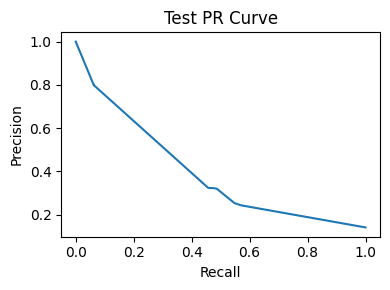

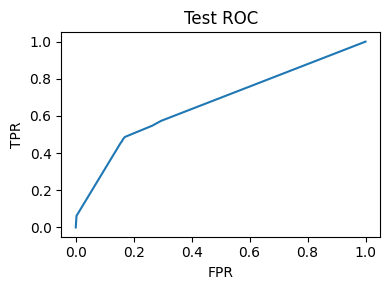

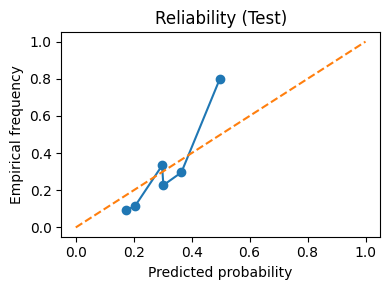

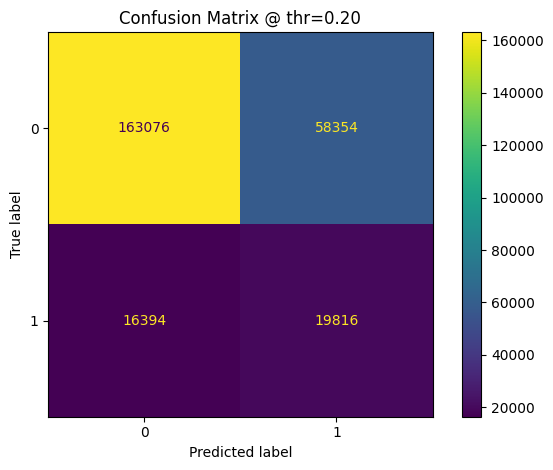

In [42]:
# %% [markdown]
# Soft-vote across folds; calibrate; evaluate on test

# Get per-fold probabilities (some models may be Booster)
test_proba_raw = np.zeros(X_test.shape[0], dtype=float)
for model in best_fold_models:
    test_proba_raw += predict_proba_any(model, X_test)
test_proba_raw /= len(best_fold_models)

test_proba = iso.transform(test_proba_raw)

test_ap = average_precision_score(y_test, test_proba)
test_roc = roc_auc_score(y_test, test_proba)
test_brier = brier_score_loss(y_test, test_proba)
y_pred = (test_proba >= thr_cal).astype(int)
test_fbeta = fbeta_score(y_test, y_pred, beta=BETA)

print(f"TEST: AP={test_ap:.3f}  ROC_AUC={test_roc:.3f}  Brier={test_brier:.4f}  F{BETA}={test_fbeta:.3f}")

# PR & ROC
prec, rec, _ = precision_recall_curve(y_test, test_proba)
fpr,  tpr, _ = roc_curve(y_test, test_proba)

plt.figure(figsize=(4,3)); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Test PR Curve"); plt.tight_layout(); plt.show()
plt.figure(figsize=(4,3)); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Test ROC"); plt.tight_layout(); plt.show()

# Reliability
prob_true, prob_pred = calibration_curve(y_test, test_proba, n_bins=20, strategy="uniform")
plt.figure(figsize=(4,3)); plt.plot(prob_pred, prob_true, marker="o"); plt.plot([0,1],[0,1],"--")
plt.xlabel("Predicted probability"); plt.ylabel("Empirical frequency"); plt.title("Reliability (Test)"); plt.tight_layout(); plt.show()

# Confusion matrix @ chosen threshold
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="viridis", values_format="d")
plt.title(f"Confusion Matrix @ thr={thr_cal:.2f}")
plt.tight_layout(); plt.show()

#### SHAP Interpretation (on stratified subsample for speed)

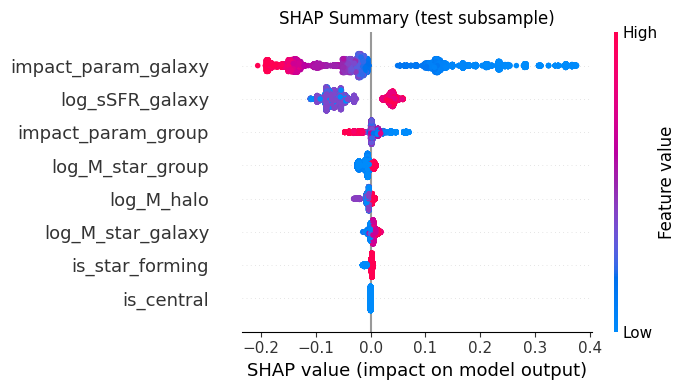

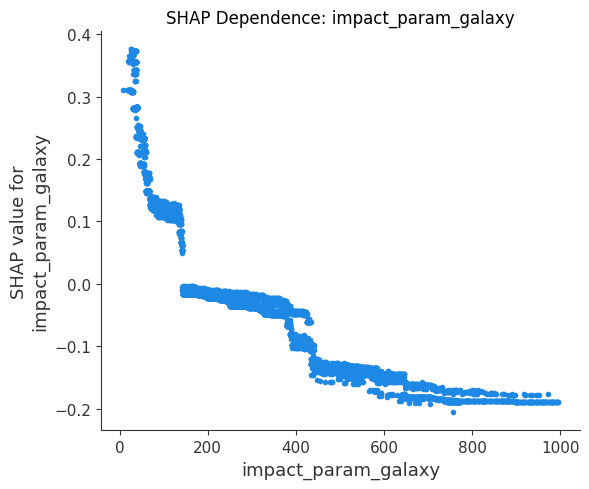

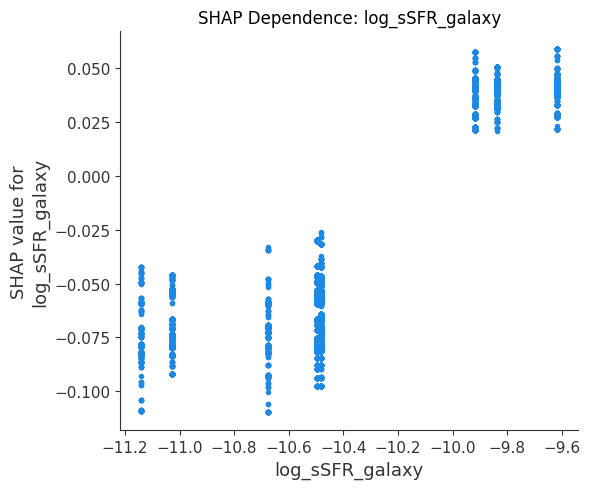

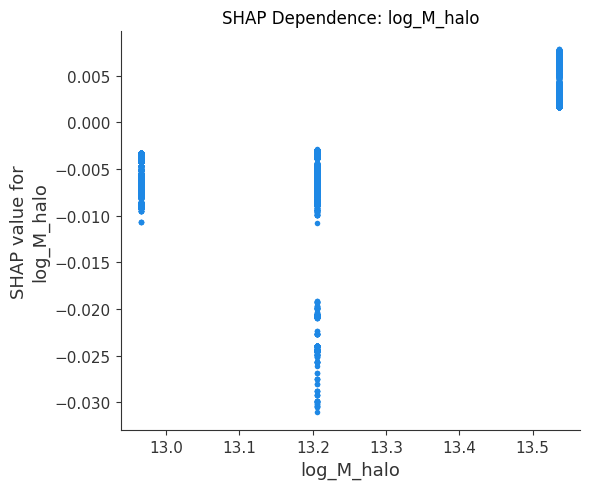

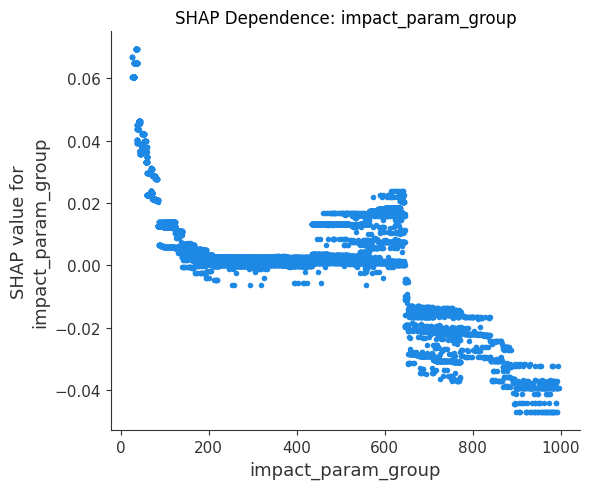

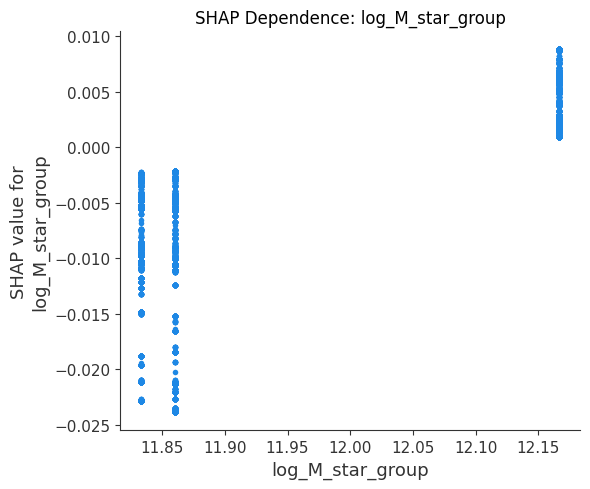

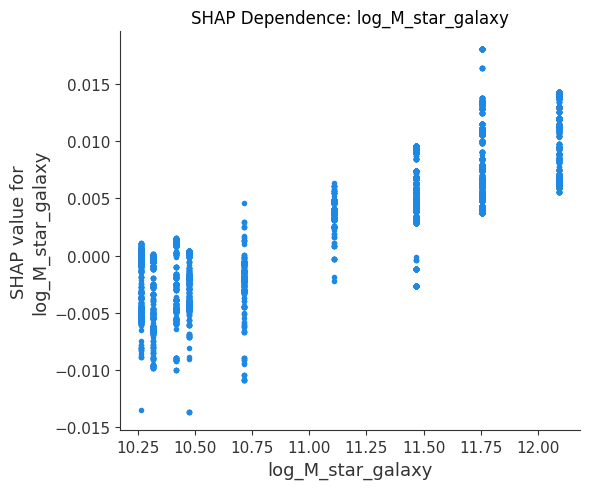

In [43]:
# %% [markdown]
# SHAP on a manageable test subsample (e.g., up to 10k points)

pos_idx = np.where(y_test==1)[0]
neg_idx = np.where(y_test==0)[0]
n_pos = min(5000, len(pos_idx))
n_neg = min(5000, len(neg_idx))
sub_idx = np.r_[rng.choice(pos_idx, n_pos, replace=False),
                rng.choice(neg_idx, n_neg, replace=False)]
X_shap = X_test.iloc[sub_idx]
y_shap = y_test[sub_idx]

explainer = shap.TreeExplainer(best_fold_models[0])
shap_vals = explainer.shap_values(X_shap)

shap.summary_plot(shap_vals, X_shap, show=False, plot_size=(7,4))
plt.title("SHAP Summary (test subsample)")
plt.tight_layout(); plt.show()

for feat in ["impact_param_galaxy","log_sSFR_galaxy","log_M_halo","impact_param_group","log_M_star_group","log_M_star_galaxy"]:
    shap.dependence_plot(feat, shap_vals, X_shap, interaction_index=None, show=False)
    plt.title(f"SHAP Dependence: {feat}")
    plt.tight_layout(); plt.show()

#### Save Artifacts (reproducibility)

In [ ]:
# %% [markdown]
# Save fold models, calibrator, feature list, threshold, and a run card

art = {
    "features": features,
    "beta": BETA,
    "monotone": USE_MONOTONIC,
    "best_params": best_params,
    "cv_metrics": {k: float(v) if isinstance(v, (int,float,np.floating)) else v for k,v in cv_best.items()},
    "threshold": float(thr_cal),
    "n_folds": N_SPLITS,
    "seed": SEED,
    "notes": "Grouped split by grp_idx; objective=PR-AUC; isotonic-calibrated."
}

joblib.dump(best_fold_models, OUT_DIR / "xgb_folds.joblib")
joblib.dump(iso, OUT_DIR / "isotonic_calibrator.joblib")
with open(OUT_DIR / "run_card.json", "w") as f:
    json.dump(art, f, indent=2)

print("Artifacts saved to:", OUT_DIR)

In [ ]:
# %% [markdown]
# Log summary metrics & artifacts to W&B (optional)

if USE_WANDB:
    try:
        run = wandb.init(project=WANDB_PROJECT, entity=WANDB_ENTITY,
                         config={"beta": BETA, "n_splits": N_SPLITS, "seed": SEED,
                                 "monotone": USE_MONOTONIC, **best_params},
                         name="xgb_groupedcv_calibrated", reinit=True)
        wandb.summary["cv_AP"] = cv_best["AP"]
        wandb.summary["cv_ROC_AUC"] = cv_best["ROC_AUC"]
        wandb.summary["cv_Brier"] = cv_best["Brier"]
        wandb.summary["thr_cal"] = thr_cal

        wandb.summary["test_AP"] = test_ap
        wandb.summary["test_ROC_AUC"] = test_roc
        wandb.summary["test_Brier"] = test_brier
        wandb.summary[f"test_F{BETA}"] = test_fbeta

        # optionally log figures (save then wandb.log({"pr": wandb.Image(path)}))
        run.finish()
    except Exception as e:
        print("[WARN] W&B summary logging failed:", e)

In [ ]:
# %% [markdown]
# LightGBM grouped-CV PR-AUC baseline (often competitive on tabular data)

# pip install lightgbm
import lightgbm as lgb

def lgb_objective(trial):
    params = {
        "objective": "binary",
        "metric": "average_precision",  # LightGBM >=4 has 'average_precision'
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 3e-1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 255),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-4, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-4, 10.0, log=True),
        "verbose": -1,
        "seed": SEED,
    }
    aps = []
    for tr, va in cv_splits(X_trainval, y_trainval, g_trainval, n_splits=N_SPLITS, seed=SEED):
        lgb_tr = lgb.Dataset(X_trainval.iloc[tr], label=y_trainval[tr])
        lgb_va = lgb.Dataset(X_trainval.iloc[va], label=y_trainval[va])
        model = lgb.train(params, lgb_tr,
                          valid_sets=[lgb_tr, lgb_va],
                          valid_names=["train","valid"],
                          num_boost_round=5000,
                          early_stopping_rounds=200,
                          verbose_eval=False)
        proba = model.predict(X_trainval.iloc[va], num_iteration=model.best_iteration)
        aps.append(average_precision_score(y_trainval[va], proba))
    return float(np.mean(aps))

# Example quick search (optional)
# lgb_study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
# lgb_study.optimize(lgb_objective, n_trials=40)
# print("LGBM Best AP:", lgb_study.best_value)

## Explainable Boosting Machines

In [45]:
# %% [markdown]
# O VI Absorber — EBMs with grouped splits, PR–AUC CV, calibration, effects & interactions

import os, json, warnings, joblib
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold, GroupKFold
from sklearn.metrics import (average_precision_score, roc_auc_score, fbeta_score,
                             precision_recall_curve, roc_curve, brier_score_loss)
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression

import optuna
from interpret.glassbox import ExplainableBoostingClassifier, ExplainableBoostingRegressor

warnings.filterwarnings("ignore")

# ---------- config ----------
SEED   = 42
BETA   = 1.0            # 0.5 (precision) / 1.0 (balanced) / 2.0 (recall)
N_SPLITS = 4            # robust for ~14 groups (auto-adjust below)
MAX_TUNE_SAMPLES = None # e.g., 250_000 to speed up Optuna; None = use all

BASE_PATH = "/Users/wavefunction/ASU Dropbox/Tanmay Singh/"
CSV_PATH  = os.path.join(BASE_PATH, "Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv")
OUT_DIR   = Path(BASE_PATH) / "Synthetic_IGrM_Sightlines/TNG50_fitting_results/ebm_runs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

rng = np.random.default_rng(SEED)

In [46]:
# %% [markdown]
# Load, coerce types, add missingness flag, DO NOT dedupe across groups.

usecols = [
    "Sightline","grp_idx","has_OVI_absorber",
    "log_M_halo","log_M_star_group","impact_param_group",
    "impact_param_galaxy","log_M_star_galaxy","log_sSFR_galaxy",
    "is_central","is_star_forming",
]
df = pd.read_csv(CSV_PATH, usecols=usecols, low_memory=False)

num_cols = ["log_M_halo","log_M_star_group","impact_param_group",
            "impact_param_galaxy","log_M_star_galaxy","log_sSFR_galaxy"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

for c in ["is_central","is_star_forming","has_OVI_absorber","grp_idx","Sightline"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

# order only (NO DEDUP; (grp_idx, Sightline) assumed unique)
df = df.sort_values(["grp_idx","Sightline"]).reset_index(drop=True)

# feature engineering
df["sSFR_missing"] = df["log_sSFR_galaxy"].isna().astype(int)

features = [
    "log_M_halo",
    "log_M_star_group",
    "impact_param_group",
    "impact_param_galaxy",
    "log_M_star_galaxy",
    "log_sSFR_galaxy",
    "is_central",
    "is_star_forming",
]
target    = "has_OVI_absorber"
group_col = "grp_idx"

X = df[features].copy()
y = df[target].astype(int).to_numpy()
g = df[group_col].astype(int).to_numpy()

print("Rows:", len(df), " Groups:", df[group_col].nunique(), " Pos fraction:", y.mean())

Rows: 1199446  Groups: 14  Pos fraction: 0.20717564608994485


In [47]:
# %% [markdown]
# Hold out entire groups for TEST, then do grouped CV on the remainder.

gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=SEED)
trval_idx, test_idx = next(gss.split(X, y, groups=g))
X_trainval, X_test = X.iloc[trval_idx], X.iloc[test_idx]
y_trainval, y_test = y[trval_idx], y[test_idx]
g_trainval, g_test = g[trval_idx], g[test_idx]

uniq_groups = np.unique(g_trainval).size
N_SPLITS = min(4, max(2, uniq_groups))
print("Using N_SPLITS:", N_SPLITS)

def cv_splits(X, y, groups, n_splits=N_SPLITS, seed=SEED):
    try:
        sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=seed)
        yield from sgkf.split(X, y, groups)
    except Exception:
        gkf = GroupKFold(n_splits=n_splits)
        yield from gkf.split(X, y, groups)

def pick_threshold_by_fbeta(y_true, y_proba, beta=BETA):
    prec, rec, thr = precision_recall_curve(y_true, y_proba)
    prec, rec = prec[:-1], rec[:-1]
    f = (1+beta**2) * (prec*rec) / (beta**2*prec + rec + 1e-12)
    i = int(np.nanargmax(f))
    return float(thr[i]), float(prec[i]), float(rec[i]), float(f[i])

def summarize_metrics(y_true, y_proba, beta=BETA, thr=None):
    ap  = average_precision_score(y_true, y_proba)
    roc = roc_auc_score(y_true, y_proba)
    if thr is None:
        thr, _, _, fopt = pick_threshold_by_fbeta(y_true, y_proba, beta)
    else:
        fopt = fbeta_score(y_true, (y_proba>=thr).astype(int), beta=beta)
    br  = brier_score_loss(y_true, y_proba)
    return {"AP": ap, "ROC_AUC": roc, "Brier": br, "thr": thr, "Fbeta": fopt}

Using N_SPLITS: 4


In [48]:
# %% [markdown]
# EBM baseline (few interactions), grouped OOF predictions for honest CV.

def make_ebm(params):
    # Keep to widely-supported args (works across interpret versions)
    return ExplainableBoostingClassifier(
        interactions      = params.get("interactions", 8),
        outer_bags        = params.get("outer_bags", 8),
        inner_bags        = params.get("inner_bags", 0),
        learning_rate     = params.get("learning_rate", 0.01),
        max_bins          = params.get("max_bins", 256),
        max_interaction_bins = params.get("max_interaction_bins", 32),
        min_samples_leaf  = params.get("min_samples_leaf", 2),
        max_leaves        = params.get("max_leaves", 3),
        random_state      = SEED,
    )

BASE_PARAMS = {
    "interactions": 8,
    "outer_bags": 8,
    "learning_rate": 0.01,
    "max_bins": 256,
    "max_interaction_bins": 32,
    "min_samples_leaf": 2,
    "max_leaves": 3,
}

# Optionally subsample for speed in tuning/baseline
if MAX_TUNE_SAMPLES and len(X_trainval) > MAX_TUNE_SAMPLES:
    idx = rng.choice(len(X_trainval), size=MAX_TUNE_SAMPLES, replace=False)
    X_cv = X_trainval.iloc[idx].reset_index(drop=True)
    y_cv = y_trainval[idx]
    g_cv = g_trainval[idx]
else:
    X_cv, y_cv, g_cv = X_trainval, y_trainval, g_trainval

oof_base = np.zeros_like(y_cv, dtype=float)
base_models = []
for k, (tr, va) in enumerate(cv_splits(X_cv, y_cv, g_cv), start=1):
    ebm = make_ebm(BASE_PARAMS)
    ebm.fit(X_cv.iloc[tr], y_cv[tr])
    proba = ebm.predict_proba(X_cv.iloc[va])[:,1]
    base_models.append(ebm)
    oof_base[va] = proba
    print(f"Fold {k}: AP={average_precision_score(y_cv[va], proba):.3f}, ROC={roc_auc_score(y_cv[va], proba):.3f}")

base_cv = summarize_metrics(y_cv, oof_base, beta=BETA)
thr_base = base_cv["thr"]
print("Baseline grouped-CV:", base_cv)

Fold 1: AP=0.331, ROC=0.539
Fold 2: AP=0.291, ROC=0.599
Fold 3: AP=0.193, ROC=0.510
Fold 4: AP=0.267, ROC=0.583
Baseline grouped-CV: {'AP': np.float64(0.28544103353361006), 'ROC_AUC': np.float64(0.5823021799182504), 'Brier': np.float64(0.20425522769476062), 'thr': 0.11282622162888133, 'Fbeta': 0.37576967486904245}


In [49]:
# %% [markdown]
# Tune a small set of EBM knobs; EBMs already regularized and robust.

def objective(trial):
    params = {
        "interactions": trial.suggest_int("interactions", 0, 12),
        "outer_bags": trial.suggest_int("outer_bags", 4, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 5e-2, log=True),
        "max_bins": trial.suggest_int("max_bins", 128, 512),
        "max_interaction_bins": trial.suggest_int("max_interaction_bins", 16, 64),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
        "max_leaves": trial.suggest_int("max_leaves", 2, 5),
    }
    aps = []
    for tr, va in cv_splits(X_cv, y_cv, g_cv, n_splits=N_SPLITS, seed=SEED):
        ebm = make_ebm(params)
        ebm.fit(X_cv.iloc[tr], y_cv[tr])
        proba = ebm.predict_proba(X_cv.iloc[va])[:,1]
        aps.append(average_precision_score(y_cv[va], proba))
    return float(np.mean(aps))

study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler(seed=SEED),
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=40)

print("Best CV AP:", study.best_value)
print("Best params:", study.best_trial.params)
BEST_PARAMS = study.best_trial.params

[I 2025-08-26 15:06:00,435] A new study created in memory with name: no-name-0b186530-4b47-4365-978a-b31387a98079
[I 2025-08-26 18:46:39,235] Trial 0 finished with value: 0.27981723122924973 and parameters: {'interactions': 4, 'outer_bags': 12, 'learning_rate': 0.01752410111812814, 'max_bins': 358, 'max_interaction_bins': 23, 'min_samples_leaf': 4, 'max_leaves': 2}. Best is trial 0 with value: 0.27981723122924973.
[W 2025-08-26 21:26:02,328] Trial 1 failed with parameters: {'interactions': 11, 'outer_bags': 9, 'learning_rate': 0.01595857358814127, 'max_bins': 135, 'max_interaction_bins': 63, 'min_samples_leaf': 17, 'max_leaves': 2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_23457/3873188335.py

KeyboardInterrupt: 

In [ ]:
# %% [markdown]
# Use the tuned params; collect OOF predictions for calibration.

oof_best = np.zeros_like(y_trainval, dtype=float)
fold_models = []

for k, (tr, va) in enumerate(cv_splits(X_trainval, y_trainval, g_trainval), start=1):
    ebm = make_ebm(BEST_PARAMS)
    ebm.fit(X_trainval.iloc[tr], y_trainval[tr])
    fold_models.append(ebm)
    oof_best[va] = ebm.predict_proba(X_trainval.iloc[va])[:,1]

cv_best = summarize_metrics(y_trainval, oof_best, beta=BETA)
print("Grouped-CV (best):", {k: round(v,3) if isinstance(v, float) else v for k,v in cv_best.items()})

In [ ]:
# %% [markdown]
# Calibrate probabilities and pick F_beta threshold using calibrated OOF.

iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(oof_best, y_trainval)

oof_cal = iso.transform(oof_best)
uncal_brier = brier_score_loss(y_trainval, oof_best)
cal_brier   = brier_score_loss(y_trainval, oof_cal)
thr_cal, p_opt, r_opt, f_opt = pick_threshold_by_fbeta(y_trainval, oof_cal, beta=BETA)

print(f"Brier (uncal→cal): {uncal_brier:.4f} → {cal_brier:.4f}")
print(f"Chosen threshold @ F{BETA}: {thr_cal:.3f}  (P={p_opt:.3f}, R={r_opt:.3f}, F={f_opt:.3f})")

In [ ]:
# %% [markdown]
# Soft-vote all fold models, calibrate, evaluate on TEST.

# Average fold probabilities
test_proba_raw = np.mean([m.predict_proba(X_test)[:,1] for m in fold_models], axis=0)
test_proba = iso.transform(test_proba_raw)

test_ap   = average_precision_score(y_test, test_proba)
test_roc  = roc_auc_score(y_test, test_proba)
test_brier= brier_score_loss(y_test, test_proba)
y_pred    = (test_proba >= thr_cal).astype(int)
test_f    = fbeta_score(y_test, y_pred, beta=BETA)

print(f"TEST: AP={test_ap:.3f}  ROC_AUC={test_roc:.3f}  Brier={test_brier:.4f}  F{BETA}={test_f:.3f}")

# PR, ROC, Reliability, Confusion
prec, rec, _ = precision_recall_curve(y_test, test_proba)
fpr,  tpr, _ = roc_curve(y_test, test_proba)

plt.figure(figsize=(4,3)); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Test PR"); plt.tight_layout(); plt.show()
plt.figure(figsize=(4,3)); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Test ROC"); plt.tight_layout(); plt.show()

prob_true, prob_pred = calibration_curve(y_test, test_proba, n_bins=20, strategy="uniform")
plt.figure(figsize=(4,3)); plt.plot(prob_pred, prob_true, marker="o"); plt.plot([0,1],[0,1],"--")
plt.xlabel("Pred prob"); plt.ylabel("Empirical freq"); plt.title("Reliability (Test)"); plt.tight_layout(); plt.show()

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="viridis", values_format="d")
plt.title(f"Confusion Matrix @ thr={thr_cal:.2f}")
plt.tight_layout(); plt.show()

In [ ]:
# %% [markdown]
# Global explanations: extract shapes & top interactions; draw publication-grade plots.

# Fit a single "analysis" EBM on all TRAINVAL (for clean global plots)
ebm_all = make_ebm(BEST_PARAMS)
ebm_all.fit(X_trainval, y_trainval)

# 8a) Main effects importance (sorted by overall contribution)
gexp = ebm_all.explain_global()
gdat = gexp.data()                 # dict with feature-level info
names = list(gdat["names"])        # feature names + any interaction tuples as strings
scores = np.array(gdat["scores"])  # overall strength (abs mean contribution)
order = np.argsort(scores)[::-1]

print("Top main effects / interactions:")
for i in order[:10]:
    print(f"{i:>2} {names[i]:<30} score={scores[i]:.4f}")

# 8b) Plot main-effect shapes for top-K 1D features
K = 6
plotted = 0
for idx in order:
    nm = names[idx]
    # Skip interactions in this block (interactions look like 'feature x feature')
    if " x " in nm:
        continue
    ed = gexp.data(nm)  # per-feature data: 'names','scores','upper_bounds','lower_bounds','breakpoints','scores'
    xs = np.array(ed["breakpoints"])
    ys = np.array(ed["scores"])
    ci_lo = np.array(ed.get("lower_bounds", [np.nan]*len(ys)))
    ci_hi = np.array(ed.get("upper_bounds", [np.nan]*len(ys)))

    plt.figure(figsize=(4.2,3))
    plt.plot(xs, ys)
    if np.isfinite(ci_lo).all() and np.isfinite(ci_hi).all():
        plt.fill_between(xs, ci_lo, ci_hi, alpha=0.2)
    plt.axhline(0, ls="--", lw=1, color="black")
    plt.title(f"Effect: {nm}")
    plt.xlabel(nm); plt.ylabel("logit contribution")
    plt.tight_layout(); plt.show()

    plotted += 1
    if plotted >= K:
        break

# 8c) Plot top 2 interactions as 2D surfaces (if any were learned)
# Interactions (if enabled in BEST_PARAMS) are included as names like 'featA x featB'
inter_names = [nm for nm in names if " x " in nm]
for nm in inter_names[:2]:
    ed = gexp.data(nm)
    x0 = np.array(ed["left_edges"])   # grid on feature A
    x1 = np.array(ed["right_edges"])  # grid on feature B (naming depends on version)
    Z  = np.array(ed["scores"]).reshape(len(x0), len(x1))

    # Heatmap
    plt.figure(figsize=(4.5,3.6))
    plt.imshow(Z, aspect="auto", origin="lower",
               extent=(x1.min(), x1.max(), x0.min(), x0.max()))
    plt.colorbar(label="logit contribution")
    plt.xlabel(nm.split(" x ")[1]); plt.ylabel(nm.split(" x ")[0])
    plt.title(f"Interaction: {nm}")
    plt.tight_layout(); plt.show()

In [ ]:
# %% [markdown]
# Two-part model: (1) classifier for detection, (2) regressor for logN | detected

# Suppose your table also has 'logN_OVI' for detected systems
if "logN_OVI" in df.columns:
    df["logN_OVI"] = pd.to_numeric(df["logN_OVI"], errors="coerce")
    mask_det = (df[target] == 1) & df["logN_OVI"].notna()
    X_reg = df.loc[mask_det, features].copy()
    y_reg = df.loc[mask_det, "logN_OVI"].to_numpy()

    # Simple train/valid split within TRAINVAL groups (reuse grouping if you want)
    ebm_reg = ExplainableBoostingRegressor(
        interactions=BEST_PARAMS.get("interactions", 6),
        outer_bags=8, learning_rate=0.01, max_bins=256,
        max_interaction_bins=32, min_samples_leaf=2, max_leaves=3,
        random_state=SEED
    )
    ebm_reg.fit(X_reg, y_reg)
    # Effects for column density
    r_exp = ebm_reg.explain_global()
    # Plot a few main effects for logN
    for nm in features[:4]:
        rd = r_exp.data(nm)
        xs, ys = np.array(rd["breakpoints"]), np.array(rd["scores"])
        plt.figure(figsize=(4.2,3))
        plt.plot(xs, ys); plt.axhline(0, ls="--", lw=1, color="black")
        plt.title(f"logN effect: {nm}")
        plt.xlabel(nm); plt.ylabel("Δ logN contribution")
        plt.tight_layout(); plt.show()